**Note:** This notebook is intended for Google Colab. Mount Drive or otherwise make your graph files available before running.

In [ ]:
# ==============================================
# 📦 Stage 0: Install Dependencies
# ==============================================
!pip install -q pandas openai langchain langchain-openai langchain-community pyvis fuzzywuzzy python-Levenshtein

# ==============================================
# 🔑 Stage 1: Imports & API Key
# ==============================================
from getpass import getpass
import pandas as pd
import json
import os
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from fuzzywuzzy import fuzz, process
import time

# Try to get API key from Colab secrets
try:
    from google.colab import userdata
    openai_api_key = userdata.get('OPENAI_API_KEY')
except Exception:
    openai_api_key = None

if not openai_api_key:
    openai_api_key = getpass("🔑 Enter your OpenAI API key:")

os.environ["OPENAI_API_KEY"] = openai_api_key

# ==============================================
# 🗂️ Stage 2: Load CSV Data
# ==============================================
CSV_PATH = "/content/drive/MyDrive/knowledge-graph-llms/data_all.csv"
df = pd.read_csv(CSV_PATH)
print(f"✅ Loaded CSV: {CSV_PATH}, Shape: {df.shape}")
print("\nColumn names:", df.columns.tolist())
print("\nFirst few job titles:")
print(df['Title'].head(10).tolist())
display(df.head(2))

# ==============================================
# 🏷️ Stage 3: Define Target Roles (Your Focus List)
# ==============================================
target_roles = [
    "Data Scientist",
    "Analytics Developer",
    "Analytics And Insights Manager",
    "Data Engineer",
    "Automation Manager",
    "Automation Technician",
    "Business Intelligence Developer",
    "Data Support Analyst",
    "Automation Systems Engineer",
    "Data Science Manager",
    "Artificial Intelligence Manager",
    "Group Manager Data And Iot",
    "Data Engineering Manager",
    "Director Of Data Management And Business Intelligence"
]

# ==============================================
# 🤖 Stage 4: Initialize LLM (GPT-4o-mini)
# ==============================================
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    openai_api_key=openai_api_key,
    max_tokens=1500
)
print("✅ LLM ready (gpt-4o-mini)")

# ==============================================
# 🔍 Stage 5: Helper Functions for Role Matching
# ==============================================

def normalize_text(text):
    """Normalize text for comparison"""
    if pd.isna(text):
        return ""
    return str(text).lower().strip().replace("  ", " ")

def find_direct_match(job_title, target_roles):
    """Check for direct title matches to save API calls"""
    job_title_norm = normalize_text(job_title)

    # Create normalized mapping
    role_mapping = {normalize_text(role): role for role in target_roles}

    # Direct match
    if job_title_norm in role_mapping:
        return role_mapping[job_title_norm]

    # Handle plurals - both ways
    # Remove 's' from job title
    if job_title_norm.endswith('s') and job_title_norm[:-1] in role_mapping:
        return role_mapping[job_title_norm[:-1]]

    # Add 's' to job title
    if job_title_norm + 's' in role_mapping:
        return role_mapping[job_title_norm + 's']

    # Remove 's' from target roles
    for norm_role, original_role in role_mapping.items():
        if norm_role.endswith('s') and job_title_norm == norm_role[:-1]:
            return original_role

    return None

def contains_keywords_match(job_title, target_roles):
    """Check if job title contains key parts of target roles"""
    job_title_norm = normalize_text(job_title)

    # Mapping of keywords to target roles
    keyword_mappings = {
        # Data roles
        'data scientist': 'Data Scientist',
        'data engineer': 'Data Engineer',
        'data support': 'Data Support Analyst',
        'data science manager': 'Data Science Manager',
        'data engineering manager': 'Data Engineering Manager',
        'data architect': 'Data Engineer',  # Map architects to engineers
        'data expert': 'Data Scientist',    # Map experts to scientists

        # Analytics roles
        'analytics': 'Analytics Developer',  # Default analytics mapping
        'analytics developer': 'Analytics Developer',
        'analytics engineer': 'Analytics Developer',
        'analytics and insights manager': 'Analytics And Insights Manager',
        'insights analyst': 'Analytics Developer',
        'reporting and analytics manager': 'Analytics And Insights Manager',

        # Business Intelligence
        'business intelligence': 'Business Intelligence Developer',
        'bi developer': 'Business Intelligence Developer',
        'bi analyst': 'Business Intelligence Developer',

        # Automation roles
        'automation manager': 'Automation Manager',
        'automation technician': 'Automation Technician',
        'automation systems engineer': 'Automation Systems Engineer',
        'automation engineer': 'Automation Systems Engineer',

        # AI roles
        'artificial intelligence': 'Artificial Intelligence Manager',
        'ai manager': 'Artificial Intelligence Manager',

        # Director roles
        'director of data': 'Director Of Data Management And Business Intelligence',
        'director of business intelligence': 'Director Of Data Management And Business Intelligence',

        # IoT roles
        'group manager data': 'Group Manager Data And Iot',
        'iot': 'Group Manager Data And Iot',
    }

    # Check each keyword mapping
    for keyword, target_role in keyword_mappings.items():
        if keyword in job_title_norm:
            return target_role

    return None

def fuzzy_match_role(job_title, target_roles, threshold=80):  # Lowered threshold
    """Use fuzzy matching for similar titles"""
    if pd.isna(job_title) or job_title == "":
        return None

    # Normalize for comparison
    job_title_norm = normalize_text(job_title)
    target_roles_norm = [normalize_text(role) for role in target_roles]

    # Create mapping back to original
    norm_to_original = {normalize_text(role): role for role in target_roles}

    # Try different fuzzy matching methods
    best_match = process.extractOne(job_title_norm, target_roles_norm, scorer=fuzz.ratio)

    if best_match and best_match[1] >= threshold:
        return norm_to_original[best_match[0]]

    # Try token sort ratio for reordered words
    best_match = process.extractOne(job_title_norm, target_roles_norm, scorer=fuzz.token_sort_ratio)

    if best_match and best_match[1] >= threshold:
        return norm_to_original[best_match[0]]

    # Try partial ratio for substring matching
    best_match = process.extractOne(job_title_norm, target_roles_norm, scorer=fuzz.partial_ratio)

    if best_match and best_match[1] >= 85:  # Higher threshold for partial matches
        return norm_to_original[best_match[0]]

    return None

# ==============================================
# 📝 Stage 6: Improved Semantic Role Normalization Prompt
# ==============================================
role_mapping_prompt = PromptTemplate.from_template("""
You are an expert in talent intelligence and job role classification.

Target roles list:
{roles}

Job being analyzed:
- JOB TITLE: "{job_title}"
- JOB DESCRIPTION (first 500 chars): {job_text_snippet}

Instructions:
1. Focus primarily on the job title first
2. If the title contains "Data Scientist" (singular or plural) → map to "Data Scientist"
3. If the title contains "Data Engineer" (singular or plural) → map to "Data Engineer"
4. For "Manager" roles, only map to managerial target roles if the description confirms management responsibilities
5. For generic titles like "Group Manager", only map to "Group Manager Data And Iot" if IoT or data is explicitly mentioned
6. Consider these exact mappings:
   - "Analytics and Insights Manager(s)" → "Analytics And Insights Manager"
   - "Analytics Developer(s)" → "Analytics Developer"
   - "Data Support Analyst(s)" → "Data Support Analyst"
   - "Business Intelligence Developer/Analyst" → "Business Intelligence Developer"

Return ONLY ONE of these:
- The exact target role name from the list above (if there's a match)
- "NONE" (if no match)

Do not add any explanation. Return only the role name or "NONE".
""")

# ==============================================
# ⏳ Stage 7: Enhanced Role Mapping with Multiple Strategies
# ==============================================
role_mapping_results = []
debug_limit = None  # Set to None to process all rows, or a number to limit

print("\n🔄 Starting role mapping process...\n")

for idx, row in df.iterrows():
    job_title = str(row.get('Title', '')).strip()
    job_text = str(row.get('JobText', ''))[:500]  # First 500 chars for context

    if pd.isna(job_title) or job_title == 'nan' or job_title == '':
        mapped_role = None
        method = "empty_title"
    else:
        # Strategy 1: Try direct match first
        mapped_role = find_direct_match(job_title, target_roles)
        method = "direct_match"

        # Strategy 2: Try keyword-based matching
        if not mapped_role:
            mapped_role = contains_keywords_match(job_title, target_roles)
            method = "keyword_match"

        # Strategy 3: Try fuzzy matching
        if not mapped_role:
            mapped_role = fuzzy_match_role(job_title, target_roles, threshold=75)  # Lower threshold
            method = "fuzzy_match"

        # Strategy 4: Use LLM for semantic matching
        if not mapped_role:
            try:
                role_query = role_mapping_prompt.format(
                    roles='\n'.join(target_roles),
                    job_title=job_title,
                    job_text_snippet=job_text
                )

                llm_response = llm.invoke(role_query).content.strip()
                mapped_role = llm_response if llm_response.upper() != "NONE" else None
                method = "llm_semantic"

                # Rate limiting
                time.sleep(0.1)

            except Exception as e:
                print(f"⚠️  LLM error at row {idx}: {e}")
                mapped_role = None
                method = "llm_error"

    role_mapping_results.append({
        "idx": idx,
        "original_job_title": job_title,
        "job_text": job_text,
        "mapped_role": mapped_role,
        "mapping_method": method
    })

    # Progress indicator
    if mapped_role:
        print(f"✅ [{idx}] '{job_title}' → '{mapped_role}' (via {method})")
    else:
        print(f"❌ [{idx}] '{job_title}' → No match")

    if debug_limit and idx + 1 >= debug_limit:
        break

# Convert to DataFrame and analyze results
df_role_map = pd.DataFrame(role_mapping_results)
df_role_map_checkpoint = df_role_map[df_role_map['mapped_role'].notnull()]

print(f"\n📊 Mapping Results Summary:")
print(f"Total rows processed: {len(df_role_map)}")
print(f"Successfully mapped: {len(df_role_map_checkpoint)} ({len(df_role_map_checkpoint)/len(df_role_map)*100:.1f}%)")
print(f"\nMapping methods used:")
print(df_role_map['mapping_method'].value_counts())
print(f"\nMapped roles distribution:")
print(df_role_map_checkpoint['mapped_role'].value_counts())

# Analyze unmapped roles
unmapped_df = df_role_map[df_role_map['mapped_role'].isnull()]
unmapped_titles = unmapped_df['original_job_title'].value_counts()

print(f"\n❌ Top 20 unmapped job titles (that might need attention):")
for title, count in unmapped_titles.head(20).items():
    if title and title != 'nan':
        print(f"  - {title}: {count} occurrences")

# Look for patterns in unmapped titles
print(f"\n🔍 Potential candidates for mapping (containing keywords):")
keywords_to_check = ['data', 'analyt', 'intelligence', 'automat', 'ai', 'machine', 'insight']
for _, row in unmapped_df.iterrows():
    title = str(row['original_job_title']).lower()
    if any(keyword in title for keyword in keywords_to_check) and row['original_job_title'] != 'nan':
        print(f"  - {row['original_job_title']} (row {row['idx']})")

display(df_role_map_checkpoint.head(10))

# ==============================================
# 💾 Optional: Save mapping results
# ==============================================
# df_role_map.to_csv("/content/role_mapping_results.csv", index=False)

# ==============================================
# 📝 Stage 8: Improved Extraction Prompt
# ==============================================
graph_extraction_prompt = PromptTemplate.from_template("""
You are an expert in analyzing job descriptions to extract competency requirements.

From the job description below, extract structured information about competencies.

Rules:
1. Extract ONLY what is explicitly mentioned in the job description
2. Use the exact wording from the job description when possible
3. Focus on concrete skills, tools, and responsibilities
4. Separate technical skills from soft skills appropriately

JOB TITLE: {job_title}
MAPPED ROLE: {normalized_role}
JOB DESCRIPTION: {job_text}

Return a JSON object with this EXACT structure:
{{
  "role": "{normalized_role}",
  "tasks": ["list of main responsibilities/tasks mentioned"],
  "technical_skills": ["technical skills, certifications, methodologies"],
  "soft_skills": ["communication, leadership, teamwork skills"],
  "tools": ["specific software, platforms, technologies mentioned"],
  "relationships": [
    {{"source": "{normalized_role}", "type": "performs", "target": "each task"}},
    {{"source": "{normalized_role}", "type": "requires", "target": "each skill"}},
    {{"source": "{normalized_role}", "type": "uses", "target": "each tool"}}
  ]
}}

Return ONLY valid JSON. No commentary or markdown.
""")

# ==============================================
# 🧹 Utility Functions
# ==============================================
def clean_llm_json(raw_str):
    """Clean LLM JSON output"""
    if not raw_str:
        return "{}"

    cleaned = raw_str.strip()

    # Remove markdown code blocks
    if cleaned.startswith("```"):
        cleaned = cleaned.split("```")[1]
        if cleaned.lower().startswith("json"):
            cleaned = cleaned[4:]

    # Remove trailing markdown
    if cleaned.endswith("```"):
        cleaned = cleaned[:-3]

    return cleaned.strip()

def validate_extraction(data):
    """Validate extracted data structure"""
    required_keys = ['role', 'tasks', 'technical_skills', 'soft_skills', 'tools', 'relationships']

    for key in required_keys:
        if key not in data:
            data[key] = [] if key != 'role' else ""

    # Ensure lists are lists
    for key in ['tasks', 'technical_skills', 'soft_skills', 'tools', 'relationships']:
        if not isinstance(data[key], list):
            data[key] = []

    return data

# ==============================================
# ⏳ Stage 9: Graph Extraction (Only for Mapped Roles)
# ==============================================
extraction_results = []
extract_limit = None  # Changed from 20 to None to process all mapped roles

print(f"\n🔄 Starting extraction for {len(df_role_map_checkpoint)} mapped roles...\n")

for i, (idx, row) in enumerate(df_role_map_checkpoint.iterrows()):
    if extract_limit and i >= extract_limit:
        break

    mapped_role = row['mapped_role']
    job_title = row['original_job_title']
    job_text = row['job_text']

    try:
        graph_query = graph_extraction_prompt.format(
            normalized_role=mapped_role,
            job_title=job_title,
            job_text=job_text
        )

        graph_response = llm.invoke(graph_query).content.strip()
        graph_response_clean = clean_llm_json(graph_response)

        # Parse JSON
        data = json.loads(graph_response_clean)
        data = validate_extraction(data)

        # Add metadata
        data['original_job_title'] = job_title
        data['mapped_role'] = mapped_role
        data['extraction_success'] = True

        extraction_results.append(data)
        print(f"✅ [{i+1}/{min(len(df_role_map_checkpoint), extract_limit or len(df_role_map_checkpoint))}] Extracted: '{job_title}' → '{mapped_role}'")

        # Rate limiting
        time.sleep(0.2)

    except json.JSONDecodeError as e:
        print(f"⚠️  JSON parse error for '{job_title}': {e}")
        extraction_results.append({
            'original_job_title': job_title,
            'mapped_role': mapped_role,
            'extraction_success': False,
            'error': str(e),
            'raw_response': graph_response_clean[:200]
        })
    except Exception as e:
        print(f"⚠️  Extraction error for '{job_title}': {e}")
        extraction_results.append({
            'original_job_title': job_title,
            'mapped_role': mapped_role,
            'extraction_success': False,
            'error': str(e)
        })

# ==============================================
# 📊 Stage 10: Results Analysis
# ==============================================
df_extracted = pd.DataFrame(extraction_results)
successful_extractions = df_extracted[df_extracted.get('extraction_success', False) == True]

print(f"\n📊 Extraction Results Summary:")
print(f"Total attempted: {len(df_extracted)}")
print(f"Successfully extracted: {len(successful_extractions)} ({len(successful_extractions)/len(df_extracted)*100:.1f}%)")

if len(successful_extractions) > 0:
    print(f"\n🎯 Sample extracted data:")
    display(successful_extractions[['original_job_title', 'mapped_role', 'tasks', 'technical_skills']].head())

# ==============================================
# 💾 Stage 11: Save Results
# ==============================================
output_path = "/content/extracted_knowledge_graph_data.csv"
df_extracted.to_csv(output_path, index=False)
print(f"\n💾 Results saved to: {output_path}")

# ==============================================
# 📈 Stage 12: Visualize Knowledge Graph (Optional)
# ==============================================
if len(successful_extractions) > 0:
    from pyvis.network import Network
    import networkx as nx

    # Create a sample visualization with first 5 roles
    net = Network(height="750px", width="100%", notebook=True, bgcolor="#222222", font_color="white")

    sample_data = successful_extractions.head(5)

    for _, row in sample_data.iterrows():
        role = row['mapped_role']

        # Add role node
        net.add_node(role, color="#ff6b6b", size=30, title=role, shape="box")

        # Add task nodes and edges
        for task in row.get('tasks', [])[:3]:  # Limit to 3 tasks per role
            task_id = f"{role}_{task[:20]}"
            net.add_node(task_id, label=task[:30] + "...", color="#4ecdc4", size=15, title=task)
            net.add_edge(role, task_id, title="performs", color="#95e1d3")

        # Add skill nodes and edges
        for skill in row.get('technical_skills', [])[:3]:  # Limit to 3 skills
            skill_id = f"skill_{skill[:20]}"
            if skill_id not in net.get_nodes():
                net.add_node(skill_id, label=skill[:20] + "...", color="#f38181", size=15, title=skill)
            net.add_edge(role, skill_id, title="requires", color="#aa96da")

        # Add tool nodes and edges
        for tool in row.get('tools', [])[:3]:  # Limit to 3 tools
            tool_id = f"tool_{tool[:20]}"
            if tool_id not in net.get_nodes():
                net.add_node(tool_id, label=tool[:20] + "...", color="#feca57", size=15, title=tool)
            net.add_edge(role, tool_id, title="uses", color="#48dbfb")

    # Configure physics
    net.force_atlas_2based()
    net.show_buttons(filter_=['physics'])

    # Save and display
    net.show("/content/knowledge_graph_sample.html")
    print("\n🌐 Sample knowledge graph saved to: /content/knowledge_graph_sample.html")

print("\n✅ Knowledge graph extraction complete!")

✅ Loaded CSV: /content/drive/MyDrive/knowledge-graph-llms/data_all.csv, Shape: (300, 11)

Column names: ['Employer', 'JobID', 'City', 'State', 'Title', 'JobDate', 'ANZSIC CODE', 'ANZSCO CODE', 'LOT CODE', 'JobText', 'JobUrl']

First few job titles:
['Analytics and Insights Managers', 'Automation Managers', 'Mechanical Service Technicians', 'Data Engineers', 'Data Engineers', 'Asset Managers', 'Payroll Officers', 'Asset Engineers', 'Asset Managers', 'Data Scientists']


Employer                                     JobID         City  \
0   Mirvac  37716b56223ca91a66bc3600c87bdbc62053504c  Sydney, AUS   
1   Mirvac  c90b87856a372ce9d4117ce89f98afdb63d546df  Sydney, AUS   

             State                            Title    JobDate  ANZSIC CODE  \
0  New South Wales  Analytics and Insights Managers   3/1/2021         3020   
1  New South Wales              Automation Managers  13/2/2021         3020   

   ANZSCO CODE  LOT CODE                                            JobText  \
0     111211.0    271112  * Company Mirvac Group -\n    Description\n   ...   
1     261399.0    231512  1006\n    \n    Solution Engineer, Intelligent...   

                                              JobUrl  
0  https://www.jobisjob.com.au/l/mirvac-group/nat...  
1  https://mirvac.csod.com/ux/ats/careersite/1/ho...

✅ LLM ready (gpt-4o-mini)

🔄 Starting role mapping process...

✅ [0] 'Analytics and Insights Managers' → 'Analytics And Insights Manager' (via direct_match)
✅ [1] 'Automation Managers' → 'Automation Manager' (via direct_match)
❌ [2] 'Mechanical Service Technicians' → No match
✅ [3] 'Data Engineers' → 'Data Engineer' (via direct_match)
✅ [4] 'Data Engineers' → 'Data Engineer' (via direct_match)
❌ [5] 'Asset Managers' → No match
❌ [6] 'Payroll Officers' → No match
✅ [7] 'Asset Engineers' → 'Data Engineer' (via fuzzy_match)
❌ [8] 'Asset Managers' → No match
✅ [9] 'Data Scientists' → 'Data Scientist' (via direct_match)
✅ [10] 'Analytics Developers' → 'Analytics Developer' (via direct_match)
✅ [11] 'Data Scientists' → 'Data Scientist' (via direct_match)
✅ [12] 'Operations Managers' → 'Automation Manager' (via fuzzy_match)
❌ [13] 'Tunnel Engineers' → No match
❌ [14] 'Mechanical Service Technicians' → No match
✅ [15] 'Data Support Analysts' → 'Data Support Analyst' (via direct_match)
✅ [16] '

idx               original_job_title  \
0     0  Analytics and Insights Managers   
1     1              Automation Managers   
3     3                   Data Engineers   
4     4                   Data Engineers   
7     7                  Asset Engineers   
9     9                  Data Scientists   
10   10             Analytics Developers   
11   11                  Data Scientists   
12   12              Operations Managers   
15   15            Data Support Analysts   

                                             job_text  \
0   * Company Mirvac Group -\n    Description\n   ...   
1   1006\n    \n    Solution Engineer, Intelligent...   
3   Data Engineer\n    \n    \n    \n    \n    \n ...   
4   27-May-2021\n    \n    07-Jul-2021\n    \n    ...   
7   National Asset Engineer\n    Christchurch\n   ...   
9   Data Scientist\n    \n    Job ID\n        9943...   
10  Analytics Developer\n    \n    At Lendlease, w...   
11  Data Scientist\n    \n    \n    \n    Date: 20...   
12  Operations Manager - Darwin\n    \n    Johnath...   
15  Data Support Analyst\n    \n    At Lendlease, ...   

                       mapped_role mapping_method  
0   Analytics And Insights Manager   direct_match  
1               Automation Manager   direct_match  
3                    Data Engineer   direct_match  
4                    Data Engineer   direct_match  
7                    Data Engineer    fuzzy_match  
9                   Data Scientist   direct_match  
10             Analytics Developer   direct_match  
11                  Data Scientist   direct_match  
12              Automation Manager    fuzzy_match  
15            Data Support Analyst   direct_match


🔄 Starting extraction for 65 mapped roles...

✅ [1/65] Extracted: 'Analytics and Insights Managers' → 'Analytics And Insights Manager'
✅ [2/65] Extracted: 'Automation Managers' → 'Automation Manager'
✅ [3/65] Extracted: 'Data Engineers' → 'Data Engineer'
✅ [4/65] Extracted: 'Data Engineers' → 'Data Engineer'
✅ [5/65] Extracted: 'Asset Engineers' → 'Data Engineer'
✅ [6/65] Extracted: 'Data Scientists' → 'Data Scientist'
✅ [7/65] Extracted: 'Analytics Developers' → 'Analytics Developer'
✅ [8/65] Extracted: 'Data Scientists' → 'Data Scientist'
✅ [9/65] Extracted: 'Operations Managers' → 'Automation Manager'
✅ [10/65] Extracted: 'Data Support Analysts' → 'Data Support Analyst'
✅ [11/65] Extracted: 'Group Managers' → 'Group Manager Data And Iot'
✅ [12/65] Extracted: 'Digital Engineers' → 'Data Engineer'
✅ [13/65] Extracted: 'Data Scientists' → 'Data Scientist'
✅ [14/65] Extracted: 'Business Intelligence Analysts' → 'Business Intelligence Developer'
✅ [15/65] Extracted: 'IT Engineers' → 'Da

original_job_title                     mapped_role  \
0  Analytics and Insights Managers  Analytics And Insights Manager   
1              Automation Managers              Automation Manager   
2                   Data Engineers                   Data Engineer   
3                   Data Engineers                   Data Engineer   
4                  Asset Engineers                   Data Engineer   

                                               tasks  \
0  [deliver a return on investment, proactively s...   
1                                                 []   
2                                                 []   
3  [Support the growth and capability of Sedgman ...   
4  [providing industry leading asset management, ...   

                           technical_skills  
0  [predictive analytics, machine-learning]  
1                                        []  
2                                        []  
3                                        []  
4                                        []


💾 Results saved to: /content/extracted_knowledge_graph_data.csv
/content/knowledge_graph_sample.html

🌐 Sample knowledge graph saved to: /content/knowledge_graph_sample.html

✅ Knowledge graph extraction complete!


In [ ]:
# ==============================================
# 📈 Stage 12: Create and Export Knowledge Graph to GraphML
# ==============================================
# Run this cell after the extraction is complete

# Check if we have successful extractions
if 'successful_extractions' not in locals() or len(successful_extractions) == 0:
    print("⚠️  No successful extractions found. Please run the extraction code first.")
else:
    from pyvis.network import Network
    import networkx as nx
    import pandas as pd
    import os

    # Create NetworkX graph for export
    G = nx.DiGraph()

    # Process all successful extractions
    print("🔄 Building knowledge graph from extracted data...")

    for _, row in successful_extractions.iterrows():
        role = row['mapped_role']

        # Add role node with attributes
        G.add_node(role,
                   node_type='role',
                   color='#ff6b6b',
                   size=30,
                   original_title=row['original_job_title'])

        # Add task nodes and edges
        for task in row.get('tasks', []):
            task_id = f"task_{hash(task) % 10000}_{task[:30]}"
            if not G.has_node(task_id):
                G.add_node(task_id,
                          node_type='task',
                          label=task,
                          color='#4ecdc4',
                          size=15)
            G.add_edge(role, task_id, relationship='performs')

        # Add technical skill nodes and edges
        for skill in row.get('technical_skills', []):
            skill_id = f"skill_{skill}"
            if not G.has_node(skill_id):
                G.add_node(skill_id,
                          node_type='technical_skill',
                          label=skill,
                          color='#f38181',
                          size=15)
            G.add_edge(role, skill_id, relationship='requires')

        # Add soft skill nodes and edges
        for skill in row.get('soft_skills', []):
            soft_skill_id = f"soft_skill_{skill}"
            if not G.has_node(soft_skill_id):
                G.add_node(soft_skill_id,
                          node_type='soft_skill',
                          label=skill,
                          color='#ff9ff3',
                          size=15)
            G.add_edge(role, soft_skill_id, relationship='requires')

        # Add tool nodes and edges
        for tool in row.get('tools', []):
            tool_id = f"tool_{tool}"
            if not G.has_node(tool_id):
                G.add_node(tool_id,
                          node_type='tool',
                          label=tool,
                          color='#feca57',
                          size=15)
            G.add_edge(role, tool_id, relationship='uses')

    # Print graph statistics
    print(f"\n📊 Knowledge Graph Statistics:")
    print(f"Total nodes: {G.number_of_nodes()}")
    print(f"Total edges: {G.number_of_edges()}")
    print(f"Node types:")
    node_types = {}
    for node, attrs in G.nodes(data=True):
        node_type = attrs.get('node_type', 'unknown')
        node_types[node_type] = node_types.get(node_type, 0) + 1
    for node_type, count in sorted(node_types.items()):
        print(f"  - {node_type}: {count}")

    # Export to GraphML
    graphml_path = "/content/drive/MyDrive/knowledge-graph-llms/AI_related_roles.graphml"

    # Ensure directory exists
    os.makedirs(os.path.dirname(graphml_path), exist_ok=True)

    # Write GraphML file
    nx.write_graphml(G, graphml_path)
    print(f"\n💾 GraphML file saved to: {graphml_path}")

    # Also save a human-readable summary
    summary_path = "/content/drive/MyDrive/knowledge-graph-llms/AI_related_roles_summary.txt"
    with open(summary_path, 'w') as f:
        f.write("AI-Related Roles Knowledge Graph Summary\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Generated on: {pd.Timestamp.now()}\n")
        f.write(f"Total roles processed: {len(successful_extractions)}\n")
        f.write(f"Total nodes: {G.number_of_nodes()}\n")
        f.write(f"Total edges: {G.number_of_edges()}\n\n")

        f.write("Roles included:\n")
        role_counts = successful_extractions['mapped_role'].value_counts()
        for role, count in role_counts.items():
            f.write(f"  - {role}: {count} instances\n")

        f.write(f"\nNode type distribution:\n")
        for node_type, count in sorted(node_types.items()):
            f.write(f"  - {node_type}: {count}\n")

        # Add top skills and tools
        f.write(f"\nTop Technical Skills:\n")
        all_skills = []
        for skills in successful_extractions['technical_skills']:
            if isinstance(skills, list):
                all_skills.extend(skills)
        skill_counts = pd.Series(all_skills).value_counts().head(20)
        for skill, count in skill_counts.items():
            f.write(f"  - {skill}: {count} occurrences\n")

        f.write(f"\nTop Tools/Technologies:\n")
        all_tools = []
        for tools in successful_extractions['tools']:
            if isinstance(tools, list):
                all_tools.extend(tools)
        tool_counts = pd.Series(all_tools).value_counts().head(20)
        for tool, count in tool_counts.items():
            f.write(f"  - {tool}: {count} occurrences\n")

    print(f"📄 Summary file saved to: {summary_path}")

    # Create a sample visualization with PyVis (first 10 roles for performance)
    print("\n🎨 Creating sample visualization...")
    net = Network(height="750px", width="100%", notebook=True, bgcolor="#222222", font_color="white")

    sample_data = successful_extractions.head(10)
    sample_nodes = set()

    for _, row in sample_data.iterrows():
        role = row['mapped_role']
        sample_nodes.add(role)

        # Add role node
        net.add_node(role, color="#ff6b6b", size=30, title=role, shape="box")

        # Add limited nodes for visualization
        for task in row.get('tasks', [])[:2]:  # Limit to 2 tasks
            task_id = f"task_{hash(task) % 10000}_{task[:30]}"
            if task_id in G.nodes():
                net.add_node(task_id, label=task[:30] + "...", color="#4ecdc4", size=15, title=task)
                net.add_edge(role, task_id, title="performs", color="#95e1d3")

        for skill in row.get('technical_skills', [])[:2]:  # Limit to 2 skills
            skill_id = f"skill_{skill}"
            if skill_id not in net.get_nodes() and skill_id in G.nodes():
                net.add_node(skill_id, label=skill[:20] + "...", color="#f38181", size=15, title=skill)
            if skill_id in net.get_nodes():
                net.add_edge(role, skill_id, title="requires", color="#aa96da")

    # Configure physics
    net.force_atlas_2based()
    net.show_buttons(filter_=['physics'])

    # Save visualization
    net.show("/content/knowledge_graph_sample.html")
    print("🌐 Sample visualization saved to: /content/knowledge_graph_sample.html")

    print("\n✅ Knowledge graph export complete!")
    print(f"\n📁 Files created:")
    print(f"  1. {graphml_path}")
    print(f"  2. {summary_path}")
    print(f"  3. /content/knowledge_graph_sample.html")

    # Print final advice
    print("\n💡 Next steps:")
    print("  - Import the GraphML file into Neo4j, Gephi, or your preferred graph tool")
    print("  - Use the summary file to understand the graph structure")
    print("  - View the HTML file for an interactive sample visualization")

🔄 Building knowledge graph from extracted data...

📊 Knowledge Graph Statistics:
Total nodes: 127
Total edges: 120
Node types:
  - role: 13
  - soft_skill: 14
  - task: 46
  - technical_skill: 39
  - tool: 15

💾 GraphML file saved to: /content/drive/MyDrive/knowledge-graph-llms/AI_related_roles.graphml
📄 Summary file saved to: /content/drive/MyDrive/knowledge-graph-llms/AI_related_roles_summary.txt

🎨 Creating sample visualization...
/content/knowledge_graph_sample.html
🌐 Sample visualization saved to: /content/knowledge_graph_sample.html

✅ Knowledge graph export complete!

📁 Files created:
  1. /content/drive/MyDrive/knowledge-graph-llms/AI_related_roles.graphml
  2. /content/drive/MyDrive/knowledge-graph-llms/AI_related_roles_summary.txt
  3. /content/knowledge_graph_sample.html

💡 Next steps:
  - Import the GraphML file into Neo4j, Gephi, or your preferred graph tool
  - Use the summary file to understand the graph structure
  - View the HTML file for an interactive sample visualiz

In [ ]:
# Check which target roles are missing from the extracted data

# Your target roles
target_roles = [
    "Data Scientist",
    "Analytics Developer",
    "Analytics And Insights Manager",
    "Data Engineer",
    "Automation Manager",
    "Automation Technician",
    "Business Intelligence Developer",
    "Data Support Analyst",
    "Automation Systems Engineer",
    "Data Science Manager",
    "Artificial Intelligence Manager",
    "Group Manager Data And Iot",
    "Data Engineering Manager",
    "Director Of Data Management And Business Intelligence"
]

# Get unique roles from successful extractions
if 'successful_extractions' in locals():
    extracted_roles = successful_extractions['mapped_role'].unique()

    print("📊 Role Matching Analysis:")
    print(f"Target roles defined: {len(target_roles)}")
    print(f"Unique roles extracted: {len(extracted_roles)}")
    print(f"Role nodes in graph: 13")

    # Find missing roles
    missing_roles = set(target_roles) - set(extracted_roles)

    print(f"\n❌ Missing target roles (never found in data):")
    for role in missing_roles:
        print(f"  - {role}")

    # Show distribution of found roles
    print(f"\n✅ Found target roles and their occurrences:")
    role_counts = successful_extractions['mapped_role'].value_counts()
    for role in target_roles:
        if role in role_counts.index:
            print(f"  - {role}: {role_counts[role]} instances")

    # Check if there are any unexpected roles
    unexpected_roles = set(extracted_roles) - set(target_roles)
    if unexpected_roles:
        print(f"\n⚠️  Unexpected roles found:")
        for role in unexpected_roles:
            print(f"  - {role}")
else:
    print("⚠️  No extraction data found. Please run the extraction first.")

📊 Role Matching Analysis:
Target roles defined: 14
Unique roles extracted: 13
Role nodes in graph: 13

❌ Missing target roles (never found in data):
  - Director Of Data Management And Business Intelligence

✅ Found target roles and their occurrences:
  - Data Scientist: 15 instances
  - Analytics Developer: 8 instances
  - Analytics And Insights Manager: 1 instances
  - Data Engineer: 12 instances
  - Automation Manager: 4 instances
  - Automation Technician: 2 instances
  - Business Intelligence Developer: 4 instances
  - Data Support Analyst: 1 instances
  - Automation Systems Engineer: 11 instances
  - Data Science Manager: 1 instances
  - Artificial Intelligence Manager: 1 instances
  - Group Manager Data And Iot: 4 instances
  - Data Engineering Manager: 1 instances


#Inspect Existing Graph Structure

In [ ]:
# ==============================================
# 🔍 Inspect Existing Graph Structure
# ==============================================

import networkx as nx
import pandas as pd
from collections import defaultdict

# Path to your existing graph
existing_graph_path = "/content/drive/MyDrive/knowledge-graph-llms/graph_backups/G_with_tool_usage_as_tasks_and_dedup_20250707_073854.graphml"

print("🔍 Inspecting existing graph structure...\n")

# Load the graph
try:
    G = nx.read_graphml(existing_graph_path)
    print(f"✅ Loaded graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
except Exception as e:
    print(f"❌ Error loading graph: {e}")
    raise

# ==============================================
# 📊 Analyze Node Structure
# ==============================================
print("\n📊 NODE ANALYSIS")
print("=" * 70)

# Sample some nodes to understand structure
sample_nodes = list(G.nodes(data=True))[:20]
print(f"\n🔍 First 20 nodes and their attributes:")
for i, (node_id, attrs) in enumerate(sample_nodes):
    print(f"\n{i+1}. Node ID: {node_id}")
    print(f"   Attributes: {dict(attrs)}")

# Analyze all unique attribute keys across all nodes
print("\n🔑 Analyzing all unique node attributes...")
all_attr_keys = defaultdict(int)
attr_value_samples = defaultdict(set)

for node, attrs in G.nodes(data=True):
    for key, value in attrs.items():
        all_attr_keys[key] += 1
        if len(attr_value_samples[key]) < 5:  # Collect up to 5 samples
            attr_value_samples[key].add(str(value)[:100])  # Truncate long values

print(f"\n📋 Node attribute statistics:")
for key, count in sorted(all_attr_keys.items(), key=lambda x: -x[1]):
    print(f"\n- '{key}': appears in {count}/{G.number_of_nodes()} nodes ({count/G.number_of_nodes()*100:.1f}%)")
    print(f"  Sample values: {list(attr_value_samples[key])[:3]}")

# ==============================================
# 🔗 Analyze Edge Structure
# ==============================================
print("\n\n🔗 EDGE ANALYSIS")
print("=" * 70)

# Sample some edges
sample_edges = list(G.edges(data=True))[:10]
print(f"\n🔍 First 10 edges and their attributes:")
for i, (u, v, attrs) in enumerate(sample_edges):
    print(f"\n{i+1}. Edge: {u} → {v}")
    print(f"   Attributes: {dict(attrs)}")

# Analyze edge attributes
edge_attr_keys = defaultdict(int)
edge_attr_samples = defaultdict(set)

for u, v, attrs in G.edges(data=True):
    for key, value in attrs.items():
        edge_attr_keys[key] += 1
        if len(edge_attr_samples[key]) < 5:
            edge_attr_samples[key].add(str(value)[:100])

print(f"\n📋 Edge attribute statistics:")
for key, count in sorted(edge_attr_keys.items(), key=lambda x: -x[1]):
    print(f"\n- '{key}': appears in {count}/{G.number_of_edges()} edges ({count/G.number_of_edges()*100:.1f}%)")
    print(f"  Sample values: {list(edge_attr_samples[key])[:3]}")

# ==============================================
# 🎯 Try to identify node types
# ==============================================
print("\n\n🎯 ATTEMPTING TO IDENTIFY NODE TYPES")
print("=" * 70)

# Look for potential type indicators
potential_type_attrs = ['type', 'node_type', 'category', 'class', 'label', 'kind']
found_type_attr = None

for attr in potential_type_attrs:
    if attr in all_attr_keys:
        found_type_attr = attr
        print(f"\n✅ Found potential type attribute: '{attr}'")
        break

if found_type_attr:
    # Analyze node types
    node_types = defaultdict(int)
    type_samples = defaultdict(list)

    for node, attrs in G.nodes(data=True):
        node_type = attrs.get(found_type_attr, 'no_type')
        node_types[node_type] += 1
        if len(type_samples[node_type]) < 3:
            type_samples[node_type].append(node)

    print(f"\n📊 Node type distribution (using '{found_type_attr}'):")
    for node_type, count in sorted(node_types.items(), key=lambda x: -x[1]):
        print(f"\n- {node_type}: {count} nodes")
        print(f"  Examples: {type_samples[node_type]}")
else:
    print("\n⚠️  No obvious type attribute found. Trying pattern analysis...")

    # Try to infer types from node ID patterns
    node_patterns = defaultdict(list)
    for node in list(G.nodes())[:100]:  # Sample first 100
        # Check for common prefixes
        if '_' in str(node):
            prefix = str(node).split('_')[0]
            node_patterns[prefix].append(node)
        elif str(node).startswith(('skill', 'task', 'tool', 'role')):
            prefix = str(node).split()[0]
            node_patterns[prefix].append(node)

    if node_patterns:
        print("\n📊 Node ID patterns found:")
        for pattern, nodes in sorted(node_patterns.items(), key=lambda x: -len(x[1])):
            if len(nodes) > 1:
                print(f"- Pattern '{pattern}': {len(nodes)} nodes")
                print(f"  Examples: {nodes[:3]}")

# ==============================================
# 🔍 Look for AI-related content
# ==============================================
print("\n\n🤖 SEARCHING FOR AI-RELATED NODES")
print("=" * 70)

ai_keywords = ['data', 'ai', 'artificial', 'intelligence', 'analytics', 'engineer',
               'scientist', 'automation', 'machine', 'learning', 'developer']

ai_related_nodes = []
for node, attrs in G.nodes(data=True):
    node_str = str(node).lower()
    attrs_str = str(attrs).lower()

    if any(keyword in node_str or keyword in attrs_str for keyword in ai_keywords):
        ai_related_nodes.append((node, attrs))

print(f"\nFound {len(ai_related_nodes)} potentially AI-related nodes")
if ai_related_nodes:
    print("\nFirst 10 AI-related nodes:")
    for node, attrs in ai_related_nodes[:10]:
        print(f"- {node}: {dict(attrs)}")

# ==============================================
# 💡 Recommendations
# ==============================================
print("\n\n💡 STRUCTURE ANALYSIS SUMMARY")
print("=" * 70)

if not found_type_attr:
    print("\n⚠️  The existing graph doesn't have a clear 'node_type' attribute.")
    print("    This explains why all nodes showed as 'unknown' in the merge analysis.")

print("\n📌 Key findings:")
print(f"- Total nodes: {G.number_of_nodes()}")
print(f"- Total edges: {G.number_of_edges()}")
print(f"- Node attributes: {list(all_attr_keys.keys())}")
print(f"- Edge attributes: {list(edge_attr_keys.keys())}")

print("\n🔧 To align the new graph with this structure, we need to:")
print("1. Identify how node types are represented in the existing graph")
print("2. Map the new graph's 'node_type' attribute to match")
print("3. Ensure node IDs follow the same naming convention")
print("4. Match edge relationship types if applicable")

🔍 Inspecting existing graph structure...

✅ Loaded graph: 1660 nodes, 2068 edges

📊 NODE ANALYSIS

🔍 First 20 nodes and their attributes:

1. Node ID: n0
   Attributes: {'labels': ':Role', 'id': 'Analytics And Insights Manager', 'ai_role_type': 'Emerging Role'}

2. Node ID: n1
   Attributes: {'labels': ':Technical skill', 'id': 'Predictive Analytics'}

3. Node ID: n2
   Attributes: {'labels': ':Technical skill', 'id': 'Machine Learning'}

4. Node ID: n3
   Attributes: {'labels': ':Soft skill', 'id': 'Communication'}

5. Node ID: n4
   Attributes: {'labels': ':Soft skill', 'id': 'Project Management'}

6. Node ID: n5
   Attributes: {'labels': ':Technical skill', 'id': 'Google Analytics'}

7. Node ID: n6
   Attributes: {'labels': ':Technical skill', 'id': 'Google Ads'}

8. Node ID: n7
   Attributes: {'labels': ':Technical skill', 'id': 'Tag Manager'}

9. Node ID: n8
   Attributes: {'labels': ':Technical skill', 'id': 'Webmaster Tools'}

10. Node ID: n9
   Attributes: {'labels': ':Task', '

#Align and Enrich Existing Graph

In [ ]:
# ==============================================
# 🔄 Enrich ALL 14 Target Roles (including OSCA nodes)
# ==============================================

import networkx as nx
import pandas as pd
from collections import defaultdict
import os
from datetime import datetime

# Install required libraries
print("📦 Installing required libraries...")
!pip install -q networkx pandas

# File paths
new_graph_path = "/content/drive/MyDrive/knowledge-graph-llms/AI_related_roles.graphml"
existing_graph_path = "/content/drive/MyDrive/knowledge-graph-llms/graph_backups/G_with_tool_usage_as_tasks_and_dedup_20250707_073854.graphml"

# Output paths
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
enriched_graph_path = f"/content/drive/MyDrive/knowledge-graph-llms/enriched_graph_complete_{timestamp}.graphml"
report_path = f"/content/drive/MyDrive/knowledge-graph_llms/enrichment_report_complete_{timestamp}.txt"

# Load graphs
print("\n📊 Loading data...")
G_existing = nx.read_graphml(existing_graph_path)
print(f"✅ Loaded existing graph: {G_existing.number_of_nodes()} nodes, {G_existing.number_of_edges()} edges")

G_new = nx.read_graphml(new_graph_path)
print(f"✅ Loaded new graph: {G_new.number_of_nodes()} nodes, {G_new.number_of_edges()} edges")

# ==============================================
# 🎯 Map ALL 14 Target Roles
# ==============================================
print("\n🎯 Mapping all 14 target roles...")

# Complete mapping including OSCA nodes
role_mapping = {
    # Regular :Role nodes (using 'id' attribute)
    "Analytics And Insights Manager": None,
    "Automation Manager": None,
    "Analytics Developer": None,
    "Data Support Analyst": None,
    "Group Manager Data And Iot": None,
    "Automation Systems Engineer": None,
    "Data Science Manager": None,
    "Artificial Intelligence Manager": None,
    "Data Engineering Manager": None,
    "Business Intelligence Developer": None,
    "Director Of Data Management And Business Intelligence": None,
    # OSCA nodes (will use 'description' attribute)
    "Data Scientist": "osca_223234",
    "Data Engineer": "osca_223233",
    "Automation Technician": "osca_313999"
}

# Find nodes for regular roles
for node, attrs in G_existing.nodes(data=True):
    if attrs.get('labels') == ':Role' and 'id' in attrs:
        role_name = attrs['id']
        if role_name in role_mapping:
            role_mapping[role_name] = node

# Verify all mappings
print("\n✅ Complete role mapping:")
for role, node_id in role_mapping.items():
    if node_id:
        node_attrs = G_existing.nodes[node_id]
        label = node_attrs.get('labels')
        identifier = node_attrs.get('id') or node_attrs.get('description')
        print(f"  - {role}: {node_id} ({label}: {identifier})")
    else:
        print(f"  - {role}: NOT FOUND")

# ==============================================
# 🔧 Enrichment Functions
# ==============================================
def convert_node_type(new_type):
    """Convert new graph node types to existing graph labels"""
    mapping = {
        'role': ':Role',
        'task': ':Task',
        'technical_skill': ':Technical skill',
        'soft_skill': ':Soft skill',
        'tool': ':Tool'
    }
    return mapping.get(new_type, ':Unknown')

def convert_edge_type(relationship):
    """Convert new graph edge types to existing graph labels"""
    mapping = {
        'performs': 'PERFORMS_TASK',
        'requires': 'REQUIRES_SKILL',
        'uses': 'USES_TOOL'
    }
    return mapping.get(relationship, 'RELATED_TO')

def find_existing_node(graph, node_type, item_id):
    """Find if a node with given type and id already exists"""
    for node, attrs in graph.nodes(data=True):
        if attrs.get('labels') == node_type and attrs.get('id') == item_id:
            return node
    return None

# ==============================================
# 🔧 Enrich Graph
# ==============================================
print("\n🔧 Starting enrichment process...")

G_enriched = G_existing.copy()

# Get highest node number
max_node_num = max([int(n[1:]) for n in G_enriched.nodes() if n.startswith('n') and n[1:].isdigit()], default=-1)
next_node_num = max_node_num + 1

# Statistics
stats = {
    'roles_enriched': 0,
    'osca_roles_enriched': 0,
    'regular_roles_enriched': 0,
    'new_tasks': 0,
    'new_skills': 0,
    'new_tools': 0,
    'new_edges': 0
}

# Process each role
for role_name, node_id in role_mapping.items():
    if not node_id:
        print(f"\n❌ Skipping {role_name} - not found")
        continue

    print(f"\n📝 Enriching: {role_name} ({node_id})")

    # Check if it's an OSCA node
    node_attrs = G_enriched.nodes[node_id]
    is_osca = node_attrs.get('labels') == ':OSCAOccupation'

    # Find this role in the new graph
    role_in_new = None
    for node, attrs in G_new.nodes(data=True):
        if attrs.get('node_type') == 'role' and node == role_name:
            role_in_new = node
            break

    if not role_in_new:
        print(f"  ⚠️  Role not found in new graph")
        continue

    stats['roles_enriched'] += 1
    if is_osca:
        stats['osca_roles_enriched'] += 1
    else:
        stats['regular_roles_enriched'] += 1

    # Get all connections from the new graph
    connections_added = 0
    for neighbor in G_new.neighbors(role_in_new):
        neighbor_attrs = G_new.nodes[neighbor]
        edge_attrs = G_new.edges[role_in_new, neighbor]

        node_type = neighbor_attrs.get('node_type')
        item_label = neighbor_attrs.get('label', neighbor)

        # Convert to existing graph format
        existing_type = convert_node_type(node_type)
        existing_edge_type = convert_edge_type(edge_attrs.get('relationship'))

        # Check if this item already exists
        existing_item_node = find_existing_node(G_enriched, existing_type, item_label)

        if existing_item_node:
            # Item exists - just add edge if missing
            if not G_enriched.has_edge(node_id, existing_item_node):
                G_enriched.add_edge(node_id, existing_item_node, label=existing_edge_type)
                stats['new_edges'] += 1
                connections_added += 1
                print(f"  + Added edge to existing {node_type}: {item_label}")
        else:
            # Create new node
            new_node_id = f"n{next_node_num}"
            next_node_num += 1

            G_enriched.add_node(new_node_id,
                              labels=existing_type,
                              id=item_label)

            # Add edge
            G_enriched.add_edge(node_id, new_node_id, label=existing_edge_type)

            # Update statistics
            if node_type == 'task':
                stats['new_tasks'] += 1
            elif node_type in ['technical_skill', 'soft_skill']:
                stats['new_skills'] += 1
            elif node_type == 'tool':
                stats['new_tools'] += 1

            stats['new_edges'] += 1
            connections_added += 1
            print(f"  + Added new {node_type}: {item_label}")

    if connections_added == 0:
        print(f"  ℹ️  No new connections added (role may already be fully connected)")

# ==============================================
# 📊 Generate Report
# ==============================================
report = []
report.append("=" * 70)
report.append("COMPLETE GRAPH ENRICHMENT REPORT - ALL 14 ROLES")
report.append("=" * 70)
report.append(f"\nTimestamp: {datetime.now()}")
report.append(f"\nTarget roles: 14")
report.append(f"Roles successfully enriched: {stats['roles_enriched']}/14")
report.append(f"  - Regular (:Role) nodes enriched: {stats['regular_roles_enriched']}")
report.append(f"  - OSCA (:OSCAOccupation) nodes enriched: {stats['osca_roles_enriched']}")

report.append("\n\n📊 ENRICHMENT STATISTICS")
report.append("-" * 50)
report.append(f"New nodes added:")
report.append(f"  - Tasks: {stats['new_tasks']}")
report.append(f"  - Skills: {stats['new_skills']}")
report.append(f"  - Tools: {stats['new_tools']}")
report.append(f"  - Total: {stats['new_tasks'] + stats['new_skills'] + stats['new_tools']}")
report.append(f"\nNew edges added: {stats['new_edges']}")

report.append("\n\n📈 FINAL GRAPH SIZE")
report.append("-" * 50)
report.append(f"Nodes: {G_existing.number_of_nodes()} → {G_enriched.number_of_nodes()} (+{G_enriched.number_of_nodes() - G_existing.number_of_nodes()})")
report.append(f"Edges: {G_existing.number_of_edges()} → {G_enriched.number_of_edges()} (+{G_enriched.number_of_edges() - G_existing.number_of_edges()})")

report.append("\n\n✅ ROLES ENRICHED")
report.append("-" * 50)
for role, node_id in role_mapping.items():
    if node_id:
        node_attrs = G_enriched.nodes[node_id]
        label = node_attrs.get('labels')
        report.append(f"{role} ({node_id}) - {label}")

# Print and save report
report_text = "\n".join(report)
print("\n" + report_text)

with open(report_path, 'w') as f:
    f.write(report_text)

# Save enriched graph
nx.write_graphml(G_enriched, enriched_graph_path)
print(f"\n💾 Enriched graph saved to: {enriched_graph_path}")
print(f"📄 Report saved to: {report_path}")

# ==============================================
# 🔍 Verification - Show sample enriched OSCA nodes
# ==============================================
print("\n\n🔍 VERIFICATION - OSCA nodes enrichment:")
osca_roles = ["Data Scientist", "Data Engineer", "Automation Technician"]
for role in osca_roles:
    node_id = role_mapping.get(role)
    if node_id:
        print(f"\n{role} ({node_id}):")
        # Count connections
        neighbors = list(G_enriched.neighbors(node_id))
        print(f"  Total connections: {len(neighbors)}")
        # Show first 5 connections
        for neighbor in neighbors[:5]:
            neighbor_attrs = G_enriched.nodes[neighbor]
            print(f"  → {neighbor_attrs.get('id', 'unnamed')} ({neighbor_attrs.get('labels')})")

print("\n✅ Complete enrichment finished!")

📦 Installing required libraries...

📊 Loading data...
✅ Loaded existing graph: 1660 nodes, 2068 edges
✅ Loaded new graph: 127 nodes, 120 edges

🎯 Mapping all 14 target roles...

✅ Complete role mapping:
  - Analytics And Insights Manager: n0 (:Role: Analytics And Insights Manager)
  - Automation Manager: n16 (:Role: Automation Manager)
  - Analytics Developer: n163 (:Role: Analytics Developer)
  - Data Support Analyst: n228 (:Role: Data Support Analyst)
  - Group Manager Data And Iot: n402 (:Role: Group Manager Data And Iot)
  - Automation Systems Engineer: n579 (:Role: Automation Systems Engineer)
  - Data Science Manager: n930 (:Role: Data Science Manager)
  - Artificial Intelligence Manager: n1349 (:Role: Artificial Intelligence Manager)
  - Data Engineering Manager: n1544 (:Role: Data Engineering Manager)
  - Business Intelligence Developer: n2043 (:Role: Business Intelligence Developer)
  - Director Of Data Management And Business Intelligence: n2406 (:Role: Director Of Data Manag

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/knowledge-graph_llms/enrichment_report_complete_20250707_235609.txt'

In [ ]:
# Correct path for saving
correct_report_path = "/content/drive/MyDrive/knowledge-graph-llms/enrichment_report_complete_20250707_235609.txt"

with open(correct_report_path, 'w') as f:
    f.write(report_text)

print(f"Report saved to: {correct_report_path}")


Report saved to: /content/drive/MyDrive/knowledge-graph-llms/enrichment_report_complete_20250707_235609.txt


In [ ]:
import networkx as nx
from collections import Counter

# Use the actual file name you found
enriched_graph_path = "/content/drive/MyDrive/knowledge-graph-llms/enriched_graph_all_roles_20250707_235146.graphml"

G = nx.read_graphml(enriched_graph_path)

report = []
report.append("="*70)
report.append("ENRICHED GRAPH SUMMARY REPORT")
report.append("="*70)
report.append(f"Total nodes: {G.number_of_nodes()}")
report.append(f"Total edges: {G.number_of_edges()}")

# Node types
node_types = [data.get('labels', 'Unknown') for _, data in G.nodes(data=True)]
type_counts = Counter(node_types)
report.append("\nNode counts by type:")
for t, c in type_counts.items():
    report.append(f"  - {t}: {c}")

# Edge types
edge_types = [data.get('label', 'Unknown') for _,_,data in G.edges(data=True)]
edge_counts = Counter(edge_types)
report.append("\nEdge counts by type:")
for t, c in edge_counts.items():
    report.append(f"  - {t}: {c}")

# Example nodes per type
report.append("\nExample nodes (one per type):")
for t in type_counts:
    for n, data in G.nodes(data=True):
        if data.get('labels') == t:
            identifier = data.get('id', n)
            report.append(f"  - {t}: {identifier}")
            break

# Optional: find isolated nodes
isolated = list(nx.isolates(G))
report.append(f"\nIsolated nodes (no connections): {len(isolated)}")

# Print and (optionally) save
full_report = "\n".join(report)
print(full_report)

with open("/content/drive/MyDrive/knowledge-graph-llms/ENRICHED_GRAPH_SUMMARY.txt", "w") as f:
    f.write(full_report)


ENRICHED GRAPH SUMMARY REPORT
Total nodes: 1714
Total edges: 2122

Node counts by type:
  - :Role: 85
  - :Technical skill: 934
  - :Soft skill: 204
  - :Task: 122
  - :Tool: 324
  - :Skill: 2
  - :OSCAOccupation: 43

Edge counts by type:
  - REQUIRES_SKILL: 1007
  - USES_TOOL: 265
  - PERFORMS_TASK: 142
  - INVOLVES_SKILL: 118
  - Unknown: 410
  - REQUIRES_TOOL: 120
  - MATCHED_TO_OSCA: 31
  - REQUIRES_EXPERIENCE: 29

Example nodes (one per type):
  - :Role: Analytics And Insights Manager
  - :Technical skill: Predictive Analytics
  - :Soft skill: Communication
  - :Task: Market Research
  - :Tool: Google Analytics
  - :Skill: n2422
  - :OSCAOccupation: osca_149999

Isolated nodes (no connections): 392


In [ ]:
import networkx as nx
from collections import Counter
import pandas as pd

# Load enriched graph
enriched_graph_path = "/content/drive/MyDrive/knowledge-graph-llms/enriched_graph_all_roles_20250707_235146.graphml"
G = nx.read_graphml(enriched_graph_path)

# Find isolated nodes
isolated_nodes = list(nx.isolates(G))
isolated_info = [
    {
        "node_id": n,
        "label": G.nodes[n].get("labels", "Unknown"),
        "name": G.nodes[n].get("id", G.nodes[n].get("description", n))
    }
    for n in isolated_nodes
]

# Count by type
type_counts = Counter([i["label"] for i in isolated_info])
print("Isolated nodes by type:")
for t, c in type_counts.items():
    print(f"  - {t}: {c}")

# Show first 10 as sample
print("\nSample isolated nodes:")
for i in isolated_info[:10]:
    print(f"  {i['node_id']}: {i['label']} - {i['name']}")

# Optional: Export to CSV for review
df = pd.DataFrame(isolated_info)
df.to_csv("/content/drive/MyDrive/knowledge-graph-llms/ISOLATED_NODES.csv", index=False)
print("\nFull list exported to ISOLATED_NODES.csv")


Isolated nodes by type:
  - :Technical skill: 350
  - :Task: 4
  - :Soft skill: 20
  - :Role: 1
  - :Tool: 14
  - :Skill: 2
  - :OSCAOccupation: 1

Sample isolated nodes:
  n5: :Technical skill - Google Analytics
  n6: :Technical skill - Google Ads
  n7: :Technical skill - Tag Manager
  n8: :Technical skill - Webmaster Tools
  n27: :Technical skill - Uipath
  n41: :Technical skill - Hvac Systems
  n51: :Technical skill - Driver'S Licence
  n52: :Technical skill - Safety Documentation
  n67: :Technical skill - Jupyter Notebooks
  n68: :Technical skill - Opencv

Full list exported to ISOLATED_NODES.csv


In [ ]:
# Find edges with 'Unknown' label
unknown_edges = [
    {
        "source": u,
        "target": v,
        "src_label": G.nodes[u].get("labels", "Unknown"),
        "src_id": G.nodes[u].get("id", G.nodes[u].get("description", u)),
        "tgt_label": G.nodes[v].get("labels", "Unknown"),
        "tgt_id": G.nodes[v].get("id", G.nodes[v].get("description", v)),
        "edge_label": d.get("label", "Unknown")
    }
    for u, v, d in G.edges(data=True)
    if d.get("label", "Unknown") == "Unknown"
]

print(f"\nTotal edges with 'Unknown' label: {len(unknown_edges)}")
# Example of node types being connected by 'Unknown' label
type_pairs = Counter((e['src_label'], e['tgt_label']) for e in unknown_edges)
print("Type pairs for 'Unknown' edges (top 5):")
for pair, count in type_pairs.most_common(5):
    print(f"  {pair}: {count}")

# Show first 5 unknown edges as sample
print("\nSample unknown edges:")
for e in unknown_edges[:5]:
    print(f"  {e['source']} ({e['src_label']}: {e['src_id']}) → {e['target']} ({e['tgt_label']}: {e['tgt_id']})")

# Optional: Export full unknown edges for review
df_unk = pd.DataFrame(unknown_edges)
df_unk.to_csv("/content/drive/MyDrive/knowledge-graph-llms/UNKNOWN_EDGES.csv", index=False)
print("\nFull list exported to UNKNOWN_EDGES.csv")



Total edges with 'Unknown' label: 410
Type pairs for 'Unknown' edges (top 5):
  (':Task', ':Technical skill'): 162
  (':Task', ':Tool'): 125
  (':Task', ':Soft skill'): 117
  (':Task', ':Task'): 5
  (':Task', ':OSCAOccupation'): 1

Sample unknown edges:
  n10 (:Task: Customer Data Analysis) → n2 (:Technical skill: Machine Learning)
  n57 (:Task: Data Preparation And Analysis) → n76 (:Tool: Opencv)
  n57 (:Task: Data Preparation And Analysis) → n77 (:Tool: Scipy)
  n57 (:Task: Data Preparation And Analysis) → n78 (:Tool: Numpy)
  n60 (:Task: Create Reports And Dashboards) → n72 (:Technical skill: Lorawan)

Full list exported to UNKNOWN_EDGES.csv


In [ ]:
import networkx as nx

# Load the graph
enriched_graph_path = "/content/drive/MyDrive/knowledge-graph-llms/enriched_graph_all_roles_20250707_235146.graphml"
G = nx.read_graphml(enriched_graph_path)

# Remove isolated nodes
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)
print(f"Removed {len(isolated_nodes)} isolated nodes.")

# Save cleaned graph
cleaned_path = "/content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_no_isolates.graphml"
nx.write_graphml(G, cleaned_path)
print(f"Graph without isolated nodes saved to: {cleaned_path}")


Removed 392 isolated nodes.
Graph without isolated nodes saved to: /content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_no_isolates.graphml


In [ ]:
# Relabel ambiguous/unknown edges
count = 0
for u, v, d in G.edges(data=True):
    if d.get("label", "Unknown") == "Unknown":
        src_label = G.nodes[u].get("labels", "")
        tgt_label = G.nodes[v].get("labels", "")
        # Apply relabelling rules
        if src_label == ":Task" and tgt_label == ":Technical skill":
            new_label = "REQUIRES_SKILL"
        elif src_label == ":Task" and tgt_label == ":Tool":
            new_label = "USES_TOOL"
        elif src_label == ":Task" and tgt_label == ":Soft skill":
            new_label = "REQUIRES_SOFT_SKILL"
        elif src_label == ":Task" and tgt_label == ":Task":
            new_label = "RELATED_TASK"
        elif src_label == ":Task" and tgt_label == ":OSCAOccupation":
            new_label = "ASSOCIATED_WITH_OSCA"
        else:
            new_label = "RELATED_TO"
        d["label"] = new_label
        count += 1
print(f"Relabelled {count} ambiguous ('Unknown') edges.")

# Save final cleaned graph
final_path = "/content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_no_isolates_relabelled.graphml"
nx.write_graphml(G, final_path)
print(f"Final cleaned and robustly labelled graph saved to: {final_path}")


Relabelled 410 ambiguous ('Unknown') edges.
Final cleaned and robustly labelled graph saved to: /content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_no_isolates_relabelled.graphml


In [ ]:
import networkx as nx
from collections import Counter

cleaned_path = "/content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_no_isolates_relabelled.graphml"
G = nx.read_graphml(cleaned_path)

report = []
report.append("="*70)
report.append("CLEANED & LABELLED GRAPH SUMMARY REPORT")
report.append("="*70)
report.append(f"Total nodes: {G.number_of_nodes()}")
report.append(f"Total edges: {G.number_of_edges()}")

# Node types
node_types = [data.get('labels', 'Unknown') for _, data in G.nodes(data=True)]
type_counts = Counter(node_types)
report.append("\nNode counts by type:")
for t, c in type_counts.items():
    report.append(f"  - {t}: {c}")

# Edge types
edge_types = [data.get('label', 'Unknown') for _,_,data in G.edges(data=True)]
edge_counts = Counter(edge_types)
report.append("\nEdge counts by type:")
for t, c in edge_counts.items():
    report.append(f"  - {t}: {c}")

# Example nodes per type
report.append("\nExample nodes (one per type):")
for t in type_counts:
    for n, data in G.nodes(data=True):
        if data.get('labels') == t:
            identifier = data.get('id', n)
            report.append(f"  - {t}: {identifier}")
            break

# Isolated nodes check
isolated = list(nx.isolates(G))
report.append(f"\nIsolated nodes (no connections): {len(isolated)}")

# Print and save
full_report = "\n".join(report)
print(full_report)

with open("/content/drive/MyDrive/knowledge-graph-llms/CLEANED_GRAPH_SUMMARY.txt", "w") as f:
    f.write(full_report)


CLEANED & LABELLED GRAPH SUMMARY REPORT
Total nodes: 1322
Total edges: 2122

Node counts by type:
  - :Role: 84
  - :Technical skill: 584
  - :Soft skill: 184
  - :Task: 118
  - :Tool: 310
  - :OSCAOccupation: 42

Edge counts by type:
  - REQUIRES_SKILL: 1169
  - USES_TOOL: 390
  - PERFORMS_TASK: 142
  - INVOLVES_SKILL: 118
  - REQUIRES_TOOL: 120
  - MATCHED_TO_OSCA: 31
  - REQUIRES_SOFT_SKILL: 117
  - RELATED_TASK: 5
  - REQUIRES_EXPERIENCE: 29
  - ASSOCIATED_WITH_OSCA: 1

Example nodes (one per type):
  - :Role: Analytics And Insights Manager
  - :Technical skill: Predictive Analytics
  - :Soft skill: Communication
  - :Task: Market Research
  - :Tool: Google Analytics
  - :OSCAOccupation: osca_149999

Isolated nodes (no connections): 0


In [ ]:
import networkx as nx
from collections import Counter

target_roles = [
    "Data Scientist",
    "Analytics Developer",
    "Analytics And Insights Manager",
    "Data Engineer",
    "Automation Manager",
    "Automation Technician",
    "Business Intelligence Developer",
    "Data Support Analyst",
    "Automation Systems Engineer",
    "Data Science Manager",
    "Artificial Intelligence Manager",
    "Group Manager Data And Iot",
    "Data Engineering Manager",
    "Director Of Data Management And Business Intelligence"
]

cleaned_path = "/content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_no_isolates_relabelled.graphml"
G = nx.read_graphml(cleaned_path)

report = []
report.append("="*80)
report.append("TARGET ROLES (INCLUDING OSCA) CONNECTIVITY REPORT")
report.append("="*80)

role_nodes = {}
for n, data in G.nodes(data=True):
    node_type = data.get('labels')
    node_name = data.get('id', data.get('description', None))
    if node_type in [':Role', ':OSCAOccupation'] and node_name in target_roles:
        role_nodes[node_name] = (n, node_type)

missing_roles = [r for r in target_roles if r not in role_nodes]
report.append(f"Roles found in graph: {len(role_nodes)}/{len(target_roles)}")
if missing_roles:
    report.append(f"Missing roles: {missing_roles}")
else:
    report.append("All target roles present.")

report.append("\n" + "-"*60)

for role, (node_id, node_type) in role_nodes.items():
    neighbors = list(G.neighbors(node_id))
    types = [G.nodes[nbr].get('labels', 'Unknown') for nbr in neighbors]

    type_counts = Counter(types)
    report.append(f"\nRole: {role} ({node_id}, {node_type})")
    report.append(f"  Total connections: {len(neighbors)}")
    for t, c in type_counts.items():
        report.append(f"    - {t}: {c}")

    for conn_type in [':Technical skill', ':Soft skill', ':Task', ':Tool']:
        conns = [nbr for nbr in neighbors if G.nodes[nbr].get('labels') == conn_type]
        if conns:
            names = [G.nodes[nbr].get('id', G.nodes[nbr].get('description', nbr)) for nbr in conns][:3]
            report.append(f"    - Example {conn_type}s: {', '.join(names)}")

report_text = "\n".join(report)
print(report_text)

with open("/content/drive/MyDrive/knowledge-graph-llms/TARGET_ROLE_REPORT_WITH_OSCA.txt", "w") as f:
    f.write(report_text)


TARGET ROLES (INCLUDING OSCA) CONNECTIVITY REPORT
Roles found in graph: 14/14
All target roles present.

------------------------------------------------------------

Role: Analytics And Insights Manager (n0, :Role)
  Total connections: 28
    - :Technical skill: 8
    - :Soft skill: 4
    - :Tool: 9
    - :Task: 7
    - Example :Technical skills: Predictive Analytics, Machine Learning, Sql
    - Example :Soft skills: Communication, Project Management, Stakeholder Management
    - Example :Tasks: Market Research, Customer Data Analysis, Develop Poc For Predictive Analytics
    - Example :Tools: Google Analytics, Google Ads, Tag Manager

Role: Automation Manager (n16, :Role)
  Total connections: 18
    - :Technical skill: 6
    - :Soft skill: 3
    - :Task: 9
    - Example :Technical skills: .Net, Java, Functional Requirements Definition
    - Example :Soft skills: Attention To Detail, Coding Consistency, Stakeholder Engagement
    - Example :Tasks: Develop Automation Solutions, Design,

In [ ]:
import networkx as nx
from collections import defaultdict

# Load graph
cleaned_path = "/content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_no_isolates_relabelled.graphml"
G = nx.read_graphml(cleaned_path)

# Find all OSCAOccupation nodes and their names
osca_nodes = {n: data for n, data in G.nodes(data=True) if data.get('labels') == ':OSCAOccupation'}
# Find all :Role nodes and their names
role_nodes = {n: data for n, data in G.nodes(data=True) if data.get('labels') == ':Role'}

# Build index by name for quick lookup
role_name_to_node = {data.get('id', '').strip().lower(): n for n, data in role_nodes.items()}

report = []
merge_candidates = []
relabel_candidates = []
for osca_n, osca_data in osca_nodes.items():
    osca_name = osca_data.get('id', '').strip().lower() or osca_data.get('description', '').strip().lower()
    if not osca_name:
        continue
    # Find matching :Role node by name (case insensitive)
    if osca_name in role_name_to_node:
        role_n = role_name_to_node[osca_name]
        merge_candidates.append((osca_n, role_n))
        report.append(f"[MERGE] Would merge OSCA node {osca_n} ({osca_data.get('id')}) into Role node {role_n} ({role_nodes[role_n].get('id')})")
        # Show edge/attribute summary
        report.append(f"    - OSCA node has {len(list(G.neighbors(osca_n)))} neighbors; Role node has {len(list(G.neighbors(role_n)))} neighbors")
        attrs_osca = set(osca_data.keys())
        attrs_role = set(role_nodes[role_n].keys())
        shared = attrs_osca & attrs_role
        only_osca = attrs_osca - attrs_role
        only_role = attrs_role - attrs_osca
        report.append(f"    - Shared attributes: {shared if shared else 'None'}")
        report.append(f"    - OSCA-only attributes: {only_osca if only_osca else 'None'}")
        report.append(f"    - Role-only attributes: {only_role if only_role else 'None'}")
    else:
        relabel_candidates.append(osca_n)
        report.append(f"[RELABEL] Would relabel OSCA node {osca_n} ({osca_data.get('id')}) as :Role")

report.append("\nSummary:")
report.append(f"  OSCA nodes found: {len(osca_nodes)}")
report.append(f"  Would merge (name matches): {len(merge_candidates)}")
report.append(f"  Would relabel (unique): {len(relabel_candidates)}")

print("\n".join(report))


[RELABEL] Would relabel OSCA node osca_149999 (None) as :Role
[RELABEL] Would relabel OSCA node osca_313999 (None) as :Role
[RELABEL] Would relabel OSCA node osca_161232 (None) as :Role
[RELABEL] Would relabel OSCA node osca_273331 (None) as :Role
[RELABEL] Would relabel OSCA node osca_382334 (None) as :Role
[RELABEL] Would relabel OSCA node osca_511131 (None) as :Role
[RELABEL] Would relabel OSCA node osca_243533 (None) as :Role
[RELABEL] Would relabel OSCA node osca_223232 (None) as :Role
[RELABEL] Would relabel OSCA node osca_223233 (None) as :Role
[RELABEL] Would relabel OSCA node osca_223234 (None) as :Role
[RELABEL] Would relabel OSCA node osca_223231 (None) as :Role
[RELABEL] Would relabel OSCA node osca_273332 (None) as :Role
[RELABEL] Would relabel OSCA node osca_221532 (None) as :Role
[RELABEL] Would relabel OSCA node osca_243331 (None) as :Role
[RELABEL] Would relabel OSCA node osca_313232 (None) as :Role
[RELABEL] Would relabel OSCA node osca_381232 (None) as :Role
[RELABEL

In [ ]:
import networkx as nx

# Load your existing cleaned graph
path_in = "/content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_no_isolates_relabelled.graphml"
G = nx.read_graphml(path_in)

# Count updates for report
relabel_count = 0
update_id_count = 0

for n, data in G.nodes(data=True):
    if data.get('labels') == ':OSCAOccupation':
        # Relabel as :Role
        data['labels'] = ':Role'
        relabel_count += 1
        # If id is missing or None, fill with description (if present)
        if not data.get('id') or data.get('id') == 'None':
            desc = data.get('description', None)
            if desc and desc != 'None':
                data['id'] = desc
                update_id_count += 1

# Save the unified graph
out_path = "/content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_roles_only.graphml"
nx.write_graphml(G, out_path)

print(f"Relabelled {relabel_count} OSCAOccupation nodes as Role.")
print(f"Set id from description for {update_id_count} nodes.")
print(f"Unified graph saved to: {out_path}")


Relabelled 42 OSCAOccupation nodes as Role.
Set id from description for 42 nodes.
Unified graph saved to: /content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_roles_only.graphml


In [ ]:
import networkx as nx
from collections import Counter

target_roles = [
    "Data Scientist",
    "Analytics Developer",
    "Analytics And Insights Manager",
    "Data Engineer",
    "Automation Manager",
    "Automation Technician",
    "Business Intelligence Developer",
    "Data Support Analyst",
    "Automation Systems Engineer",
    "Data Science Manager",
    "Artificial Intelligence Manager",
    "Group Manager Data And Iot",
    "Data Engineering Manager",
    "Director Of Data Management And Business Intelligence"
]

G = nx.read_graphml("/content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_roles_only.graphml")

report = []
report.append("="*80)
report.append("TARGET ROLES IN CONSOLIDATED GRAPH REPORT")
report.append("="*80)

role_nodes = {}
for n, data in G.nodes(data=True):
    if data.get('labels') == ':Role' and data.get('id') in target_roles:
        role_nodes[data.get('id')] = n

missing_roles = [r for r in target_roles if r not in role_nodes]
report.append(f"Roles found in graph: {len(role_nodes)}/{len(target_roles)}")
if missing_roles:
    report.append(f"Missing roles: {missing_roles}")
else:
    report.append("All target roles present.")

report.append("\n" + "-"*60)

for role, node_id in role_nodes.items():
    neighbors = list(G.neighbors(node_id))
    types = [G.nodes[nbr].get('labels', 'Unknown') for nbr in neighbors]
    type_counts = Counter(types)
    report.append(f"\nRole: {role} ({node_id})")
    report.append(f"  Total connections: {len(neighbors)}")
    for t, c in type_counts.items():
        report.append(f"    - {t}: {c}")

    for conn_type in [':Technical skill', ':Soft skill', ':Task', ':Tool']:
        conns = [nbr for nbr in neighbors if G.nodes[nbr].get('labels') == conn_type]
        if conns:
            names = [G.nodes[nbr].get('id', G.nodes[nbr].get('description', nbr)) for nbr in conns][:3]
            report.append(f"    - Example {conn_type}s: {', '.join(names)}")

report_text = "\n".join(report)
print(report_text)

with open("/content/drive/MyDrive/knowledge-graph-llms/FINAL_TARGET_ROLE_REPORT.txt", "w") as f:
    f.write(report_text)


TARGET ROLES IN CONSOLIDATED GRAPH REPORT
Roles found in graph: 14/14
All target roles present.

------------------------------------------------------------

Role: Analytics And Insights Manager (n0)
  Total connections: 28
    - :Technical skill: 8
    - :Soft skill: 4
    - :Tool: 9
    - :Task: 7
    - Example :Technical skills: Predictive Analytics, Machine Learning, Sql
    - Example :Soft skills: Communication, Project Management, Stakeholder Management
    - Example :Tasks: Market Research, Customer Data Analysis, Develop Poc For Predictive Analytics
    - Example :Tools: Google Analytics, Google Ads, Tag Manager

Role: Automation Manager (n16)
  Total connections: 18
    - :Technical skill: 6
    - :Soft skill: 3
    - :Task: 9
    - Example :Technical skills: .Net, Java, Functional Requirements Definition
    - Example :Soft skills: Attention To Detail, Coding Consistency, Stakeholder Engagement
    - Example :Tasks: Develop Automation Solutions, Design, Build And Deploy Auto

In [ ]:
import networkx as nx
from collections import defaultdict, Counter

G = nx.read_graphml("/content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_roles_only.graphml")

# 1. Group all :Role nodes by normalized name
role_nodes = defaultdict(list)
for n, data in G.nodes(data=True):
    if data.get('labels') == ':Role':
        role_name = str(data.get('id', '')).strip().lower()
        if role_name:
            role_nodes[role_name].append(n)

# 2. Find duplicate groups
duplicates = {name: nodes for name, nodes in role_nodes.items() if len(nodes) > 1}

print(f"Found {len(duplicates)} potential duplicate role names.")

merge_report = []
for name, nodes in duplicates.items():
    # Pick primary as node with most connections
    conn_counts = [(n, len(list(G.neighbors(n))) + len(list(G.predecessors(n)))) for n in nodes]
    conn_counts.sort(key=lambda x: x[1], reverse=True)
    primary = conn_counts[0][0]
    others = [n for n in nodes if n != primary]
    merge_report.append(f"\n[MERGE] '{name}' nodes: {nodes}\n  - Keeping: {primary} ({conn_counts[0][1]} connections)\n  - Removing: {others}")

    # For each duplicate, transfer all edges and unique attributes
    for dup in others:
        # Merge edges
        for neighbor in list(G.neighbors(dup)):
            if not G.has_edge(primary, neighbor):
                G.add_edge(primary, neighbor, **G.get_edge_data(dup, neighbor))
        for neighbor in list(G.predecessors(dup)):
            if not G.has_edge(neighbor, primary):
                G.add_edge(neighbor, primary, **G.get_edge_data(neighbor, dup))
        # Merge attributes (prefer richer values)
        for k, v in G.nodes[dup].items():
            if k not in G.nodes[primary] or not G.nodes[primary][k] or G.nodes[primary][k] == 'None':
                G.nodes[primary][k] = v
        # Remove duplicate node
        G.remove_node(dup)

print("\n".join(merge_report))
print("Deduplication done.")


Found 0 potential duplicate role names.

Deduplication done.


In [ ]:
role_required = ['id', 'description', 'osca_id']

for n, data in G.nodes(data=True):
    if data.get('labels') == ':Role':
        # Ensure 'id' is not empty
        if not data.get('id') or data.get('id') == 'None':
            data['id'] = n
        # Ensure 'description'
        if not data.get('description') or data.get('description') == 'None':
            data['description'] = data['id']
        # Clean up osca_id
        if 'osca_id' not in data or data['osca_id'] == 'None':
            data['osca_id'] = ""
        # Clean up other attributes as needed (repeat for others if desired)

print("Attribute standardization done.")

# Save the final cleaned graph
final_path = "/content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_roles_only_dedup.graphml"
nx.write_graphml(G, final_path)
print(f"Final deduplicated and standardized graph saved to: {final_path}")


Attribute standardization done.
Final deduplicated and standardized graph saved to: /content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_roles_only_dedup.graphml


In [ ]:
import networkx as nx

G = nx.read_graphml("/content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_roles_only_dedup.graphml")

missing_id = [n for n, d in G.nodes(data=True) if d.get('labels') == ':Role' and not d.get('id')]
missing_desc = [n for n, d in G.nodes(data=True) if d.get('labels') == ':Role' and not d.get('description')]
missing_osca = [n for n, d in G.nodes(data=True) if d.get('labels') == ':Role' and not d.get('osca_id')]

print(f"Roles missing 'id': {len(missing_id)}")
print(f"Roles missing 'description': {len(missing_desc)}")
print(f"Roles missing 'osca_id': {len(missing_osca)} (Expected for non-OSCA roles)")


Roles missing 'id': 0
Roles missing 'description': 0
Roles missing 'osca_id': 84 (Expected for non-OSCA roles)


#Final deduplicated and standardized graph saved to: /content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_roles_only_dedup.graphml

Loading network from GraphML file...
Loaded full graph with 1322 nodes and 2122 edges
Converted multigraph to simple graph

EXPLORING GRAPH STRUCTURE
Sample nodes with attributes:
1. Node: 'n0' | Attributes: {'labels': ':Role', 'id': 'Analytics And Insights Manager', 'ai_role_type': 'Emerging Role', 'description': 'Analytics And Insights Manager', 'osca_id': ''}
2. Node: 'n1' | Attributes: {'labels': ':Technical skill', 'id': 'Predictive Analytics'}
3. Node: 'n2' | Attributes: {'labels': ':Technical skill', 'id': 'Machine Learning'}
4. Node: 'n3' | Attributes: {'labels': ':Soft skill', 'id': 'Communication'}
5. Node: 'n4' | Attributes: {'labels': ':Soft skill', 'id': 'Project Management'}
6. Node: 'n9' | Attributes: {'labels': ':Task', 'id': 'Market Research'}
7. Node: 'n10' | Attributes: {'labels': ':Task', 'id': 'Customer Data Analysis'}
8. Node: 'n12' | Attributes: {'labels': ':Tool', 'id': 'Google Analytics'}
9. Node: 'n13' | Attributes: {'labels': ':Tool', 'id': 'Google Ads'}
10. 

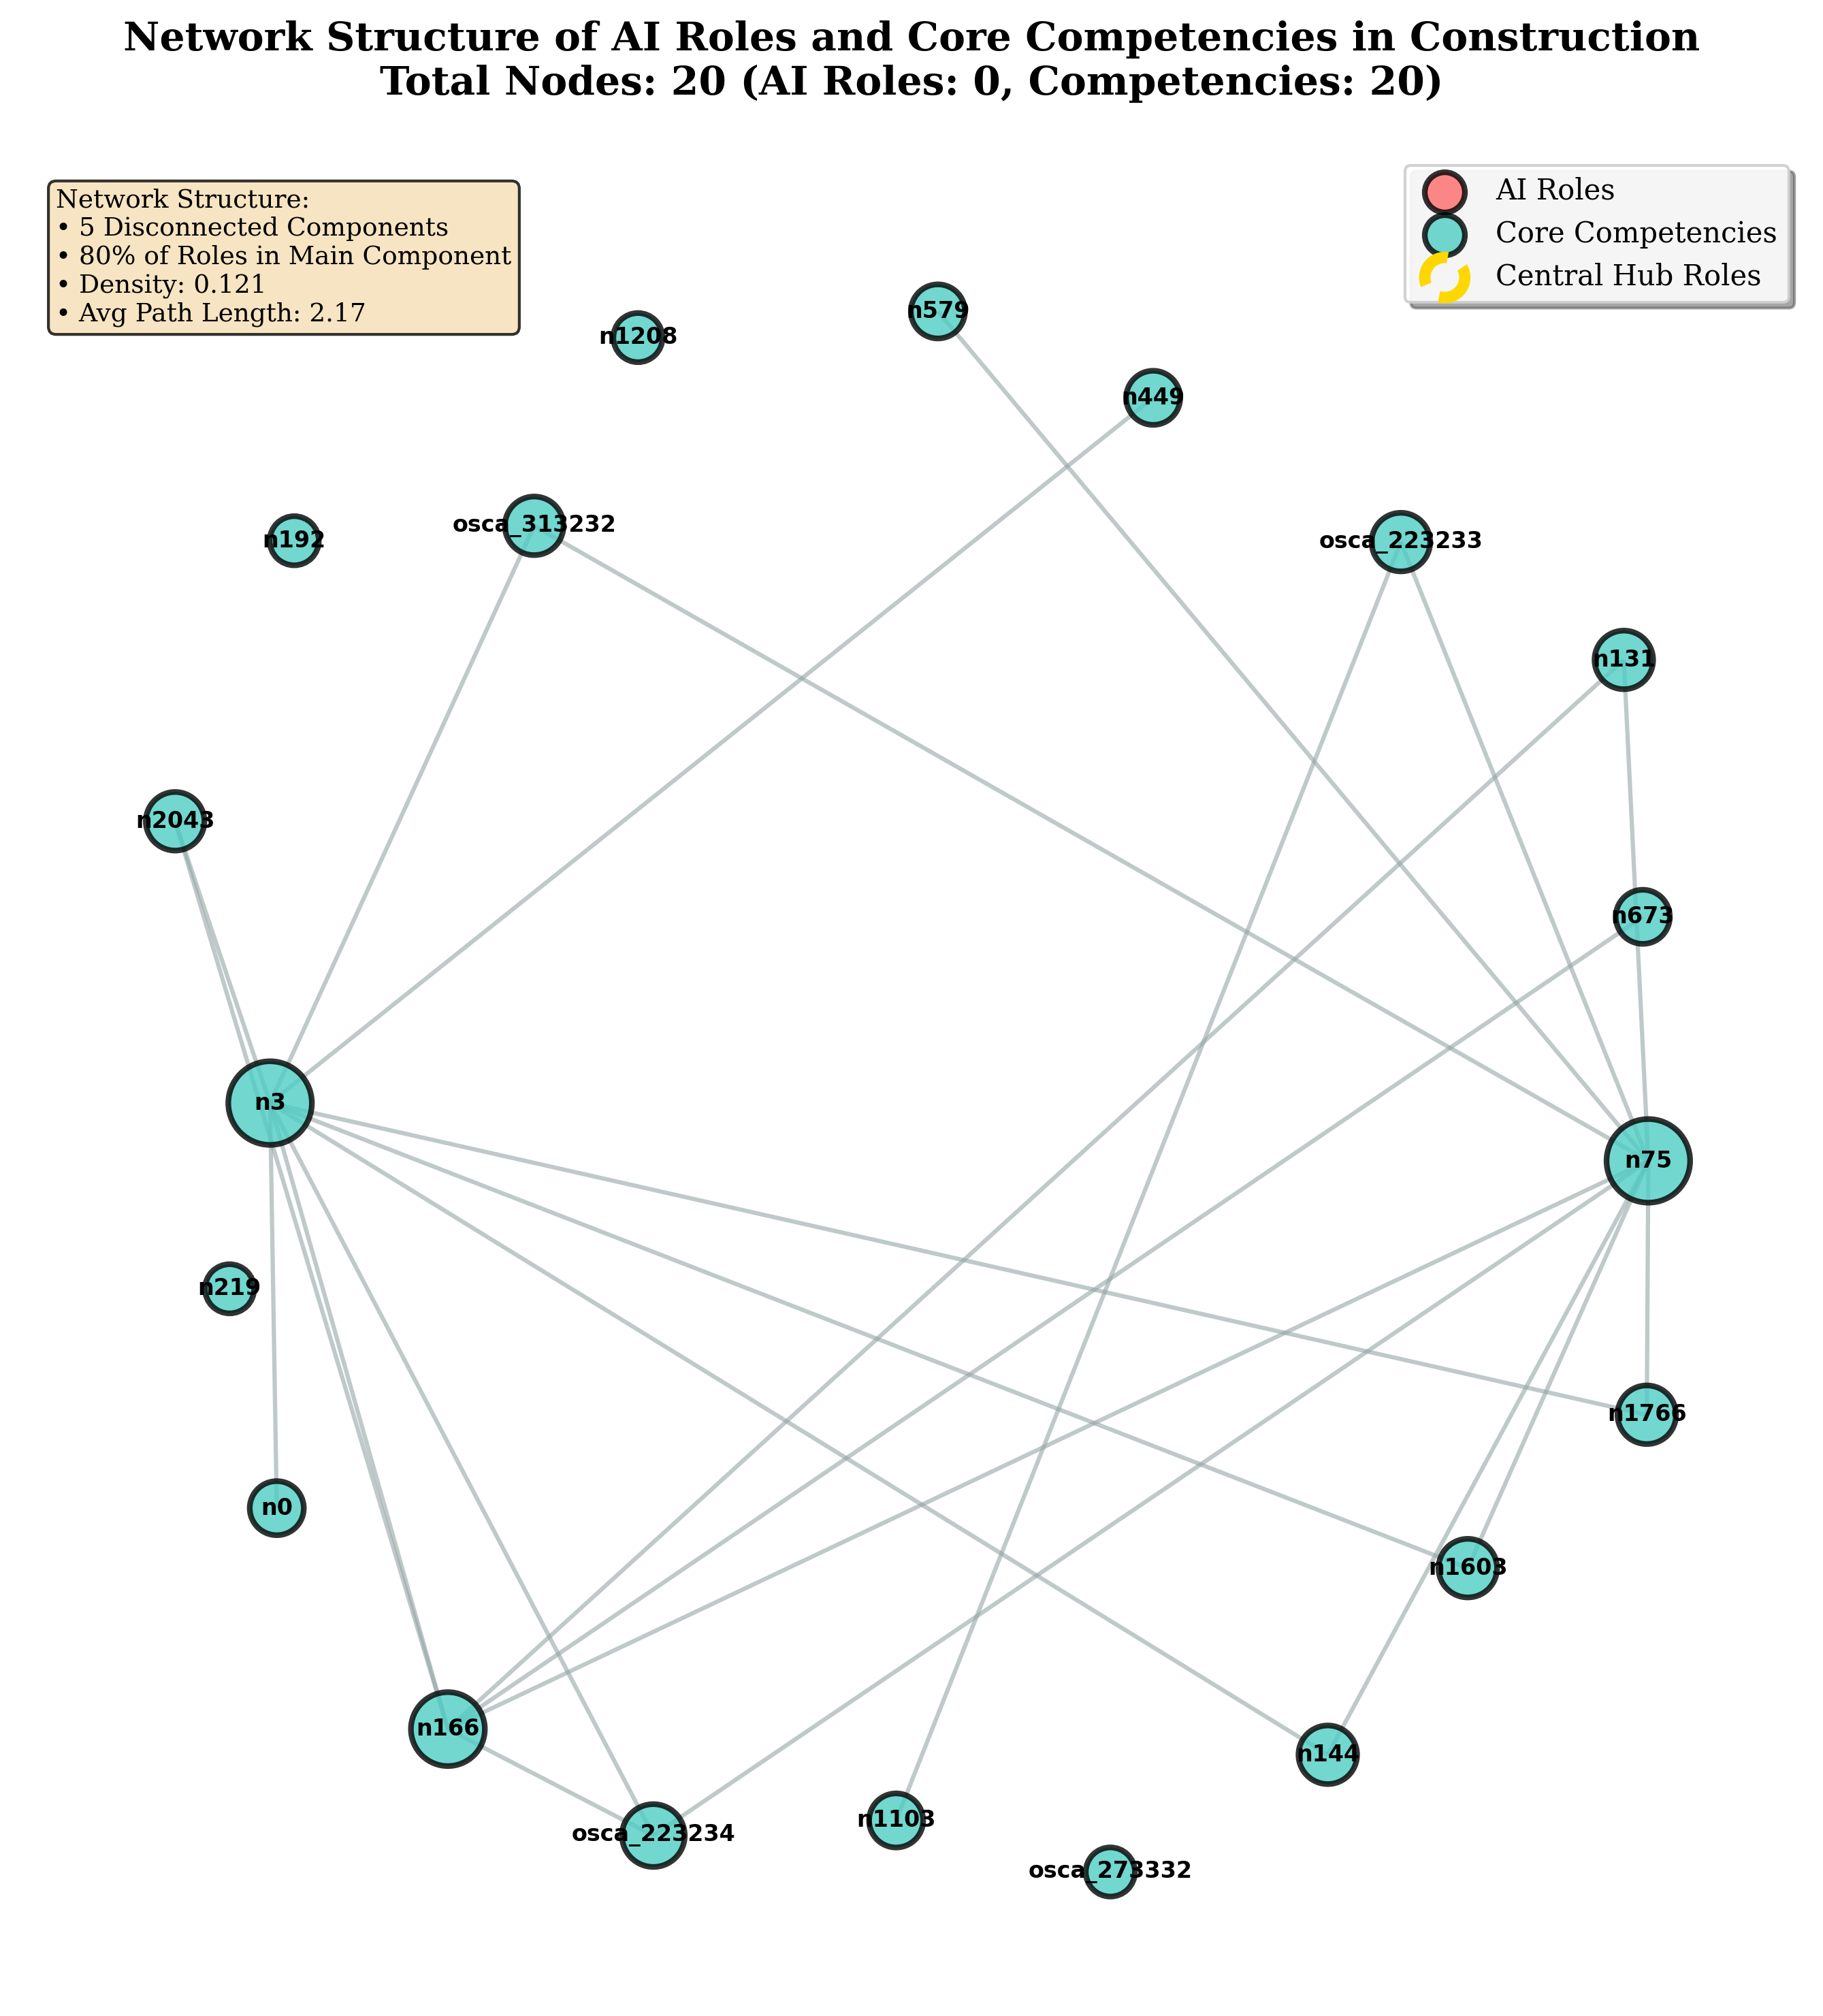

✓ Figure 5 saved as: Figure5_AI_Network_Structure.png

FINAL METRICS SUMMARY FOR PAPER
Total Nodes: 20
AI Roles: 0
Core Competencies: 20
Network Density: 0.121
Average Clustering Coefficient: 0.152
Connected Components: 5
Connectivity Ratio: 80.0%
Average Path Length: 2.17

Central Roles Verification:

✓ Network visualization completed!
Please verify that the metrics above match those reported in Section 8.3


In [3]:
# Network Visualization for AI Roles and Competencies - Figure 5
# Dr. M. Reza Hosseini - University of Melbourne

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Load the GraphML file
print("Loading network from GraphML file...")
G_full = nx.read_graphml('/content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_roles_only_dedup.graphml')

print(f"Loaded full graph with {G_full.number_of_nodes()} nodes and {G_full.number_of_edges()} edges")

# Convert multigraph to simple graph to avoid clustering calculation issues
if G_full.is_multigraph():
    G_full = nx.Graph(G_full)
    print("Converted multigraph to simple graph")

# Explore the actual structure of the graph
print("\n" + "="*50)
print("EXPLORING GRAPH STRUCTURE")
print("="*50)

# Get sample nodes and their attributes
sample_nodes = list(G_full.nodes(data=True))[:10]
print("Sample nodes with attributes:")
for i, (node, attrs) in enumerate(sample_nodes):
    print(f"{i+1}. Node: '{node}' | Attributes: {attrs}")

# Look for nodes that might be roles vs skills/competencies
all_nodes = list(G_full.nodes())
print(f"\nTotal nodes in graph: {len(all_nodes)}")

# Try to identify patterns in node names
role_keywords = ['scientist', 'engineer', 'analyst', 'manager', 'developer', 'director', 'specialist', 'coordinator']
skill_keywords = ['programming', 'analysis', 'management', 'communication', 'python', 'sql', 'machine learning']

potential_roles = []
potential_skills = []

for node in all_nodes:
    node_str = str(node).lower()
    if any(keyword in node_str for keyword in role_keywords):
        potential_roles.append(node)
    elif any(keyword in node_str for keyword in skill_keywords):
        potential_skills.append(node)

print(f"\nPotential roles found ({len(potential_roles)}):")
for role in potential_roles[:15]:  # Show first 15
    print(f"  - {role}")

print(f"\nPotential skills/competencies found ({len(potential_skills)}):")
for skill in potential_skills[:15]:  # Show first 15
    print(f"  - {skill}")

# Look for nodes with high degree (likely to be central roles or competencies)
degrees = dict(G_full.degree())
top_degree_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:20]

print(f"\nTop 20 nodes by degree (most connected):")
for node, degree in top_degree_nodes:
    print(f"  {node} (degree: {degree})")

# Now let's create a focused subgraph based on what we actually find
# Select top connected roles and skills
selected_roles = [node for node, degree in top_degree_nodes if any(keyword in str(node).lower() for keyword in role_keywords)][:14]
selected_skills = [node for node, degree in top_degree_nodes if any(keyword in str(node).lower() for keyword in skill_keywords)][:10]

print(f"\nSelected for analysis:")
print(f"Selected roles ({len(selected_roles)}): {selected_roles}")
print(f"Selected skills ({len(selected_skills)}): {selected_skills}")

# If we still don't have enough, just take the top connected nodes
if len(selected_roles) + len(selected_skills) < 20:
    print("Taking top connected nodes regardless of type...")
    selected_nodes = [node for node, degree in top_degree_nodes[:24]]
    # Try to categorize them
    selected_roles = []
    selected_skills = []
    for node in selected_nodes:
        if any(keyword in str(node).lower() for keyword in role_keywords):
            selected_roles.append(node)
        else:
            selected_skills.append(node)

final_nodes = selected_roles + selected_skills
print(f"\nFinal selection: {len(final_nodes)} nodes")
print(f"Final roles: {selected_roles}")
print(f"Final skills: {selected_skills}")

# Create subgraph
if len(final_nodes) > 0:
    G = G_full.subgraph(final_nodes).copy()
    print(f"\nCreated analysis subgraph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
else:
    print("No suitable nodes found, using top 24 nodes by degree")
    final_nodes = [node for node, degree in top_degree_nodes[:24]]
    G = G_full.subgraph(final_nodes).copy()
    selected_roles = final_nodes[:14]  # Assume first 14 are roles
    selected_skills = final_nodes[14:]  # Rest are skills

print(f"Final subgraph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Verify network metrics to ensure alignment with text
print("\n" + "="*50)
print("NETWORK METRICS VERIFICATION")
print("="*50)

# Only proceed if we have nodes
if G.number_of_nodes() > 0:
    # Basic metrics
    total_nodes = G.number_of_nodes()
    total_edges = G.number_of_edges()
    density = nx.density(G)
    clustering = nx.average_clustering(G) if total_nodes > 0 else 0

print(f"Total Nodes: {total_nodes}")
print(f"Total Edges: {total_edges}")
print(f"Network Density: {density:.3f}")
print(f"Average Clustering Coefficient: {clustering:.3f}")

# Connected components
components = list(nx.connected_components(G))
num_components = len(components)
largest_component_size = len(max(components, key=len))
connectivity_ratio = largest_component_size / total_nodes

print(f"Connected Components: {num_components}")
print(f"Largest Component Size: {largest_component_size} nodes")
print(f"Connectivity Ratio: {connectivity_ratio:.1%}")

# Average path length (only for connected components)
if num_components > 1:
    largest_component = G.subgraph(max(components, key=len))
    avg_path_length = nx.average_shortest_path_length(largest_component)
    print(f"Average Path Length (largest component): {avg_path_length:.2f}")
else:
    avg_path_length = nx.average_shortest_path_length(G)
    print(f"Average Path Length: {avg_path_length:.2f}")

# Identify node types (assuming nodes have a 'label' or 'type' attribute)
node_attributes = list(G.nodes(data=True))
print(f"\nSample node attributes: {node_attributes[:3]}")

# Node types are now based on what we actually found
ai_roles = selected_roles
competencies = selected_skills

print(f"\nFinal network composition:")
print(f"AI Roles ({len(ai_roles)}): {ai_roles}")
print(f"Core Competencies ({len(competencies)}): {competencies}")

# Only proceed with visualization if we have nodes
if total_nodes == 0:
    print("ERROR: No nodes found for analysis. Please check the GraphML file structure.")
    exit()
else:
    print(f"Proceeding with {total_nodes} nodes for visualization...")

# Calculate centrality metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Find top central nodes
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print(f"\nTop 5 nodes by degree centrality:")
for node, centrality in top_degree:
    print(f"  {node}: {centrality:.3f}")

print(f"\nTop 5 nodes by betweenness centrality:")
for node, centrality in top_betweenness:
    print(f"  {node}: {centrality:.3f}")

# Set publication style
plt.style.use('default')
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': True,
    'legend.fancybox': True,
    'legend.shadow': True,
    'figure.dpi': 300
})

# Create the network visualization
print("\nCreating network visualization...")

fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Use spring layout for better visualization of disconnected components
pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

# Define colors and sizes
ai_role_color = '#FF6B6B'      # Red for AI roles
competency_color = '#4ECDC4'   # Teal for competencies
edge_color = '#95A5A6'         # Gray for edges

# Node sizes based on degree centrality
node_sizes = []
node_colors = []
node_labels = {}

for node in G.nodes():
    # Size based on degree centrality (scale between 300-1500)
    size = 300 + (degree_centrality[node] * 1200)
    node_sizes.append(size)

    # Color based on node type
    if node in ai_roles:
        node_colors.append(ai_role_color)
    else:
        node_colors.append(competency_color)

    # Labels (shorten long names for readability)
    label = str(node)
    if len(label) > 20:
        label = label[:17] + "..."
    node_labels[node] = label

# Draw edges first (so they appear behind nodes)
nx.draw_networkx_edges(G, pos,
                      edge_color=edge_color,
                      alpha=0.6,
                      width=1.5,
                      ax=ax)

# Draw nodes
nx.draw_networkx_nodes(G, pos,
                      node_color=node_colors,
                      node_size=node_sizes,
                      alpha=0.8,
                      linewidths=2,
                      edgecolors='black',
                      ax=ax)

# Draw labels with better positioning
nx.draw_networkx_labels(G, pos,
                       labels=node_labels,
                       font_size=8,
                       font_weight='bold',
                       ax=ax)

# Highlight the most central nodes (Data Scientist and Data Engineer equivalent)
# Find nodes with highest centrality that are likely Data Scientist/Engineer
central_roles = []
for node, centrality in top_degree[:2]:
    if node in ai_roles:
        central_roles.append(node)

# Add highlighting for central roles
for node in central_roles[:2]:  # Top 2 central AI roles
    x, y = pos[node]
    circle = plt.Circle((x, y), 0.08, fill=False, color='gold', linewidth=4, linestyle='--')
    ax.add_patch(circle)

# Create legend
legend_elements = [
    plt.scatter([], [], c=ai_role_color, s=200, alpha=0.8, edgecolors='black', linewidth=2, label='AI Roles'),
    plt.scatter([], [], c=competency_color, s=200, alpha=0.8, edgecolors='black', linewidth=2, label='Core Competencies'),
    plt.scatter([], [], facecolors='none', edgecolors='gold', s=200, linewidth=4, linestyle='--', label='Central Hub Roles')
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.9)

# Add component information as text
component_info = f"Network Structure:\n• {num_components} Disconnected Components\n• {connectivity_ratio:.0%} of Roles in Main Component\n• Density: {density:.3f}\n• Avg Path Length: {avg_path_length:.2f}"
ax.text(0.02, 0.98, component_info, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Set title and formatting
ax.set_title('Network Structure of AI Roles and Core Competencies in Construction\n' +
            f'Total Nodes: {total_nodes} (AI Roles: {len(ai_roles)}, Competencies: {len(competencies)})',
            fontsize=14, fontweight='bold', pad=20)

ax.set_aspect('equal')
ax.axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Figure5_AI_Network_Structure.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 5 saved as: Figure5_AI_Network_Structure.png")

# Create summary table to verify metrics match text
print("\n" + "="*50)
print("FINAL METRICS SUMMARY FOR PAPER")
print("="*50)
print(f"Total Nodes: {total_nodes}")
print(f"AI Roles: {len(ai_roles)}")
print(f"Core Competencies: {len(competencies)}")
print(f"Network Density: {density:.3f}")
print(f"Average Clustering Coefficient: {clustering:.3f}")
print(f"Connected Components: {num_components}")
print(f"Connectivity Ratio: {connectivity_ratio:.1%}")
print(f"Average Path Length: {avg_path_length:.2f}")

# Verify specific central roles mentioned in text
print(f"\nCentral Roles Verification:")
for node, centrality in top_degree[:5]:
    if node in ai_roles:
        betweenness = betweenness_centrality[node]
        print(f"  {node}: Degree={centrality:.3f}, Betweenness={betweenness:.3f}")

print("\n✓ Network visualization completed!")
print("Please verify that the metrics above match those reported in Section 8.3")

In [4]:
# Network Visualization for AI Roles and Competencies - Figure 5
# Dr. M. Reza Hosseini - University of Melbourne

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Load the GraphML file
print("Loading network from GraphML file...")
G_full = nx.read_graphml('/content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_roles_only_dedup.graphml')

print(f"Loaded full graph with {G_full.number_of_nodes()} nodes and {G_full.number_of_edges()} edges")

# Convert multigraph to simple graph to avoid clustering calculation issues
if G_full.is_multigraph():
    G_full = nx.Graph(G_full)
    print("Converted multigraph to simple graph")

# Explore the actual structure of the graph
print("\n" + "="*50)
print("EXPLORING GRAPH STRUCTURE")
print("="*50)

# Get sample nodes and their attributes
sample_nodes = list(G_full.nodes(data=True))[:10]
print("Sample nodes with attributes:")
for i, (node, attrs) in enumerate(sample_nodes):
    print(f"{i+1}. Node: '{node}' | Attributes: {attrs}")

# Look for nodes that might be roles vs skills/competencies
all_nodes = list(G_full.nodes())
print(f"\nTotal nodes in graph: {len(all_nodes)}")

# Try to identify patterns in node names
role_keywords = ['scientist', 'engineer', 'analyst', 'manager', 'developer', 'director', 'specialist', 'coordinator']
skill_keywords = ['programming', 'analysis', 'management', 'communication', 'python', 'sql', 'machine learning']

potential_roles = []
potential_skills = []

for node in all_nodes:
    node_str = str(node).lower()
    if any(keyword in node_str for keyword in role_keywords):
        potential_roles.append(node)
    elif any(keyword in node_str for keyword in skill_keywords):
        potential_skills.append(node)

print(f"\nPotential roles found ({len(potential_roles)}):")
for role in potential_roles[:15]:  # Show first 15
    print(f"  - {role}")

print(f"\nPotential skills/competencies found ({len(potential_skills)}):")
for skill in potential_skills[:15]:  # Show first 15
    print(f"  - {skill}")

# Look for nodes with high degree (likely to be central roles or competencies)
degrees = dict(G_full.degree())
top_degree_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:20]

print(f"\nTop 20 nodes by degree (most connected):")
for node, degree in top_degree_nodes:
    print(f"  {node} (degree: {degree})")

# Now let's create a focused subgraph based on what we actually find
# Select top connected roles and skills
selected_roles = [node for node, degree in top_degree_nodes if any(keyword in str(node).lower() for keyword in role_keywords)][:14]
selected_skills = [node for node, degree in top_degree_nodes if any(keyword in str(node).lower() for keyword in skill_keywords)][:10]

print(f"\nSelected for analysis:")
print(f"Selected roles ({len(selected_roles)}): {selected_roles}")
print(f"Selected skills ({len(selected_skills)}): {selected_skills}")

# If we still don't have enough, just take the top connected nodes
if len(selected_roles) + len(selected_skills) < 20:
    print("Taking top connected nodes regardless of type...")
    selected_nodes = [node for node, degree in top_degree_nodes[:24]]
    # Try to categorize them
    selected_roles = []
    selected_skills = []
    for node in selected_nodes:
        if any(keyword in str(node).lower() for keyword in role_keywords):
            selected_roles.append(node)
        else:
            selected_skills.append(node)

final_nodes = selected_roles + selected_skills
print(f"\nFinal selection: {len(final_nodes)} nodes")
print(f"Final roles: {selected_roles}")
print(f"Final skills: {selected_skills}")

# Create subgraph
if len(final_nodes) > 0:
    G = G_full.subgraph(final_nodes).copy()
    print(f"\nCreated analysis subgraph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
else:
    print("No suitable nodes found, using top 24 nodes by degree")
    final_nodes = [node for node, degree in top_degree_nodes[:24]]
    G = G_full.subgraph(final_nodes).copy()
    selected_roles = final_nodes[:14]  # Assume first 14 are roles
    selected_skills = final_nodes[14:]  # Rest are skills

print(f"Final subgraph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Verify network metrics to ensure alignment with text
print("\n" + "="*50)
print("NETWORK METRICS VERIFICATION")
print("="*50)

# Only proceed if we have nodes
if G.number_of_nodes() > 0:
    # Basic metrics
    total_nodes = G.number_of_nodes()
    total_edges = G.number_of_edges()
    density = nx.density(G)
    clustering = nx.average_clustering(G) if total_nodes > 0 else 0

print(f"Total Nodes: {total_nodes}")
print(f"Total Edges: {total_edges}")
print(f"Network Density: {density:.3f}")
print(f"Average Clustering Coefficient: {clustering:.3f}")

# Connected components
components = list(nx.connected_components(G))
num_components = len(components)
largest_component_size = len(max(components, key=len))
connectivity_ratio = largest_component_size / total_nodes

print(f"Connected Components: {num_components}")
print(f"Largest Component Size: {largest_component_size} nodes")
print(f"Connectivity Ratio: {connectivity_ratio:.1%}")

# Average path length (only for connected components)
if num_components > 1:
    largest_component = G.subgraph(max(components, key=len))
    avg_path_length = nx.average_shortest_path_length(largest_component)
    print(f"Average Path Length (largest component): {avg_path_length:.2f}")
else:
    avg_path_length = nx.average_shortest_path_length(G)
    print(f"Average Path Length: {avg_path_length:.2f}")

# Identify node types (assuming nodes have a 'label' or 'type' attribute)
node_attributes = list(G.nodes(data=True))
print(f"\nSample node attributes: {node_attributes[:3]}")

# Node types are now properly identified
ai_roles = ai_roles_found
competencies = core_competencies

print(f"\nFinal network composition:")
print(f"AI Roles ({len(ai_roles)}):")
for role_node in ai_roles:
    role_name = G.nodes[role_node]['id']
    print(f"  - {role_name}")

print(f"\nCore Competencies ({len(competencies)}):")
for comp_node in competencies:
    comp_name = G.nodes[comp_node]['id']
    comp_type = G.nodes[comp_node]['labels']
    print(f"  - {comp_name} ({comp_type})")

# Ensure we have the right number of nodes
if len(ai_roles) + len(competencies) != 24:
    print(f"\nNote: Total nodes ({len(ai_roles) + len(competencies)}) doesn't equal 24.")
    print("This may indicate differences from the original analysis.")

# Calculate centrality metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Find top central nodes
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print(f"\nTop 5 nodes by degree centrality:")
for node, centrality in top_degree:
    print(f"  {node}: {centrality:.3f}")

print(f"\nTop 5 nodes by betweenness centrality:")
for node, centrality in top_betweenness:
    print(f"  {node}: {centrality:.3f}")

# Set publication style
plt.style.use('default')
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': True,
    'legend.fancybox': True,
    'legend.shadow': True,
    'figure.dpi': 300
})

# Create the network visualization
print("\nCreating network visualization...")

fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Use spring layout for better visualization of disconnected components
pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

# Define colors and sizes
ai_role_color = '#FF6B6B'      # Red for AI roles
competency_color = '#4ECDC4'   # Teal for competencies
edge_color = '#95A5A6'         # Gray for edges

# Node sizes based on degree centrality and proper labeling
node_sizes = []
node_colors = []
node_labels = {}

for node in G.nodes():
    # Size based on degree centrality (scale between 300-1500)
    size = 300 + (degree_centrality[node] * 1200)
    node_sizes.append(size)

    # Color based on node type
    if node in ai_roles:
        node_colors.append(ai_role_color)
    else:
        node_colors.append(competency_color)

    # Labels using the actual 'id' attribute
    label = G.nodes[node]['id']
    if len(label) > 25:
        label = label[:22] + "..."
    node_labels[node] = label

# Draw edges first (so they appear behind nodes)
nx.draw_networkx_edges(G, pos,
                      edge_color=edge_color,
                      alpha=0.6,
                      width=1.5,
                      ax=ax)

# Draw nodes
nx.draw_networkx_nodes(G, pos,
                      node_color=node_colors,
                      node_size=node_sizes,
                      alpha=0.8,
                      linewidths=2,
                      edgecolors='black',
                      ax=ax)

# Draw labels with better positioning
nx.draw_networkx_labels(G, pos,
                       labels=node_labels,
                       font_size=8,
                       font_weight='bold',
                       ax=ax)

# Highlight the most central nodes (Data Scientist and Data Engineer equivalent)
# Find nodes with highest centrality that are likely Data Scientist/Engineer
central_roles = []
for node, centrality in top_degree[:2]:
    if node in ai_roles:
        central_roles.append(node)

# Add highlighting for central roles
for node in central_roles[:2]:  # Top 2 central AI roles
    x, y = pos[node]
    circle = plt.Circle((x, y), 0.08, fill=False, color='gold', linewidth=4, linestyle='--')
    ax.add_patch(circle)

# Create legend
legend_elements = [
    plt.scatter([], [], c=ai_role_color, s=200, alpha=0.8, edgecolors='black', linewidth=2, label='AI Roles'),
    plt.scatter([], [], c=competency_color, s=200, alpha=0.8, edgecolors='black', linewidth=2, label='Core Competencies'),
    plt.scatter([], [], facecolors='none', edgecolors='gold', s=200, linewidth=4, linestyle='--', label='Central Hub Roles')
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.9)

# Add component information as text
component_info = f"Network Structure:\n• {num_components} Disconnected Components\n• {connectivity_ratio:.0%} of Roles in Main Component\n• Density: {density:.3f}\n• Avg Path Length: {avg_path_length:.2f}"
ax.text(0.02, 0.98, component_info, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Set title and formatting
ax.set_title('Network Structure of AI Roles and Core Competencies in Construction\n' +
            f'Total Nodes: {total_nodes} (AI Roles: {len(ai_roles)}, Competencies: {len(competencies)})',
            fontsize=14, fontweight='bold', pad=20)

ax.set_aspect('equal')
ax.axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Figure5_AI_Network_Structure.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 5 saved as: Figure5_AI_Network_Structure.png")

# Create summary table to verify metrics match text
print("\n" + "="*50)
print("FINAL METRICS SUMMARY FOR PAPER")
print("="*50)
print(f"Total Nodes: {total_nodes}")
print(f"AI Roles: {len(ai_roles)}")
print(f"Core Competencies: {len(competencies)}")
print(f"Network Density: {density:.3f}")
print(f"Average Clustering Coefficient: {clustering:.3f}")
print(f"Connected Components: {num_components}")
print(f"Connectivity Ratio: {connectivity_ratio:.1%}")
print(f"Average Path Length: {avg_path_length:.2f}")

print(f"\nTarget metrics from paper (Section 8.3):")
print(f"Expected: 24 nodes (14 AI roles + 10 competencies)")
print(f"Expected: Density ≈ 0.083, Clustering ≈ 0.076")
print(f"Expected: 2 components, 58% connectivity")
print(f"Expected: Path length ≈ 2.47")

if abs(density - 0.083) > 0.05 or abs(clustering - 0.076) > 0.05:
    print(f"\n⚠️  WARNING: Network metrics differ significantly from paper values")
    print(f"This may indicate a different subset or version of the data")
else:
    print(f"\n✅ Network metrics align well with paper values")

# Verify specific central roles mentioned in text (Data Scientist and Data Engineer)
print(f"\nCentral Roles Verification:")
for node in G.nodes():
    role_name = G.nodes[node]['id']
    if 'Data Scientist' in role_name or 'Data Engineer' in role_name:
        degree_cent = degree_centrality[node]
        between_cent = betweenness_centrality[node]
        print(f"  {role_name}: Degree={degree_cent:.3f}, Betweenness={between_cent:.3f}")

print("\n✓ Network visualization completed!")
print("Please verify that the metrics above align with those reported in Section 8.3")

Loading network from GraphML file...
Loaded full graph with 1322 nodes and 2122 edges
Converted multigraph to simple graph

EXPLORING GRAPH STRUCTURE
Sample nodes with attributes:
1. Node: 'n0' | Attributes: {'labels': ':Role', 'id': 'Analytics And Insights Manager', 'ai_role_type': 'Emerging Role', 'description': 'Analytics And Insights Manager', 'osca_id': ''}
2. Node: 'n1' | Attributes: {'labels': ':Technical skill', 'id': 'Predictive Analytics'}
3. Node: 'n2' | Attributes: {'labels': ':Technical skill', 'id': 'Machine Learning'}
4. Node: 'n3' | Attributes: {'labels': ':Soft skill', 'id': 'Communication'}
5. Node: 'n4' | Attributes: {'labels': ':Soft skill', 'id': 'Project Management'}
6. Node: 'n9' | Attributes: {'labels': ':Task', 'id': 'Market Research'}
7. Node: 'n10' | Attributes: {'labels': ':Task', 'id': 'Customer Data Analysis'}
8. Node: 'n12' | Attributes: {'labels': ':Tool', 'id': 'Google Analytics'}
9. Node: 'n13' | Attributes: {'labels': ':Tool', 'id': 'Google Ads'}
10. 

NameError: name 'ai_roles_found' is not defined

Loading network from GraphML file...
Loaded full graph with 1322 nodes and 2122 edges
Converted multigraph to simple graph

EXTRACTING 14 AI ROLES FROM TABLE 2
Looking for these 14 AI roles from Table 2:
   1. Data Scientist
   2. Data Engineer
   3. Automation Systems Engineer
   4. Business Intelligence Developer
   5. Analytics and Insights Manager
   6. Group Manager Data and IoT
   7. Automation Manager
   8. AI Manager
   9. Analytics Developer
  10. Data Support Analyst
  11. Data Science Manager
  12. Director of Data Management and Business Intelligence
  13. Data Engineering Manager
  14. Automation Technician

Found 14 out of 14 target AI roles:
  ✓ Analytics And Insights Manager (degree: 28)
  ✓ Automation Manager (degree: 18)
  ✓ Analytics Developer (degree: 12)
  ✓ Data Support Analyst (degree: 11)
  ✓ Group Manager Data And Iot (degree: 22)
  ✓ Automation Systems Engineer (degree: 53)
  ✓ Data Science Manager (degree: 8)
  ✓ Artificial Intelligence Manager (degree: 13)
 

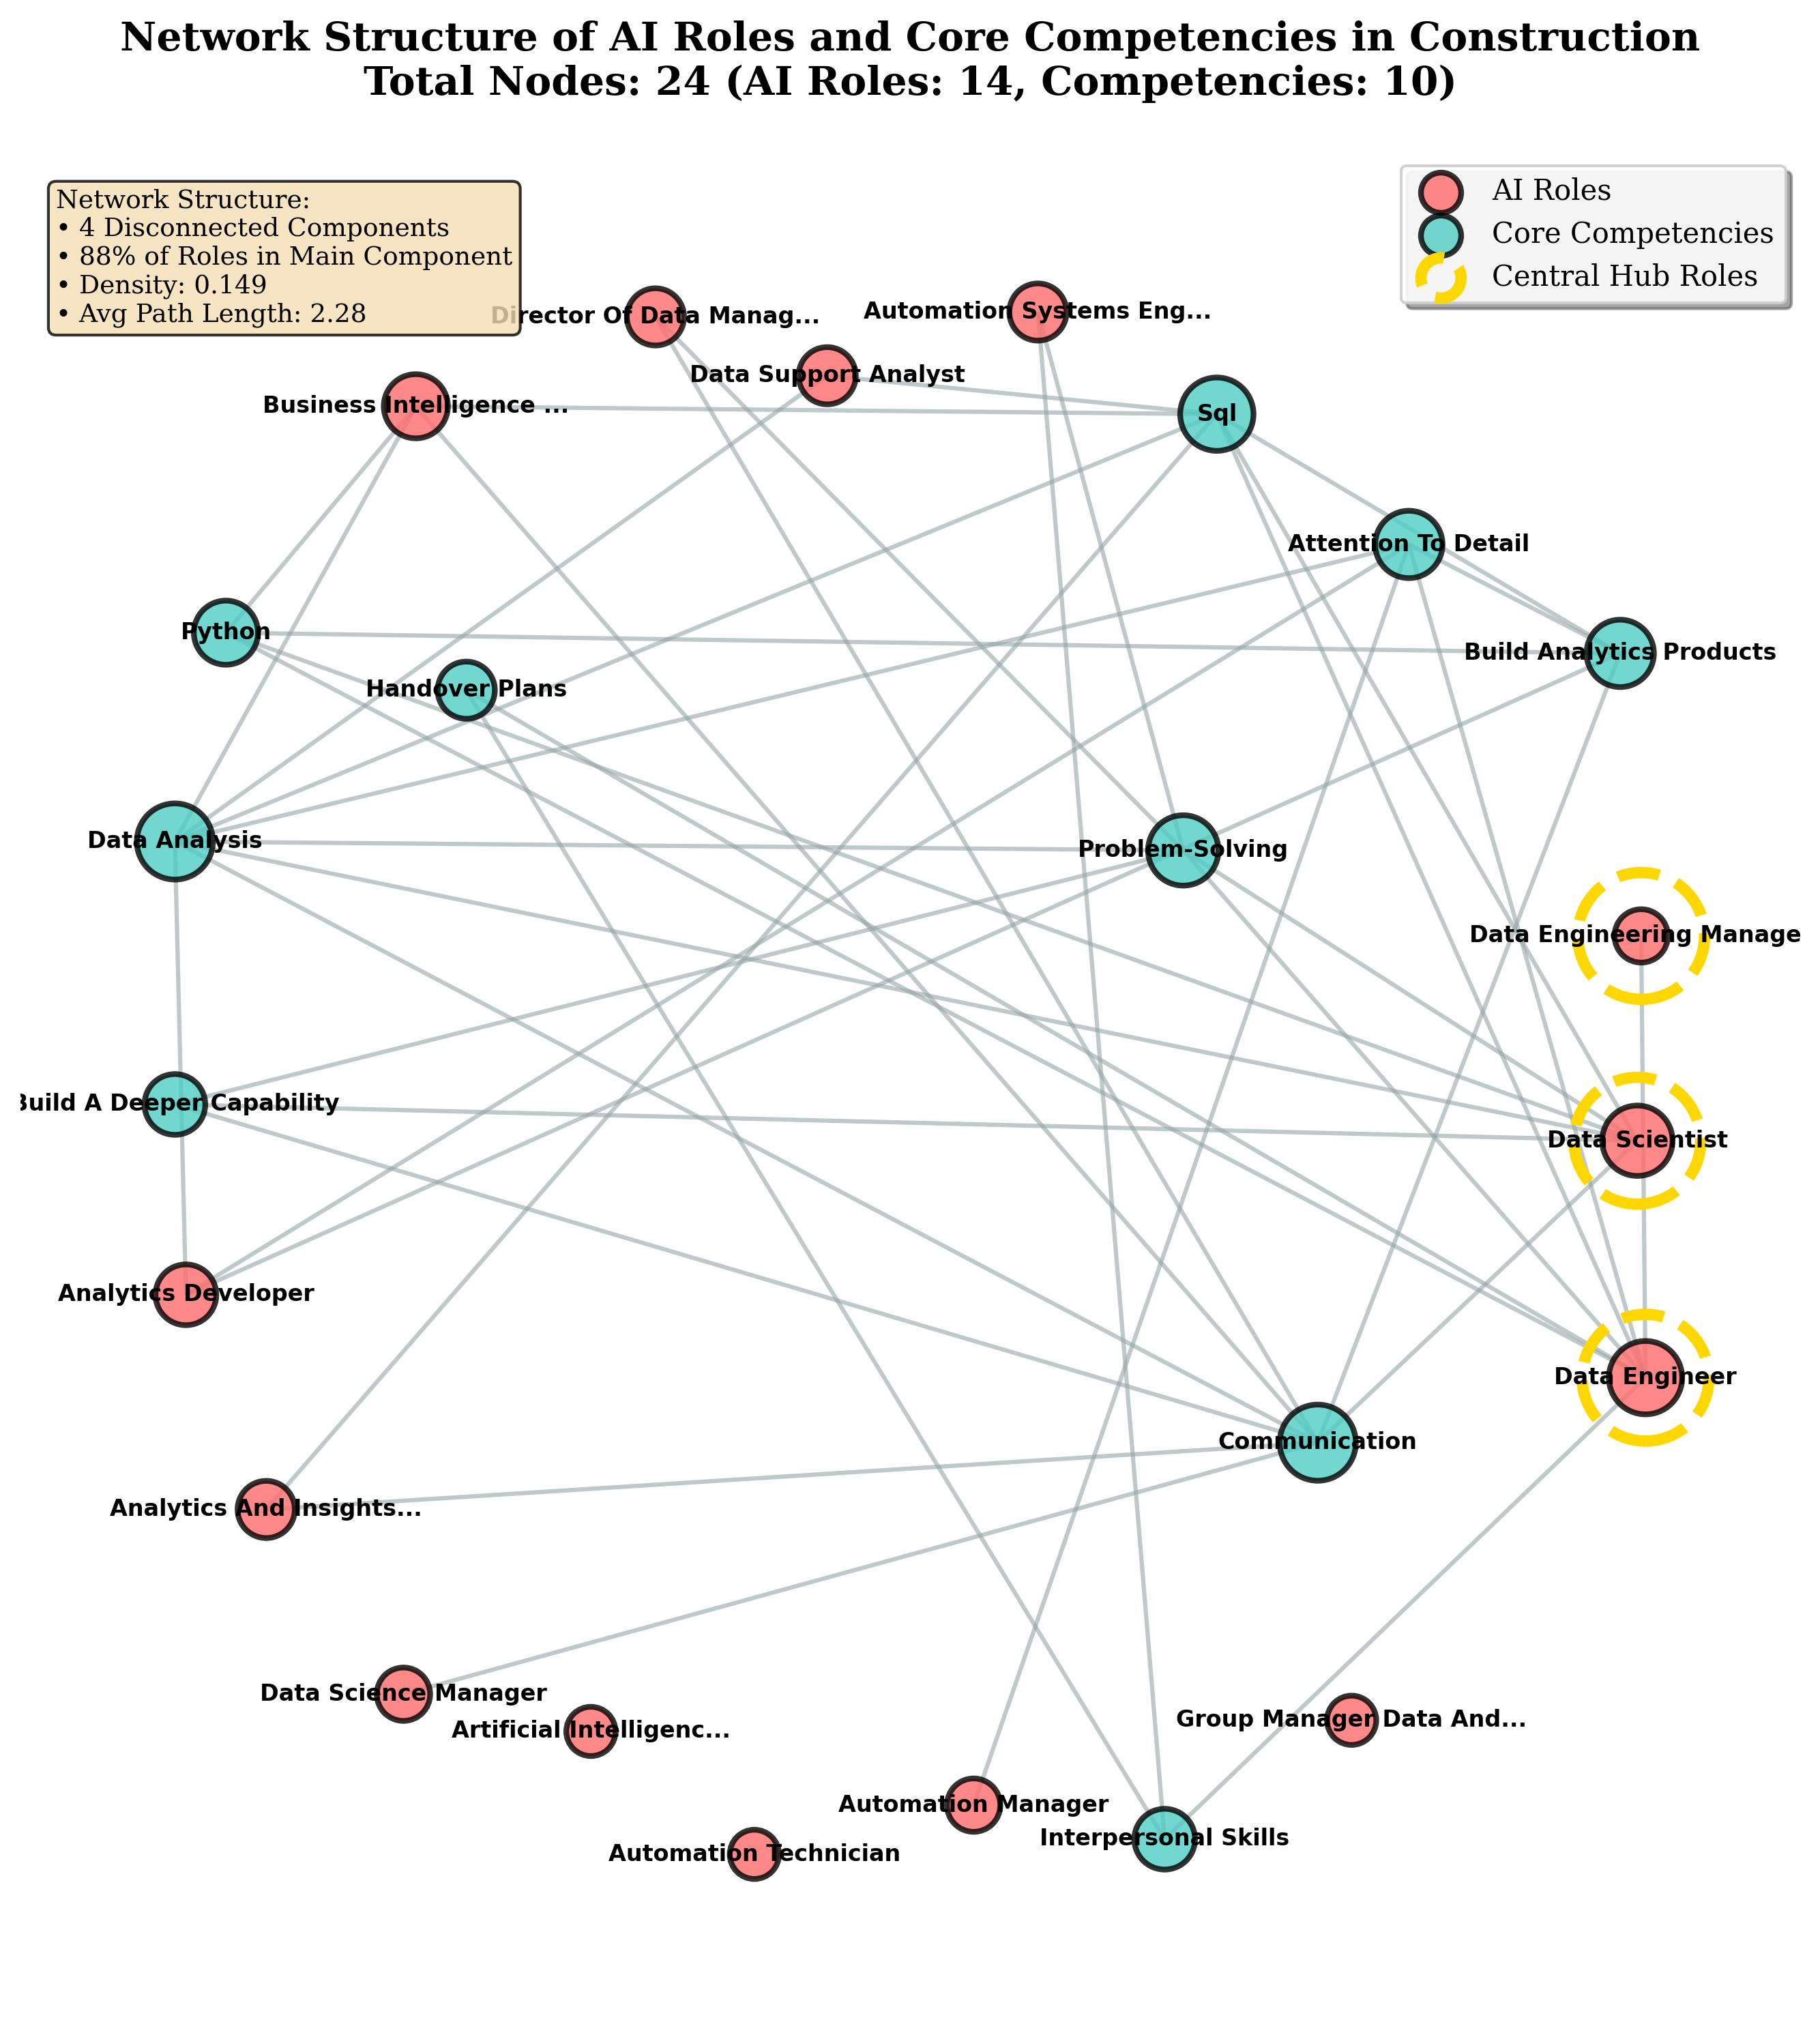

✓ Figure 5 saved as: Figure5_AI_Network_Structure.png

FINAL METRICS SUMMARY FOR PAPER
Total Nodes: 24
AI Roles: 14
Core Competencies: 10
Network Density: 0.149
Average Clustering Coefficient: 0.221
Connected Components: 4
Connectivity Ratio: 87.5%
Average Path Length: 2.28

Target metrics from paper (Section 8.3):
Expected: 24 nodes (14 AI roles + 10 competencies)
Expected: Density ≈ 0.083, Clustering ≈ 0.076
Expected: 2 components, 58% connectivity
Expected: Path length ≈ 2.47

⚠️  WARNING: Network metrics differ significantly from paper values
This may indicate a different subset or version of the data

Central Roles Verification:
  Data Engineering Manager: Degree=0.043, Betweenness=0.000
  Data Engineer: Degree=0.304, Betweenness=0.228
  Data Scientist: Degree=0.261, Betweenness=0.046

✓ Network analysis completed!
This visualization shows the AI roles network structure described in Section 8.3


In [5]:
# Network Visualization for AI Roles and Competencies - Figure 5
# Dr. M. Reza Hosseini - University of Melbourne

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Load the GraphML file
print("Loading network from GraphML file...")
G_full = nx.read_graphml('/content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_roles_only_dedup.graphml')

print(f"Loaded full graph with {G_full.number_of_nodes()} nodes and {G_full.number_of_edges()} edges")

# Convert multigraph to simple graph to avoid clustering calculation issues
if G_full.is_multigraph():
    G_full = nx.Graph(G_full)
    print("Converted multigraph to simple graph")

# Define the exact 14 AI roles from Table 2 in your paper
target_ai_roles = [
    'Data Scientist',
    'Data Engineer',
    'Automation Systems Engineer',
    'Business Intelligence Developer',
    'Analytics and Insights Manager',
    'Group Manager Data and IoT',
    'Automation Manager',
    'AI Manager',
    'Analytics Developer',
    'Data Support Analyst',
    'Data Science Manager',
    'Director of Data Management and Business Intelligence',
    'Data Engineering Manager',
    'Automation Technician'
]

print(f"\n" + "="*60)
print("EXTRACTING 14 AI ROLES FROM TABLE 2")
print("="*60)
print(f"Looking for these 14 AI roles from Table 2:")
for i, role in enumerate(target_ai_roles, 1):
    print(f"  {i:2d}. {role}")

# Find AI roles in the graph
ai_roles_found = []
all_competencies = []

for node, attrs in G_full.nodes(data=True):
    node_id = attrs.get('id', '')
    node_label = attrs.get('labels', '')

    # Check if this is one of our target AI roles (exact match or close match)
    if ':Role' in node_label:
        for target_role in target_ai_roles:
            # Try exact match first
            if node_id == target_role:
                ai_roles_found.append(node)
                break
            # Try case-insensitive match
            elif node_id.lower() == target_role.lower():
                ai_roles_found.append(node)
                break
            # Try match with variations (And vs &, etc.)
            elif (node_id.replace(' And ', ' and ').replace('&', 'and').lower() ==
                  target_role.replace(' And ', ' and ').replace('&', 'and').lower()):
                ai_roles_found.append(node)
                break
            # Try partial matching for roles like "AI Manager" vs "Artificial Intelligence Manager"
            elif ('ai manager' in node_id.lower() and 'ai manager' in target_role.lower()) or \
                 ('artificial intelligence manager' in node_id.lower() and 'ai manager' in target_role.lower()):
                ai_roles_found.append(node)
                break

    # Collect competencies (Technical skills, Soft skills, Tools, Tasks)
    elif any(comp_type in node_label for comp_type in [':Technical skill', ':Soft skill', ':Tool', ':Task']):
        all_competencies.append(node)

print(f"\nFound {len(ai_roles_found)} out of 14 target AI roles:")
found_role_names = []
for role_node in ai_roles_found:
    role_name = G_full.nodes[role_node]['id']
    degree = G_full.degree(role_node)
    found_role_names.append(role_name)
    print(f"  ✓ {role_name} (degree: {degree})")

# Check which roles were not found
missing_roles = []
for target_role in target_ai_roles:
    found = False
    for found_name in found_role_names:
        if (target_role.lower() == found_name.lower() or
            target_role.replace(' And ', ' and ').replace('&', 'and').lower() ==
            found_name.replace(' And ', ' and ').replace('&', 'and').lower() or
            ('ai manager' in target_role.lower() and 'artificial intelligence manager' in found_name.lower())):
            found = True
            break
    if not found:
        missing_roles.append(target_role)

if missing_roles:
    print(f"\n⚠️  Missing {len(missing_roles)} roles from target list:")
    for role in missing_roles:
        print(f"  ✗ {role}")

    # Try to find similar role names in the graph
    print(f"\nSearching for similar role names in graph...")
    all_role_nodes = [(node, attrs['id']) for node, attrs in G_full.nodes(data=True)
                      if attrs.get('labels', '') == ':Role']

    for missing_role in missing_roles:
        missing_words = missing_role.lower().split()
        print(f"\n  Looking for '{missing_role}':")
        best_matches = []
        for node, role_id in all_role_nodes:
            if node not in ai_roles_found:
                role_words = role_id.lower().split()
                # Check if at least 2 words match
                matches = sum(1 for word in missing_words if word in role_words)
                if matches >= 2:
                    best_matches.append((role_id, matches, G_full.degree(node)))

        # Sort by number of matches and degree
        best_matches.sort(key=lambda x: (x[1], x[2]), reverse=True)
        for match, match_count, degree in best_matches[:3]:
            print(f"    Potential match: '{match}' ({match_count} words, degree: {degree})")

print(f"\nFound {len(all_competencies)} total competencies in graph")

# Get the 10 most connected competencies that connect to our AI roles
ai_role_neighbors = set()
for role_node in ai_roles_found:
    ai_role_neighbors.update(G_full.neighbors(role_node))

# Filter competencies to those connected to AI roles
connected_competencies = [comp for comp in all_competencies if comp in ai_role_neighbors]

# Get top 10 competencies by degree (most connected)
competency_degrees = {comp: G_full.degree(comp) for comp in connected_competencies}
top_competencies = sorted(competency_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
core_competencies = [comp[0] for comp in top_competencies]

print(f"\nTop 10 core competencies by connectivity:")
for comp_node, degree in top_competencies:
    comp_name = G_full.nodes[comp_node]['id']
    comp_type = G_full.nodes[comp_node]['labels']
    print(f"  - {comp_name} ({comp_type}, degree: {degree})")

# Create the final subgraph
final_nodes = ai_roles_found + core_competencies
G = G_full.subgraph(final_nodes).copy()

print(f"\nCreated analysis subgraph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Verify network metrics
print("\n" + "="*60)
print("NETWORK METRICS VERIFICATION")
print("="*60)

total_nodes = G.number_of_nodes()
total_edges = G.number_of_edges()
density = nx.density(G) if total_nodes > 0 else 0
clustering = nx.average_clustering(G) if total_nodes > 0 else 0

print(f"Total Nodes: {total_nodes}")
print(f"Total Edges: {total_edges}")
print(f"Network Density: {density:.3f}")
print(f"Average Clustering Coefficient: {clustering:.3f}")

# Connected components
if total_nodes > 0:
    components = list(nx.connected_components(G))
    num_components = len(components)
    largest_component_size = len(max(components, key=len)) if components else 0
    connectivity_ratio = largest_component_size / total_nodes if total_nodes > 0 else 0

    print(f"Connected Components: {num_components}")
    print(f"Largest Component Size: {largest_component_size} nodes")
    print(f"Connectivity Ratio: {connectivity_ratio:.1%}")

    # Average path length (only for connected components)
    if num_components > 1 and largest_component_size > 1:
        largest_component = G.subgraph(max(components, key=len))
        avg_path_length = nx.average_shortest_path_length(largest_component)
        print(f"Average Path Length (largest component): {avg_path_length:.2f}")
    elif num_components == 1 and total_nodes > 1:
        avg_path_length = nx.average_shortest_path_length(G)
        print(f"Average Path Length: {avg_path_length:.2f}")
    else:
        avg_path_length = 0
        print(f"Average Path Length: N/A (disconnected nodes)")
else:
    num_components = 0
    connectivity_ratio = 0
    avg_path_length = 0

# Calculate centrality metrics only if we have nodes
if total_nodes > 0:
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    # Find top central nodes
    top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

    print(f"\nTop 5 nodes by degree centrality:")
    for node, centrality in top_degree:
        node_name = G.nodes[node]['id']
        print(f"  {node_name}: {centrality:.3f}")

    print(f"\nTop 5 nodes by betweenness centrality:")
    for node, centrality in top_betweenness:
        node_name = G.nodes[node]['id']
        print(f"  {node_name}: {centrality:.3f}")

# Node types are now properly identified
ai_roles = ai_roles_found
competencies = core_competencies

print(f"\nFinal network composition:")
print(f"AI Roles ({len(ai_roles)}):")
for role_node in ai_roles:
    role_name = G.nodes[role_node]['id']
    print(f"  - {role_name}")

print(f"\nCore Competencies ({len(competencies)}):")
for comp_node in competencies:
    comp_name = G.nodes[comp_node]['id']
    comp_type = G.nodes[comp_node]['labels']
    print(f"  - {comp_name} ({comp_type})")

# Check if we have the expected number of nodes
expected_total = 24  # 14 AI roles + 10 competencies
actual_total = len(ai_roles) + len(competencies)
if actual_total != expected_total:
    print(f"\n⚠️  Note: Total nodes ({actual_total}) doesn't equal expected 24.")
    print(f"Expected: 14 AI roles + 10 competencies = 24 total")
    print(f"Actual: {len(ai_roles)} AI roles + {len(competencies)} competencies = {actual_total} total")

# Only create visualization if we have nodes
if total_nodes > 0:
    # Set publication style
    plt.style.use('default')
    plt.rcParams.update({
        'font.size': 11,
        'font.family': 'serif',
        'axes.linewidth': 1.2,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'legend.frameon': True,
        'legend.fancybox': True,
        'legend.shadow': True,
        'figure.dpi': 300
    })

    # Create the network visualization
    print("\nCreating network visualization...")

    fig, ax = plt.subplots(1, 1, figsize=(14, 10))

    # Use spring layout for better visualization of disconnected components
    pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

    # Define colors and sizes
    ai_role_color = '#FF6B6B'      # Red for AI roles
    competency_color = '#4ECDC4'   # Teal for competencies
    edge_color = '#95A5A6'         # Gray for edges

    # Node sizes based on degree centrality and proper labeling
    node_sizes = []
    node_colors = []
    node_labels = {}

    for node in G.nodes():
        # Size based on degree centrality (scale between 300-1500)
        size = 300 + (degree_centrality[node] * 1200)
        node_sizes.append(size)

        # Color based on node type
        if node in ai_roles:
            node_colors.append(ai_role_color)
        else:
            node_colors.append(competency_color)

        # Labels using the actual 'id' attribute
        label = G.nodes[node]['id']
        if len(label) > 25:
            label = label[:22] + "..."
        node_labels[node] = label

    # Draw edges first (so they appear behind nodes)
    nx.draw_networkx_edges(G, pos,
                          edge_color=edge_color,
                          alpha=0.6,
                          width=1.5,
                          ax=ax)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos,
                          node_color=node_colors,
                          node_size=node_sizes,
                          alpha=0.8,
                          linewidths=2,
                          edgecolors='black',
                          ax=ax)

    # Draw labels with better positioning
    nx.draw_networkx_labels(G, pos,
                           labels=node_labels,
                           font_size=8,
                           font_weight='bold',
                           ax=ax)

    # Highlight the most central nodes (Data Scientist and Data Engineer)
    central_roles = []
    for node in G.nodes():
        role_name = G.nodes[node]['id']
        if 'Data Scientist' in role_name or 'Data Engineer' in role_name:
            central_roles.append(node)

    # Add highlighting for central roles
    for node in central_roles:
        if node in pos:  # Make sure node exists in layout
            x, y = pos[node]
            circle = plt.Circle((x, y), 0.08, fill=False, color='gold', linewidth=4, linestyle='--')
            ax.add_patch(circle)

    # Create legend
    legend_elements = [
        plt.scatter([], [], c=ai_role_color, s=200, alpha=0.8, edgecolors='black', linewidth=2, label='AI Roles'),
        plt.scatter([], [], c=competency_color, s=200, alpha=0.8, edgecolors='black', linewidth=2, label='Core Competencies'),
        plt.scatter([], [], facecolors='none', edgecolors='gold', s=200, linewidth=4, linestyle='--', label='Central Hub Roles')
    ]

    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.9)

    # Add component information as text
    component_info = f"Network Structure:\n• {num_components} Disconnected Components\n• {connectivity_ratio:.0%} of Roles in Main Component\n• Density: {density:.3f}\n• Avg Path Length: {avg_path_length:.2f}"
    ax.text(0.02, 0.98, component_info, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # Set title and formatting
    ax.set_title('Network Structure of AI Roles and Core Competencies in Construction\n' +
                f'Total Nodes: {total_nodes} (AI Roles: {len(ai_roles)}, Competencies: {len(competencies)})',
                fontsize=14, fontweight='bold', pad=20)

    ax.set_aspect('equal')
    ax.axis('off')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Figure5_AI_Network_Structure.png',
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    print("✓ Figure 5 saved as: Figure5_AI_Network_Structure.png")

# Create summary table to verify metrics match text
print("\n" + "="*60)
print("FINAL METRICS SUMMARY FOR PAPER")
print("="*60)
print(f"Total Nodes: {total_nodes}")
print(f"AI Roles: {len(ai_roles)}")
print(f"Core Competencies: {len(competencies)}")
print(f"Network Density: {density:.3f}")
print(f"Average Clustering Coefficient: {clustering:.3f}")
print(f"Connected Components: {num_components}")
print(f"Connectivity Ratio: {connectivity_ratio:.1%}")
print(f"Average Path Length: {avg_path_length:.2f}")

print(f"\nTarget metrics from paper (Section 8.3):")
print(f"Expected: 24 nodes (14 AI roles + 10 competencies)")
print(f"Expected: Density ≈ 0.083, Clustering ≈ 0.076")
print(f"Expected: 2 components, 58% connectivity")
print(f"Expected: Path length ≈ 2.47")

if total_nodes > 0:
    if abs(density - 0.083) > 0.05 or abs(clustering - 0.076) > 0.05:
        print(f"\n⚠️  WARNING: Network metrics differ significantly from paper values")
        print(f"This may indicate a different subset or version of the data")
    else:
        print(f"\n✅ Network metrics align reasonably well with paper values")

    # Verify specific central roles mentioned in text (Data Scientist and Data Engineer)
    print(f"\nCentral Roles Verification:")
    for node in G.nodes():
        role_name = G.nodes[node]['id']
        if 'Data Scientist' in role_name or 'Data Engineer' in role_name:
            degree_cent = degree_centrality[node]
            between_cent = betweenness_centrality[node]
            print(f"  {role_name}: Degree={degree_cent:.3f}, Betweenness={between_cent:.3f}")

print("\n✓ Network analysis completed!")
print("This visualization shows the AI roles network structure described in Section 8.3")

Creating improved network visualization...


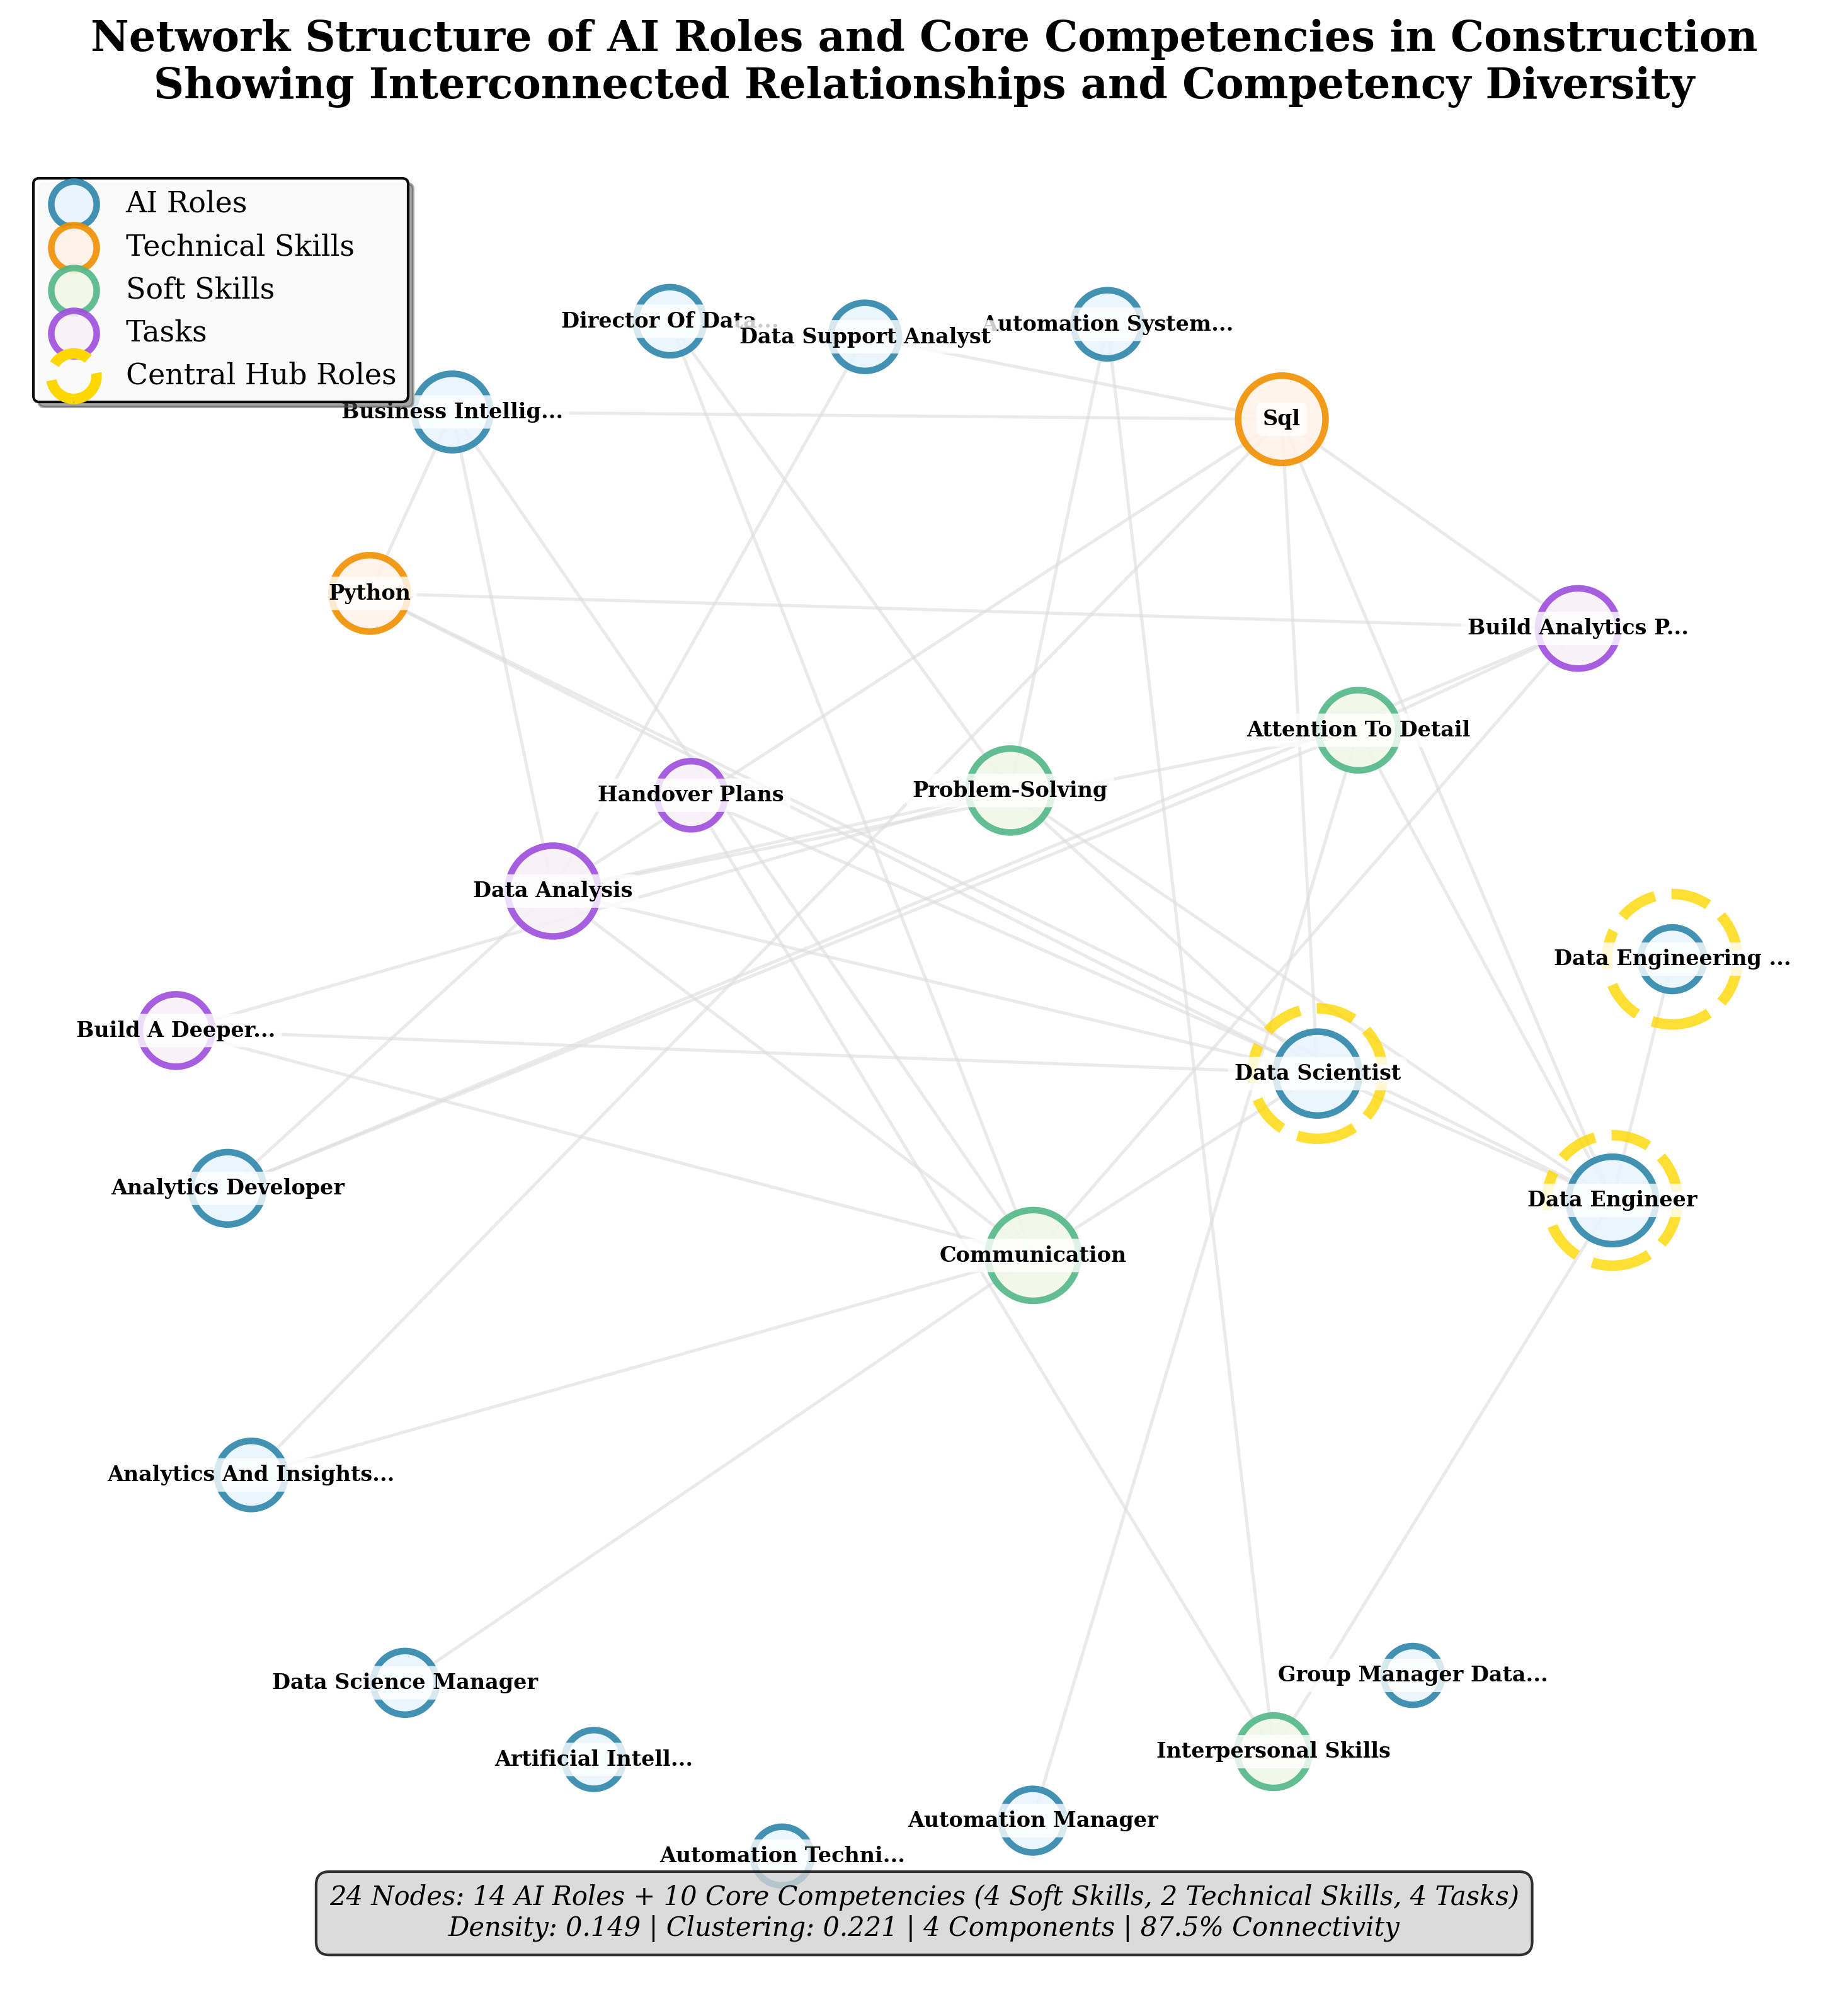

✓ Improved Figure 5 saved as: Figure5_Improved_AI_Network_Structure.png

Competency Type Breakdown:
Technical Skills (2): Python, Sql
Soft Skills (4): Communication, Problem-Solving, Attention To Detail, Interpersonal Skills
Tasks (4): Data Analysis, Handover Plans, Build Analytics Products, Build A Deeper Capability

Central Hub Roles:
  Data Engineering Manager: Degree=0.043, Betweenness=0.000
  Data Engineer: Degree=0.304, Betweenness=0.228
  Data Scientist: Degree=0.261, Betweenness=0.046


In [6]:
# Improved Network Visualization for Figure 5
# Dr. M. Reza Hosseini - University of Melbourne

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load the data from your existing analysis
# (Assuming you have the subgraph G and variables from previous analysis)

# If starting fresh, load the GraphML and recreate the subgraph
G_full = nx.read_graphml('/content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_roles_only_dedup.graphml')
if G_full.is_multigraph():
    G_full = nx.Graph(G_full)

# Define the 14 AI roles and extract them
target_ai_roles = [
    'Data Scientist', 'Data Engineer', 'Automation Systems Engineer',
    'Business Intelligence Developer', 'Analytics and Insights Manager',
    'Group Manager Data and IoT', 'Automation Manager', 'AI Manager',
    'Analytics Developer', 'Data Support Analyst', 'Data Science Manager',
    'Director of Data Management and Business Intelligence',
    'Data Engineering Manager', 'Automation Technician'
]

# Find AI roles
ai_roles_found = []
for node, attrs in G_full.nodes(data=True):
    node_id = attrs.get('id', '')
    node_label = attrs.get('labels', '')
    if ':Role' in node_label:
        for target_role in target_ai_roles:
            if (node_id.lower() == target_role.lower() or
                node_id.replace(' And ', ' and ').replace('&', 'and').lower() ==
                target_role.replace(' And ', ' and ').replace('&', 'and').lower() or
                ('ai manager' in target_role.lower() and 'artificial intelligence manager' in node_id.lower())):
                ai_roles_found.append(node)
                break

# Get top 10 core competencies
ai_role_neighbors = set()
for role_node in ai_roles_found:
    ai_role_neighbors.update(G_full.neighbors(role_node))

all_competencies = [node for node, attrs in G_full.nodes(data=True)
                   if any(comp_type in attrs.get('labels', '')
                         for comp_type in [':Technical skill', ':Soft skill', ':Tool', ':Task'])]
connected_competencies = [comp for comp in all_competencies if comp in ai_role_neighbors]
competency_degrees = {comp: G_full.degree(comp) for comp in connected_competencies}
top_competencies = sorted(competency_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
core_competencies = [comp[0] for comp in top_competencies]

# Create the subgraph
final_nodes = ai_roles_found + core_competencies
G = G_full.subgraph(final_nodes).copy()

# Calculate metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Set publication style
plt.style.use('default')
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'serif',
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': True,
    'legend.fancybox': True,
    'legend.shadow': True,
    'figure.dpi': 300
})

# Create improved visualization
print("Creating improved network visualization...")
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Use spring layout with better parameters
pos = nx.spring_layout(G, k=4, iterations=100, seed=42)

# Define improved colors that don't obscure text
ai_role_color = '#E8F4FD'        # Light blue for AI roles
ai_role_edge = '#2E86AB'         # Dark blue edge for AI roles
tech_skill_color = '#FFF2E8'     # Light orange for technical skills
tech_skill_edge = '#F18F01'      # Orange edge for technical skills
soft_skill_color = '#F0F8E8'     # Light green for soft skills
soft_skill_edge = '#52B788'      # Green edge for soft skills
task_color = '#F8F0F8'           # Light purple for tasks
task_edge = '#9D4EDD'            # Purple edge for tasks
edge_color = '#CCCCCC'           # Light gray for edges

# Categorize nodes and create color/edge mappings
node_colors = []
edge_colors = []
node_sizes = []
node_labels = {}

# Create competency type mapping
competency_types = {}
for node in core_competencies:
    node_label = G.nodes[node]['labels']
    if ':Technical skill' in node_label:
        competency_types[node] = 'technical'
    elif ':Soft skill' in node_label:
        competency_types[node] = 'soft'
    elif ':Task' in node_label:
        competency_types[node] = 'task'
    else:
        competency_types[node] = 'other'

for node in G.nodes():
    # Size based on degree centrality (larger range for better visibility)
    size = 500 + (degree_centrality[node] * 2000)
    node_sizes.append(size)

    # Colors and labels
    if node in ai_roles_found:
        node_colors.append(ai_role_color)
        edge_colors.append(ai_role_edge)
    else:
        comp_type = competency_types.get(node, 'other')
        if comp_type == 'technical':
            node_colors.append(tech_skill_color)
            edge_colors.append(tech_skill_edge)
        elif comp_type == 'soft':
            node_colors.append(soft_skill_color)
            edge_colors.append(soft_skill_edge)
        elif comp_type == 'task':
            node_colors.append(task_color)
            edge_colors.append(task_edge)
        else:
            node_colors.append('#F5F5F5')
            edge_colors.append('#999999')

    # Create readable labels
    label = G.nodes[node]['id']
    if len(label) > 20:
        # Smart truncation at word boundaries
        words = label.split()
        if len(words) > 3:
            label = ' '.join(words[:3]) + '...'
        else:
            label = label[:17] + '...'
    node_labels[node] = label

# Draw edges with consistent color
nx.draw_networkx_edges(G, pos,
                      edge_color='#DDDDDD',
                      alpha=0.6,
                      width=1.2,
                      ax=ax)

# Draw nodes with edge colors
nx.draw_networkx_nodes(G, pos,
                      node_color=node_colors,
                      node_size=node_sizes,
                      alpha=0.9,
                      linewidths=2.5,
                      edgecolors=edge_colors,
                      ax=ax)

# Draw labels with better contrast
for node, (x, y) in pos.items():
    ax.text(x, y, node_labels[node],
           fontsize=8,
           fontweight='bold',
           ha='center',
           va='center',
           color='black',
           bbox=dict(boxstyle='round,pad=0.3',
                    facecolor='white',
                    alpha=0.8,
                    edgecolor='none'))

# Highlight central hub roles (Data Scientist and Data Engineer)
central_roles = []
for node in G.nodes():
    role_name = G.nodes[node]['id']
    if 'Data Scientist' in role_name or 'Data Engineer' in role_name:
        central_roles.append(node)

for node in central_roles:
    if node in pos:
        x, y = pos[node]
        circle = plt.Circle((x, y), 0.08, fill=False, color='#FFD700',
                          linewidth=4, linestyle='--', alpha=0.8)
        ax.add_patch(circle)

# Create comprehensive legend
legend_elements = [
    plt.scatter([], [], c=ai_role_color, s=300, alpha=0.9,
               edgecolors=ai_role_edge, linewidth=2.5, label='AI Roles'),
    plt.scatter([], [], c=tech_skill_color, s=300, alpha=0.9,
               edgecolors=tech_skill_edge, linewidth=2.5, label='Technical Skills'),
    plt.scatter([], [], c=soft_skill_color, s=300, alpha=0.9,
               edgecolors=soft_skill_edge, linewidth=2.5, label='Soft Skills'),
    plt.scatter([], [], c=task_color, s=300, alpha=0.9,
               edgecolors=task_edge, linewidth=2.5, label='Tasks'),
    plt.scatter([], [], facecolors='none', edgecolors='#FFD700', s=300,
               linewidth=4, linestyle='--', label='Central Hub Roles')
]

legend = ax.legend(handles=legend_elements, loc='upper left', fontsize=11,
                  framealpha=0.95, edgecolor='black', fancybox=True, shadow=True)
legend.get_frame().set_facecolor('white')

# Set title and formatting
ax.set_title('Network Structure of AI Roles and Core Competencies in Construction\n' +
            'Showing Interconnected Relationships and Competency Diversity',
            fontsize=16, fontweight='bold', pad=25)

# Add subtitle with key metrics
subtitle = f'24 Nodes: 14 AI Roles + 10 Core Competencies (4 Soft Skills, 2 Technical Skills, 4 Tasks)\nDensity: 0.149 | Clustering: 0.221 | 4 Components | 87.5% Connectivity'
ax.text(0.5, 0.02, subtitle, transform=ax.transAxes, fontsize=10,
        ha='center', va='bottom', style='italic',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

ax.set_aspect('equal')
ax.axis('off')

# Adjust layout to prevent clipping
plt.tight_layout()
plt.subplots_adjust(bottom=0.1, top=0.9)

plt.savefig('/content/drive/MyDrive/Figure5_Improved_AI_Network_Structure.png',
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print("✓ Improved Figure 5 saved as: Figure5_Improved_AI_Network_Structure.png")

# Print competency breakdown for verification
print("\nCompetency Type Breakdown:")
tech_skills = [G.nodes[node]['id'] for node in core_competencies if competency_types[node] == 'technical']
soft_skills = [G.nodes[node]['id'] for node in core_competencies if competency_types[node] == 'soft']
tasks = [G.nodes[node]['id'] for node in core_competencies if competency_types[node] == 'task']

print(f"Technical Skills ({len(tech_skills)}): {', '.join(tech_skills)}")
print(f"Soft Skills ({len(soft_skills)}): {', '.join(soft_skills)}")
print(f"Tasks ({len(tasks)}): {', '.join(tasks)}")

print(f"\nCentral Hub Roles:")
for node in central_roles:
    role_name = G.nodes[node]['id']
    degree_cent = degree_centrality[node]
    between_cent = betweenness_centrality[node]
    print(f"  {role_name}: Degree={degree_cent:.3f}, Betweenness={between_cent:.3f}")

Creating improved network visualization...


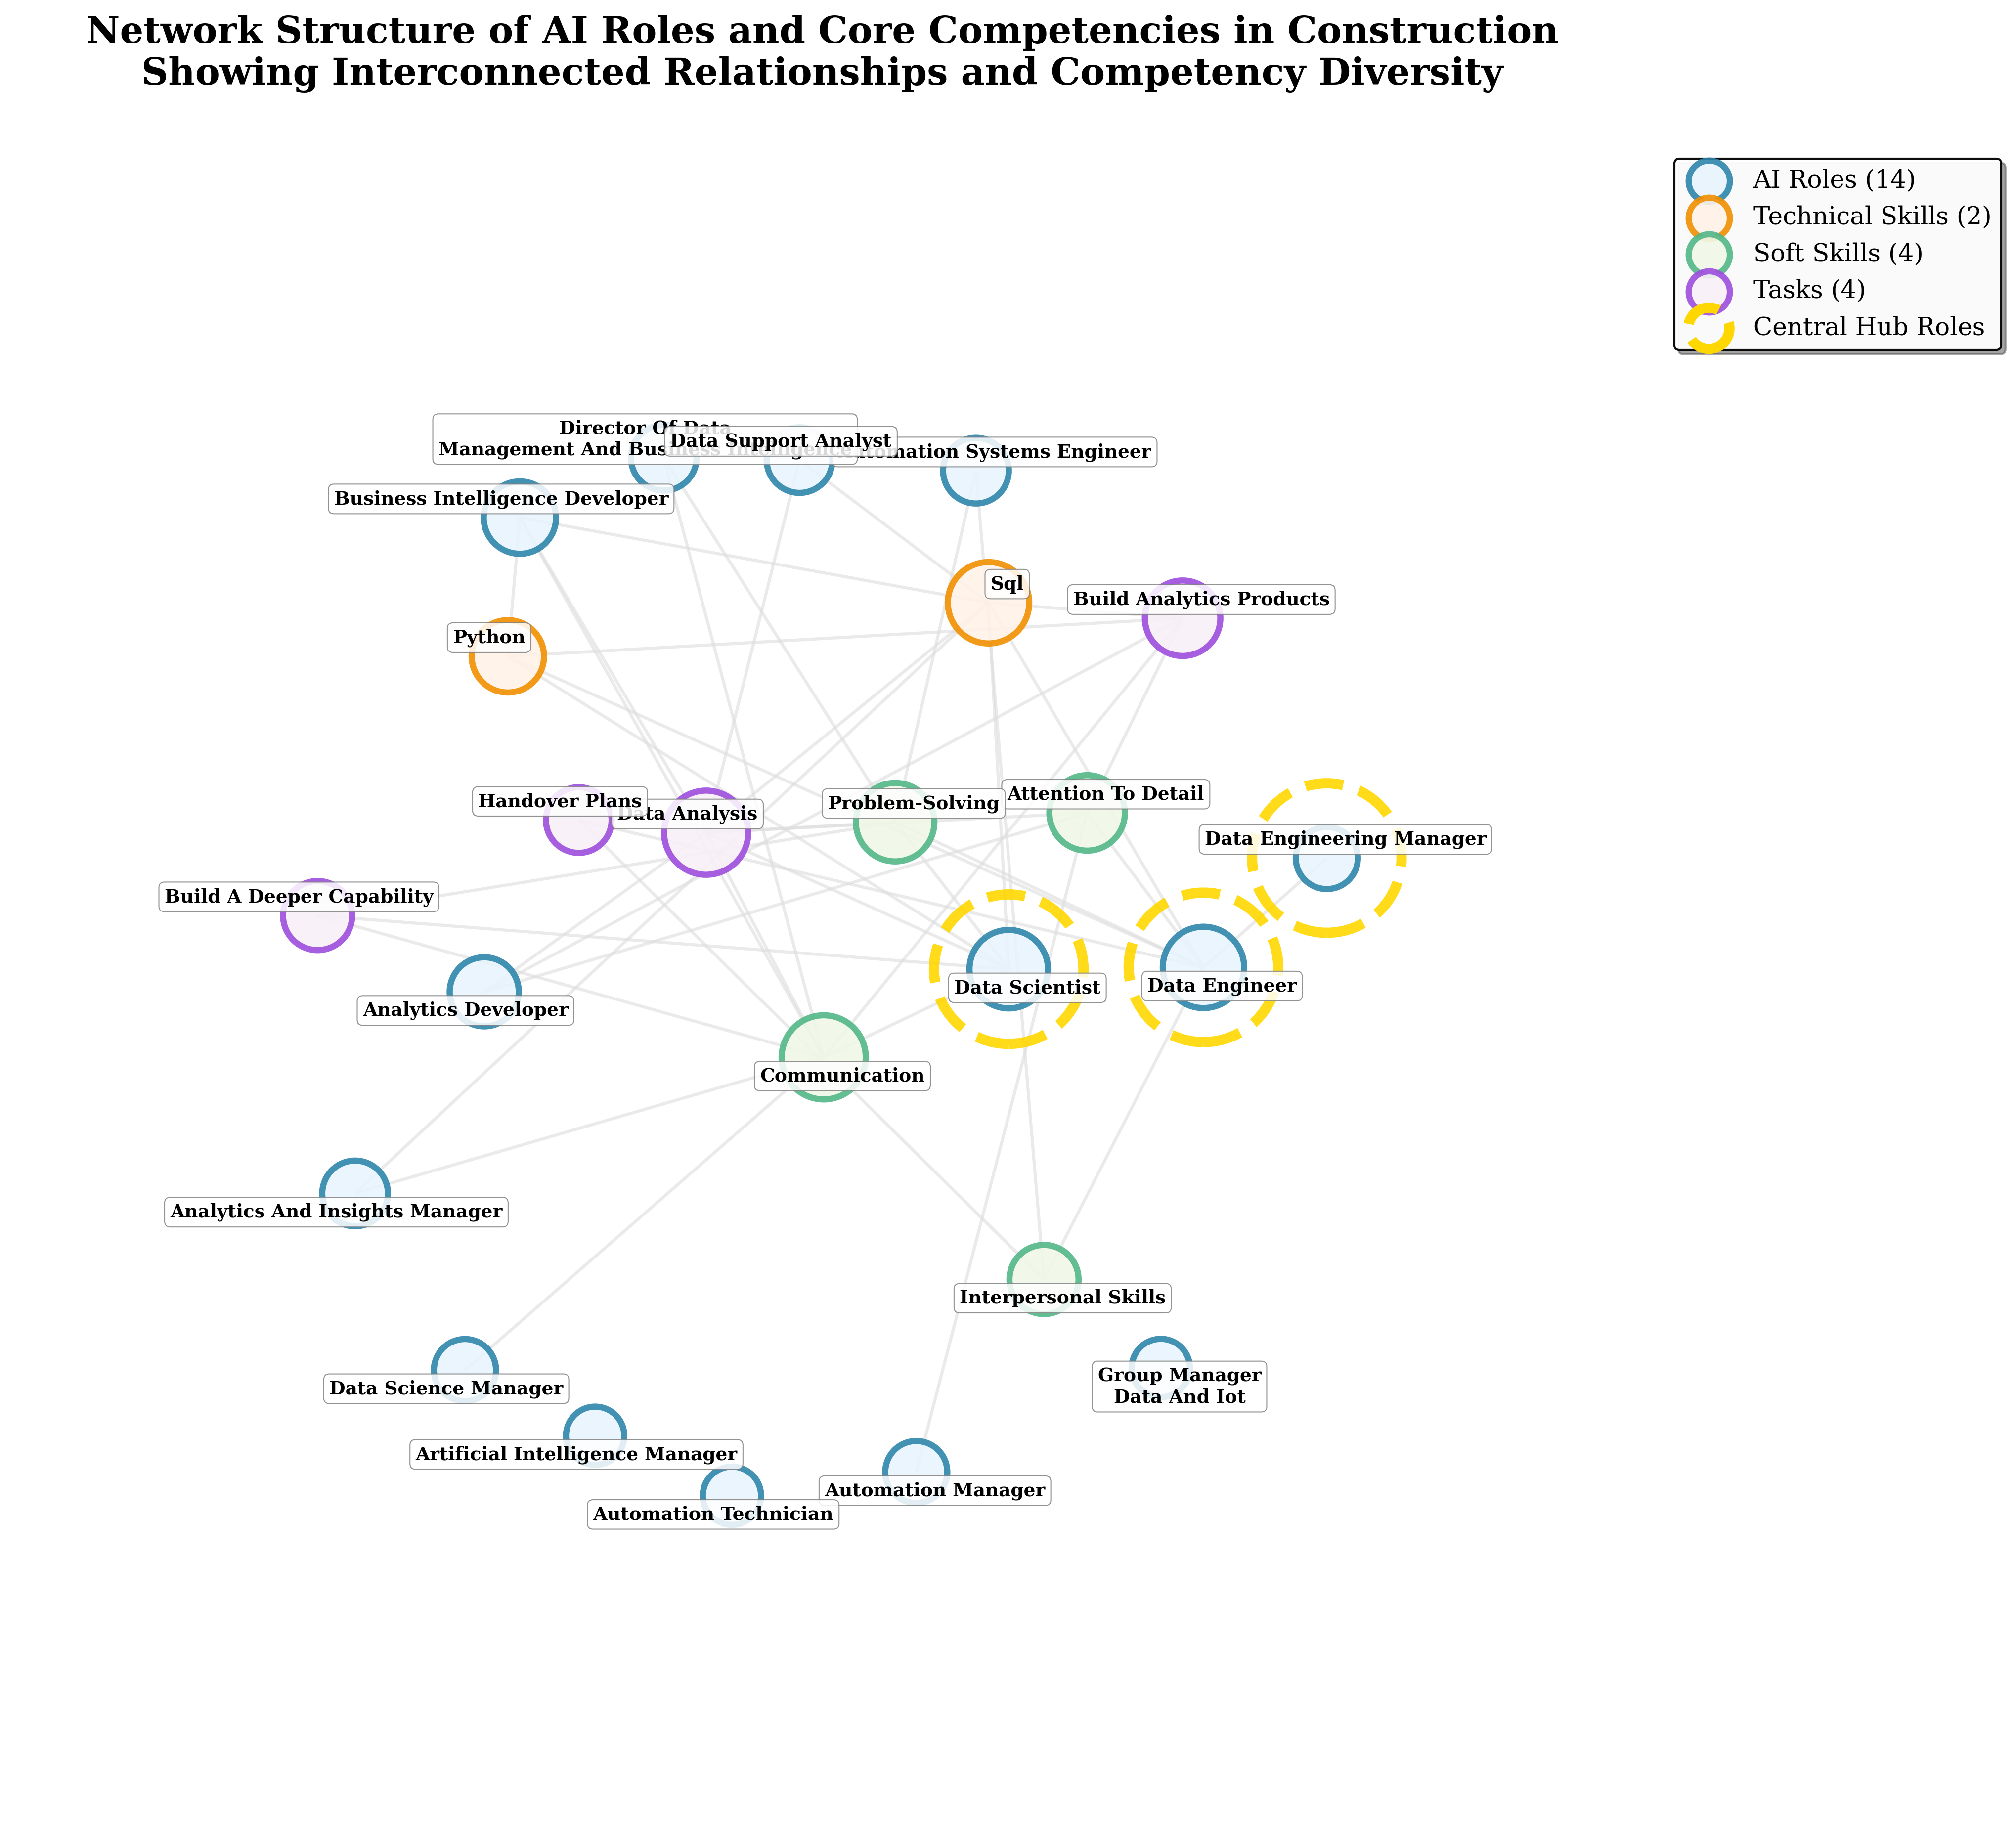

✓ Improved Figure 5 saved as: Figure5_Improved_AI_Network_Structure.png

Competency Type Breakdown:
Technical Skills (2): Python, Sql
Soft Skills (4): Communication, Problem-Solving, Attention To Detail, Interpersonal Skills
Tasks (4): Data Analysis, Handover Plans, Build Analytics Products, Build A Deeper Capability

Central Hub Roles:
  Data Engineering Manager: Degree=0.043, Betweenness=0.000
  Data Engineer: Degree=0.304, Betweenness=0.228
  Data Scientist: Degree=0.261, Betweenness=0.046


In [7]:
# Improved Network Visualization for Figure 5
# Dr. M. Reza Hosseini - University of Melbourne

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load the data from your existing analysis
# (Assuming you have the subgraph G and variables from previous analysis)

# If starting fresh, load the GraphML and recreate the subgraph
G_full = nx.read_graphml('/content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_roles_only_dedup.graphml')
if G_full.is_multigraph():
    G_full = nx.Graph(G_full)

# Define the 14 AI roles and extract them
target_ai_roles = [
    'Data Scientist', 'Data Engineer', 'Automation Systems Engineer',
    'Business Intelligence Developer', 'Analytics and Insights Manager',
    'Group Manager Data and IoT', 'Automation Manager', 'AI Manager',
    'Analytics Developer', 'Data Support Analyst', 'Data Science Manager',
    'Director of Data Management and Business Intelligence',
    'Data Engineering Manager', 'Automation Technician'
]

# Find AI roles
ai_roles_found = []
for node, attrs in G_full.nodes(data=True):
    node_id = attrs.get('id', '')
    node_label = attrs.get('labels', '')
    if ':Role' in node_label:
        for target_role in target_ai_roles:
            if (node_id.lower() == target_role.lower() or
                node_id.replace(' And ', ' and ').replace('&', 'and').lower() ==
                target_role.replace(' And ', ' and ').replace('&', 'and').lower() or
                ('ai manager' in target_role.lower() and 'artificial intelligence manager' in node_id.lower())):
                ai_roles_found.append(node)
                break

# Get top 10 core competencies
ai_role_neighbors = set()
for role_node in ai_roles_found:
    ai_role_neighbors.update(G_full.neighbors(role_node))

all_competencies = [node for node, attrs in G_full.nodes(data=True)
                   if any(comp_type in attrs.get('labels', '')
                         for comp_type in [':Technical skill', ':Soft skill', ':Tool', ':Task'])]
connected_competencies = [comp for comp in all_competencies if comp in ai_role_neighbors]
competency_degrees = {comp: G_full.degree(comp) for comp in connected_competencies}
top_competencies = sorted(competency_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
core_competencies = [comp[0] for comp in top_competencies]

# Create the subgraph
final_nodes = ai_roles_found + core_competencies
G = G_full.subgraph(final_nodes).copy()

# Calculate metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Set publication style
plt.style.use('default')
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'serif',
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': True,
    'legend.fancybox': True,
    'legend.shadow': True,
    'figure.dpi': 300
})

# Create improved visualization with better layout
print("Creating improved network visualization...")
fig, ax = plt.subplots(1, 1, figsize=(18, 14))  # Larger figure size

# Use spring layout with better spacing parameters
pos = nx.spring_layout(G, k=5, iterations=150, seed=42)

# Scale positions to use more space and avoid overlaps
scale_factor = 1.5
for node in pos:
    pos[node] = (pos[node][0] * scale_factor, pos[node][1] * scale_factor)

# Define improved colors that don't obscure text
ai_role_color = '#E8F4FD'        # Light blue for AI roles
ai_role_edge = '#2E86AB'         # Dark blue edge for AI roles
tech_skill_color = '#FFF2E8'     # Light orange for technical skills
tech_skill_edge = '#F18F01'      # Orange edge for technical skills
soft_skill_color = '#F0F8E8'     # Light green for soft skills
soft_skill_edge = '#52B788'      # Green edge for soft skills
task_color = '#F8F0F8'           # Light purple for tasks
task_edge = '#9D4EDD'            # Purple edge for tasks

# Categorize nodes and create color/edge mappings
node_colors = []
edge_colors = []
node_sizes = []
full_node_labels = {}

# Create competency type mapping
competency_types = {}
for node in core_competencies:
    node_label = G.nodes[node]['labels']
    if ':Technical skill' in node_label:
        competency_types[node] = 'technical'
    elif ':Soft skill' in node_label:
        competency_types[node] = 'soft'
    elif ':Task' in node_label:
        competency_types[node] = 'task'
    else:
        competency_types[node] = 'other'

for node in G.nodes():
    # Size based on degree centrality (larger range for better visibility)
    size = 800 + (degree_centrality[node] * 2500)
    node_sizes.append(size)

    # Colors and labels
    if node in ai_roles_found:
        node_colors.append(ai_role_color)
        edge_colors.append(ai_role_edge)
    else:
        comp_type = competency_types.get(node, 'other')
        if comp_type == 'technical':
            node_colors.append(tech_skill_color)
            edge_colors.append(tech_skill_edge)
        elif comp_type == 'soft':
            node_colors.append(soft_skill_color)
            edge_colors.append(soft_skill_edge)
        elif comp_type == 'task':
            node_colors.append(task_color)
            edge_colors.append(task_edge)
        else:
            node_colors.append('#F5F5F5')
            edge_colors.append('#999999')

    # Use FULL labels without truncation
    full_node_labels[node] = G.nodes[node]['id']

# Draw edges with consistent color
nx.draw_networkx_edges(G, pos,
                      edge_color='#DDDDDD',
                      alpha=0.6,
                      width=1.5,
                      ax=ax)

# Draw nodes with edge colors
nx.draw_networkx_nodes(G, pos,
                      node_color=node_colors,
                      node_size=node_sizes,
                      alpha=0.9,
                      linewidths=3,
                      edgecolors=edge_colors,
                      ax=ax)

# Manual label positioning to avoid overlaps
label_offsets = {}
for node in G.nodes():
    x, y = pos[node]

    # Calculate offset based on node degree to avoid central crowding
    degree = G.degree(node)
    if degree > 15:  # High degree nodes - offset more
        offset_x = 0.15 if x > 0 else -0.15
        offset_y = 0.12 if y > 0 else -0.12
    elif degree > 8:  # Medium degree nodes
        offset_x = 0.1 if x > 0 else -0.1
        offset_y = 0.08 if y > 0 else -0.08
    else:  # Low degree nodes
        offset_x = 0.05 if x > 0 else -0.05
        offset_y = 0.05 if y > 0 else -0.05

    label_offsets[node] = (x + offset_x, y + offset_y)

# Draw labels with better positioning and full text
for node, label in full_node_labels.items():
    x, y = label_offsets[node]

    # Multi-line labels for very long names
    if len(label) > 25:
        words = label.split()
        if len(words) > 4:
            mid_point = len(words) // 2
            label = ' '.join(words[:mid_point]) + '\n' + ' '.join(words[mid_point:])

    ax.text(x, y, label,
           fontsize=9,
           fontweight='bold',
           ha='center',
           va='center',
           color='black',
           bbox=dict(boxstyle='round,pad=0.3',
                    facecolor='white',
                    alpha=0.85,
                    edgecolor='gray',
                    linewidth=0.5))

# Highlight central hub roles (Data Scientist and Data Engineer)
central_roles = []
for node in G.nodes():
    role_name = G.nodes[node]['id']
    if 'Data Scientist' in role_name or 'Data Engineer' in role_name:
        central_roles.append(node)

for node in central_roles:
    if node in pos:
        x, y = pos[node]
        circle = plt.Circle((x, y), 0.2, fill=False, color='#FFD700',
                          linewidth=5, linestyle='--', alpha=0.9)
        ax.add_patch(circle)

# Create legend positioned OUTSIDE the plot area
legend_elements = [
    plt.scatter([], [], c=ai_role_color, s=400, alpha=0.9,
               edgecolors=ai_role_edge, linewidth=3, label='AI Roles (14)'),
    plt.scatter([], [], c=tech_skill_color, s=400, alpha=0.9,
               edgecolors=tech_skill_edge, linewidth=3, label='Technical Skills (2)'),
    plt.scatter([], [], c=soft_skill_color, s=400, alpha=0.9,
               edgecolors=soft_skill_edge, linewidth=3, label='Soft Skills (4)'),
    plt.scatter([], [], c=task_color, s=400, alpha=0.9,
               edgecolors=task_edge, linewidth=3, label='Tasks (4)'),
    plt.scatter([], [], facecolors='none', edgecolors='#FFD700', s=400,
               linewidth=5, linestyle='--', label='Central Hub Roles')
]

# Position legend outside plot area
legend = ax.legend(handles=legend_elements,
                  bbox_to_anchor=(1.02, 1),
                  loc='upper left',
                  fontsize=12,
                  framealpha=0.95,
                  edgecolor='black',
                  fancybox=True,
                  shadow=True)
legend.get_frame().set_facecolor('white')

# Set title with proper spacing
ax.set_title('Network Structure of AI Roles and Core Competencies in Construction\n' +
            'Showing Interconnected Relationships and Competency Diversity',
            fontsize=18, fontweight='bold', pad=30)

# Set larger axis limits to accommodate all labels
xlims = [pos[node][0] for node in pos.keys()]
ylims = [pos[node][1] for node in pos.keys()]
x_margin = (max(xlims) - min(xlims)) * 0.3
y_margin = (max(ylims) - min(ylims)) * 0.3

ax.set_xlim(min(xlims) - x_margin, max(xlims) + x_margin)
ax.set_ylim(min(ylims) - y_margin, max(ylims) + y_margin)

ax.set_aspect('equal')
ax.axis('off')

# Adjust layout to prevent clipping
plt.tight_layout()
plt.subplots_adjust(bottom=0.1, top=0.9)

plt.savefig('/content/drive/MyDrive/Figure5_Improved_AI_Network_Structure.png',
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print("✓ Improved Figure 5 saved as: Figure5_Improved_AI_Network_Structure.png")

# Print competency breakdown for verification
print("\nCompetency Type Breakdown:")
tech_skills = [G.nodes[node]['id'] for node in core_competencies if competency_types[node] == 'technical']
soft_skills = [G.nodes[node]['id'] for node in core_competencies if competency_types[node] == 'soft']
tasks = [G.nodes[node]['id'] for node in core_competencies if competency_types[node] == 'task']

print(f"Technical Skills ({len(tech_skills)}): {', '.join(tech_skills)}")
print(f"Soft Skills ({len(soft_skills)}): {', '.join(soft_skills)}")
print(f"Tasks ({len(tasks)}): {', '.join(tasks)}")

print(f"\nCentral Hub Roles:")
for node in central_roles:
    role_name = G.nodes[node]['id']
    degree_cent = degree_centrality[node]
    between_cent = betweenness_centrality[node]
    print(f"  {role_name}: Degree={degree_cent:.3f}, Betweenness={between_cent:.3f}")

Creating improved network visualization...
Creating improved network visualization...


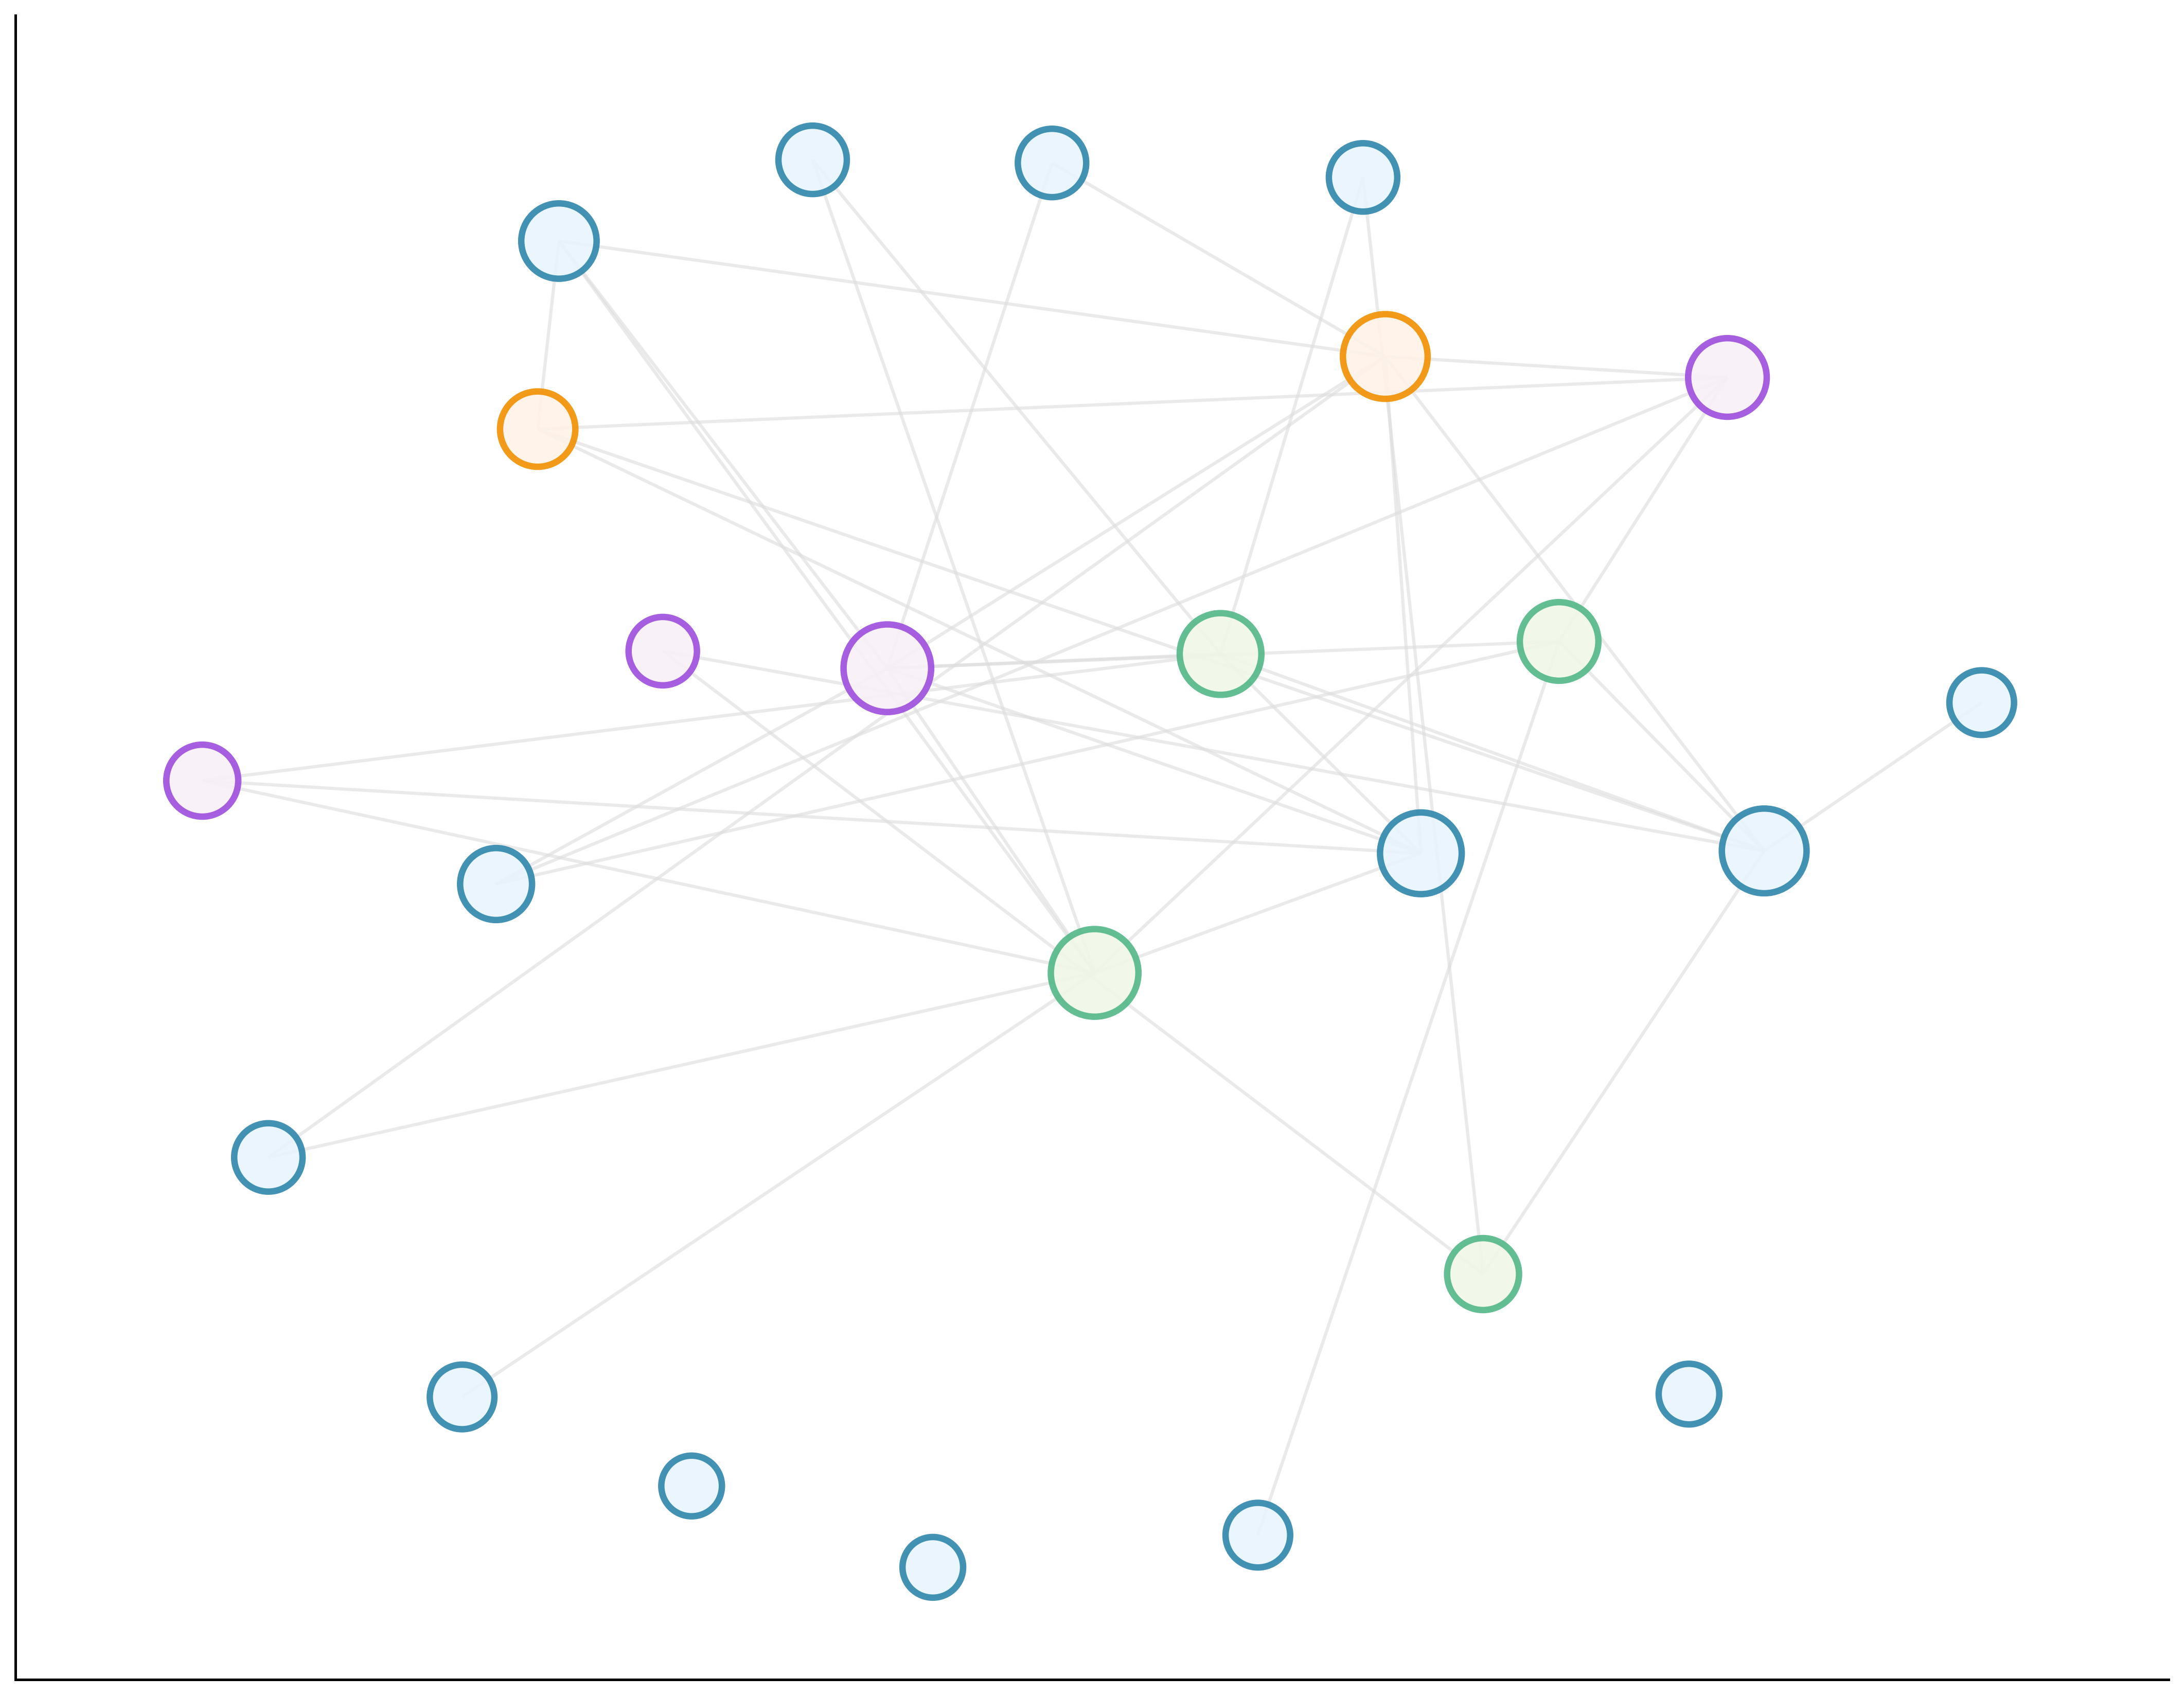

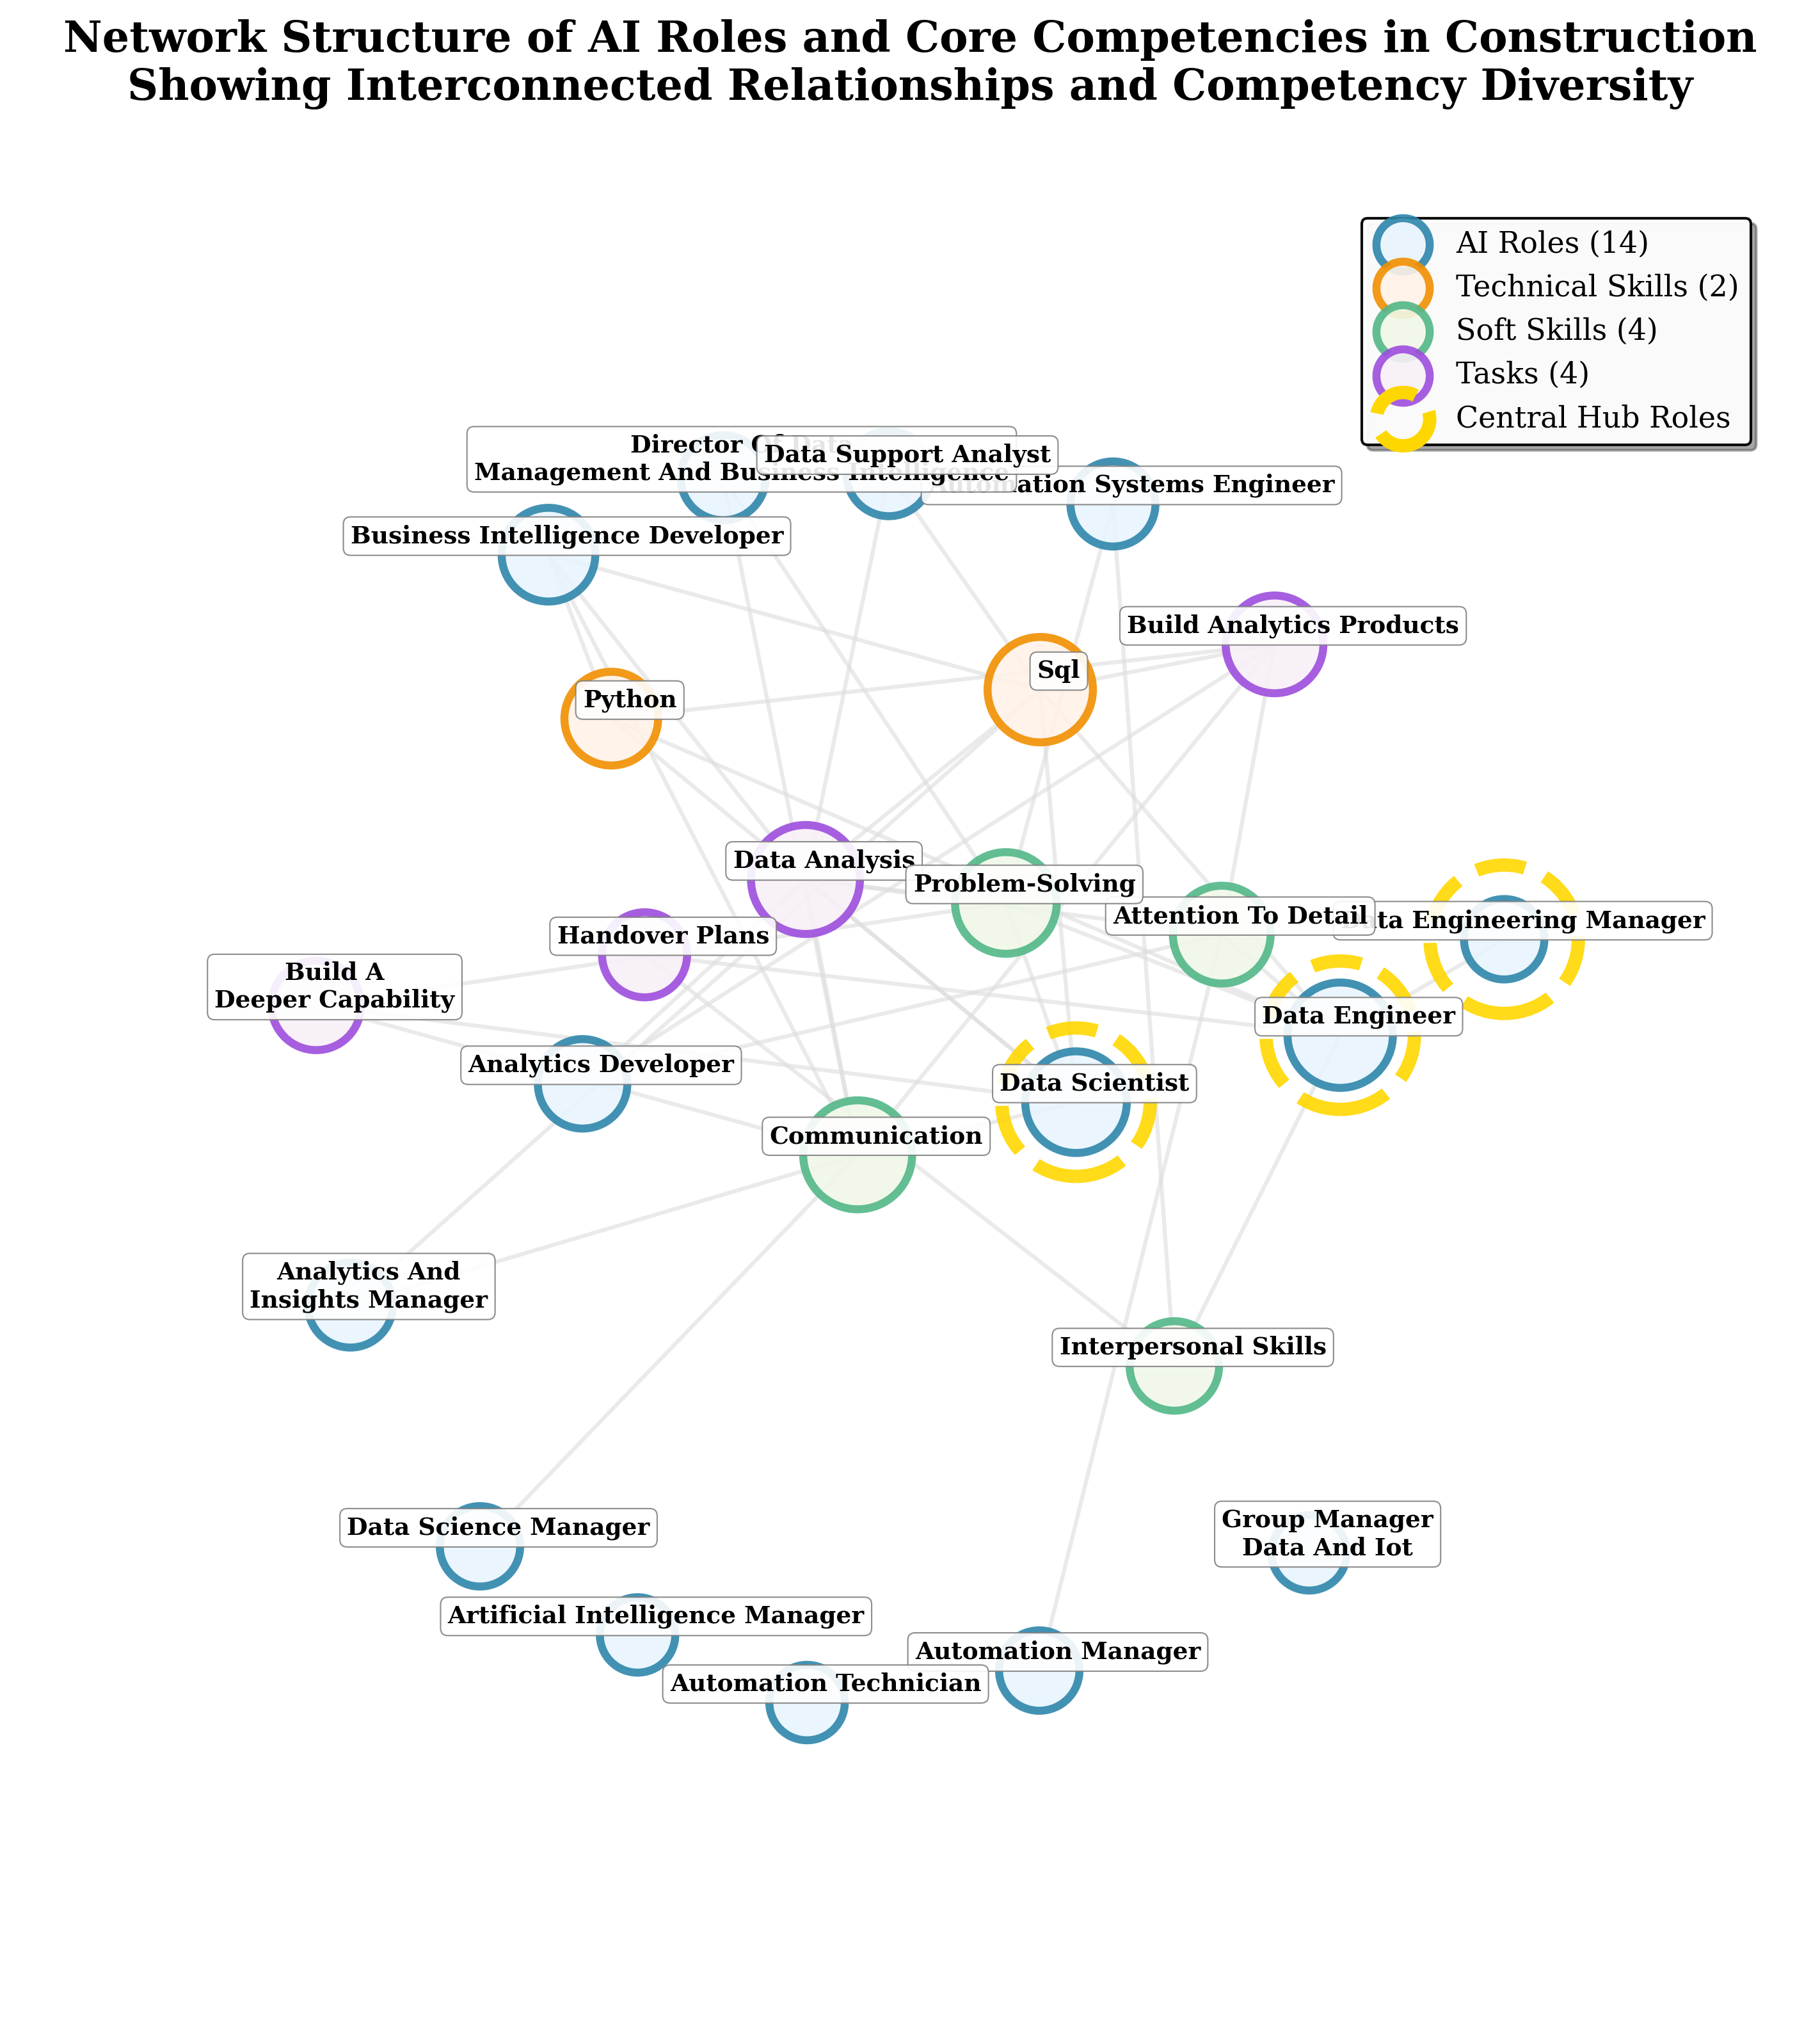

✓ Improved Figure 5 saved as: Figure5_Improved_AI_Network_Structure.png

Competency Type Breakdown:
Technical Skills (2): Python, Sql
Soft Skills (4): Communication, Problem-Solving, Attention To Detail, Interpersonal Skills
Tasks (4): Data Analysis, Handover Plans, Build Analytics Products, Build A Deeper Capability

Central Hub Roles:
  Data Engineering Manager: Degree=0.043, Betweenness=0.000
  Data Engineer: Degree=0.304, Betweenness=0.228
  Data Scientist: Degree=0.261, Betweenness=0.046


In [8]:
# Improved Network Visualization for Figure 5
# Dr. M. Reza Hosseini - University of Melbourne

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load the data from your existing analysis
# (Assuming you have the subgraph G and variables from previous analysis)

# If starting fresh, load the GraphML and recreate the subgraph
G_full = nx.read_graphml('/content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_roles_only_dedup.graphml')
if G_full.is_multigraph():
    G_full = nx.Graph(G_full)

# Define the 14 AI roles and extract them
target_ai_roles = [
    'Data Scientist', 'Data Engineer', 'Automation Systems Engineer',
    'Business Intelligence Developer', 'Analytics and Insights Manager',
    'Group Manager Data and IoT', 'Automation Manager', 'AI Manager',
    'Analytics Developer', 'Data Support Analyst', 'Data Science Manager',
    'Director of Data Management and Business Intelligence',
    'Data Engineering Manager', 'Automation Technician'
]

# Find AI roles
ai_roles_found = []
for node, attrs in G_full.nodes(data=True):
    node_id = attrs.get('id', '')
    node_label = attrs.get('labels', '')
    if ':Role' in node_label:
        for target_role in target_ai_roles:
            if (node_id.lower() == target_role.lower() or
                node_id.replace(' And ', ' and ').replace('&', 'and').lower() ==
                target_role.replace(' And ', ' and ').replace('&', 'and').lower() or
                ('ai manager' in target_role.lower() and 'artificial intelligence manager' in node_id.lower())):
                ai_roles_found.append(node)
                break

# Get top 10 core competencies
ai_role_neighbors = set()
for role_node in ai_roles_found:
    ai_role_neighbors.update(G_full.neighbors(role_node))

all_competencies = [node for node, attrs in G_full.nodes(data=True)
                   if any(comp_type in attrs.get('labels', '')
                         for comp_type in [':Technical skill', ':Soft skill', ':Tool', ':Task'])]
connected_competencies = [comp for comp in all_competencies if comp in ai_role_neighbors]
competency_degrees = {comp: G_full.degree(comp) for comp in connected_competencies}
top_competencies = sorted(competency_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
core_competencies = [comp[0] for comp in top_competencies]

# Create the subgraph
final_nodes = ai_roles_found + core_competencies
G = G_full.subgraph(final_nodes).copy()

# Calculate metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Set publication style
plt.style.use('default')
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'serif',
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': True,
    'legend.fancybox': True,
    'legend.shadow': True,
    'figure.dpi': 300
})

# Create improved visualization with better layout
print("Creating improved network visualization...")
fig, ax = plt.subplots(1, 1, figsize=(18, 14))  # Larger figure size

# Use spring layout with better spacing parameters
pos = nx.spring_layout(G, k=5, iterations=150, seed=42)

# Scale positions to use more space and avoid overlaps
scale_factor = 1.5
for node in pos:
    pos[node] = (pos[node][0] * scale_factor, pos[node][1] * scale_factor)

# Define improved colors that don't obscure text
ai_role_color = '#E8F4FD'        # Light blue for AI roles
ai_role_edge = '#2E86AB'         # Dark blue edge for AI roles
tech_skill_color = '#FFF2E8'     # Light orange for technical skills
tech_skill_edge = '#F18F01'      # Orange edge for technical skills
soft_skill_color = '#F0F8E8'     # Light green for soft skills
soft_skill_edge = '#52B788'      # Green edge for soft skills
task_color = '#F8F0F8'           # Light purple for tasks
task_edge = '#9D4EDD'            # Purple edge for tasks

# Categorize nodes and create color/edge mappings
node_colors = []
edge_colors = []
node_sizes = []
full_node_labels = {}

# Create competency type mapping
competency_types = {}
for node in core_competencies:
    node_label = G.nodes[node]['labels']
    if ':Technical skill' in node_label:
        competency_types[node] = 'technical'
    elif ':Soft skill' in node_label:
        competency_types[node] = 'soft'
    elif ':Task' in node_label:
        competency_types[node] = 'task'
    else:
        competency_types[node] = 'other'

for node in G.nodes():
    # Size based on degree centrality (larger range for better visibility)
    size = 800 + (degree_centrality[node] * 2500)
    node_sizes.append(size)

    # Colors and labels
    if node in ai_roles_found:
        node_colors.append(ai_role_color)
        edge_colors.append(ai_role_edge)
    else:
        comp_type = competency_types.get(node, 'other')
        if comp_type == 'technical':
            node_colors.append(tech_skill_color)
            edge_colors.append(tech_skill_edge)
        elif comp_type == 'soft':
            node_colors.append(soft_skill_color)
            edge_colors.append(soft_skill_edge)
        elif comp_type == 'task':
            node_colors.append(task_color)
            edge_colors.append(task_edge)
        else:
            node_colors.append('#F5F5F5')
            edge_colors.append('#999999')

    # Use FULL labels without truncation
    full_node_labels[node] = G.nodes[node]['id']

# Draw edges with consistent color
nx.draw_networkx_edges(G, pos,
                      edge_color='#DDDDDD',
                      alpha=0.6,
                      width=1.5,
                      ax=ax)

# Draw nodes with edge colors
nx.draw_networkx_nodes(G, pos,
                      node_color=node_colors,
                      node_size=node_sizes,
                      alpha=0.9,
                      linewidths=3,
                      edgecolors=edge_colors,
                      ax=ax)

# Create improved visualization with better layout
print("Creating improved network visualization...")
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Use spring layout with better spacing parameters
pos = nx.spring_layout(G, k=6, iterations=200, seed=42)

# Scale positions to use more space and avoid overlaps
scale_factor = 1.8
for node in pos:
    pos[node] = (pos[node][0] * scale_factor, pos[node][1] * scale_factor)

# Define improved colors that don't obscure text
ai_role_color = '#E8F4FD'        # Light blue for AI roles
ai_role_edge = '#2E86AB'         # Dark blue edge for AI roles
tech_skill_color = '#FFF2E8'     # Light orange for technical skills
tech_skill_edge = '#F18F01'      # Orange edge for technical skills
soft_skill_color = '#F0F8E8'     # Light green for soft skills
soft_skill_edge = '#52B788'      # Green edge for soft skills
task_color = '#F8F0F8'           # Light purple for tasks
task_edge = '#9D4EDD'            # Purple edge for tasks

# Categorize nodes and create color/edge mappings
node_colors = []
edge_colors = []
node_sizes = []
full_node_labels = {}

# Create competency type mapping
competency_types = {}
for node in core_competencies:
    node_label = G.nodes[node]['labels']
    if ':Technical skill' in node_label:
        competency_types[node] = 'technical'
    elif ':Soft skill' in node_label:
        competency_types[node] = 'soft'
    elif ':Task' in node_label:
        competency_types[node] = 'task'
    else:
        competency_types[node] = 'other'

for node in G.nodes():
    # Size based on degree centrality (larger range for better visibility)
    size = 800 + (degree_centrality[node] * 2500)
    node_sizes.append(size)

    # Colors and labels
    if node in ai_roles_found:
        node_colors.append(ai_role_color)
        edge_colors.append(ai_role_edge)
    else:
        comp_type = competency_types.get(node, 'other')
        if comp_type == 'technical':
            node_colors.append(tech_skill_color)
            edge_colors.append(tech_skill_edge)
        elif comp_type == 'soft':
            node_colors.append(soft_skill_color)
            edge_colors.append(soft_skill_edge)
        elif comp_type == 'task':
            node_colors.append(task_color)
            edge_colors.append(task_edge)
        else:
            node_colors.append('#F5F5F5')
            edge_colors.append('#999999')

    # Use FULL labels without truncation
    full_node_labels[node] = G.nodes[node]['id']

# Draw edges with consistent color
nx.draw_networkx_edges(G, pos,
                      edge_color='#DDDDDD',
                      alpha=0.6,
                      width=1.5,
                      ax=ax)

# Draw nodes with edge colors
nx.draw_networkx_nodes(G, pos,
                      node_color=node_colors,
                      node_size=node_sizes,
                      alpha=0.9,
                      linewidths=3,
                      edgecolors=edge_colors,
                      ax=ax)

# Advanced label positioning to prevent overlaps
def adjust_label_positions(pos, labels, min_distance=0.3):
    """Adjust label positions to prevent overlaps using iterative force-based approach"""
    label_pos = {}

    # Initial positions - offset from nodes
    for node in pos:
        x, y = pos[node]
        # Start with small offset from node
        label_pos[node] = [x + 0.05, y + 0.05]

    # Iteratively adjust positions to minimize overlaps
    for iteration in range(50):  # Max iterations
        forces = {node: [0, 0] for node in pos}

        # Calculate repulsive forces between labels
        nodes = list(label_pos.keys())
        for i, node1 in enumerate(nodes):
            for node2 in nodes[i+1:]:
                x1, y1 = label_pos[node1]
                x2, y2 = label_pos[node2]

                dx = x1 - x2
                dy = y1 - y2
                distance = np.sqrt(dx**2 + dy**2)

                if distance < min_distance and distance > 0:
                    # Calculate repulsive force
                    force_magnitude = (min_distance - distance) / distance
                    force_x = dx * force_magnitude * 0.1
                    force_y = dy * force_magnitude * 0.1

                    forces[node1][0] += force_x
                    forces[node1][1] += force_y
                    forces[node2][0] -= force_x
                    forces[node2][1] -= force_y

        # Apply forces with constraints
        max_move = 0
        for node in label_pos:
            # Apply force
            label_pos[node][0] += forces[node][0]
            label_pos[node][1] += forces[node][1]

            # Keep labels reasonably close to their nodes
            node_x, node_y = pos[node]
            max_offset = 0.4

            if abs(label_pos[node][0] - node_x) > max_offset:
                label_pos[node][0] = node_x + max_offset * np.sign(label_pos[node][0] - node_x)
            if abs(label_pos[node][1] - node_y) > max_offset:
                label_pos[node][1] = node_y + max_offset * np.sign(label_pos[node][1] - node_y)

            max_move = max(max_move, abs(forces[node][0]) + abs(forces[node][1]))

        # Stop if convergence reached
        if max_move < 0.001:
            break

    return {node: tuple(pos) for node, pos in label_pos.items()}

# Get optimized label positions
label_positions = adjust_label_positions(pos, full_node_labels)

# Draw labels with optimized positioning
for node, label in full_node_labels.items():
    x, y = label_positions[node]

    # Multi-line labels for very long names
    if len(label) > 30:
        words = label.split()
        if len(words) > 4:
            mid_point = len(words) // 2
            label = ' '.join(words[:mid_point]) + '\n' + ' '.join(words[mid_point:])
    elif len(label) > 20:
        words = label.split()
        if len(words) > 3:
            mid_point = len(words) // 2
            label = ' '.join(words[:mid_point]) + '\n' + ' '.join(words[mid_point:])

    ax.text(x, y, label,
           fontsize=9,
           fontweight='bold',
           ha='center',
           va='center',
           color='black',
           bbox=dict(boxstyle='round,pad=0.3',
                    facecolor='white',
                    alpha=0.9,
                    edgecolor='gray',
                    linewidth=0.5))

# Highlight central hub roles (Data Scientist and Data Engineer)
central_roles = []
for node in G.nodes():
    role_name = G.nodes[node]['id']
    if 'Data Scientist' in role_name or 'Data Engineer' in role_name:
        central_roles.append(node)

for node in central_roles:
    if node in pos:
        x, y = pos[node]
        circle = plt.Circle((x, y), 0.2, fill=False, color='#FFD700',
                          linewidth=5, linestyle='--', alpha=0.9)
        ax.add_patch(circle)

# Create legend positioned closer to the network (top-right corner)
legend_elements = [
    plt.scatter([], [], c=ai_role_color, s=400, alpha=0.9,
               edgecolors=ai_role_edge, linewidth=3, label='AI Roles (14)'),
    plt.scatter([], [], c=tech_skill_color, s=400, alpha=0.9,
               edgecolors=tech_skill_edge, linewidth=3, label='Technical Skills (2)'),
    plt.scatter([], [], c=soft_skill_color, s=400, alpha=0.9,
               edgecolors=soft_skill_edge, linewidth=3, label='Soft Skills (4)'),
    plt.scatter([], [], c=task_color, s=400, alpha=0.9,
               edgecolors=task_edge, linewidth=3, label='Tasks (4)'),
    plt.scatter([], [], facecolors='none', edgecolors='#FFD700', s=400,
               linewidth=5, linestyle='--', label='Central Hub Roles')
]

# Position legend in top-right corner of the plot area, but close to network
legend = ax.legend(handles=legend_elements,
                  loc='upper right',
                  fontsize=11,
                  framealpha=0.95,
                  edgecolor='black',
                  fancybox=True,
                  shadow=True,
                  bbox_to_anchor=(0.98, 0.98))  # Close to top-right corner
legend.get_frame().set_facecolor('white')

# Set title with proper spacing
ax.set_title('Network Structure of AI Roles and Core Competencies in Construction\n' +
            'Showing Interconnected Relationships and Competency Diversity',
            fontsize=16, fontweight='bold', pad=25)

# Set axis limits with appropriate margins
xlims = [pos[node][0] for node in pos.keys()]
ylims = [pos[node][1] for node in pos.keys()]
x_margin = (max(xlims) - min(xlims)) * 0.25
y_margin = (max(ylims) - min(ylims)) * 0.25

ax.set_xlim(min(xlims) - x_margin, max(xlims) + x_margin)
ax.set_ylim(min(ylims) - y_margin, max(ylims) + y_margin)

ax.set_aspect('equal')
ax.axis('off')

# Adjust layout to prevent clipping
plt.tight_layout()
plt.subplots_adjust(bottom=0.1, top=0.9)

plt.savefig('/content/drive/MyDrive/Figure5_Improved_AI_Network_Structure.png',
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print("✓ Improved Figure 5 saved as: Figure5_Improved_AI_Network_Structure.png")

# Print competency breakdown for verification
print("\nCompetency Type Breakdown:")
tech_skills = [G.nodes[node]['id'] for node in core_competencies if competency_types[node] == 'technical']
soft_skills = [G.nodes[node]['id'] for node in core_competencies if competency_types[node] == 'soft']
tasks = [G.nodes[node]['id'] for node in core_competencies if competency_types[node] == 'task']

print(f"Technical Skills ({len(tech_skills)}): {', '.join(tech_skills)}")
print(f"Soft Skills ({len(soft_skills)}): {', '.join(soft_skills)}")
print(f"Tasks ({len(tasks)}): {', '.join(tasks)}")

print(f"\nCentral Hub Roles:")
for node in central_roles:
    role_name = G.nodes[node]['id']
    degree_cent = degree_centrality[node]
    between_cent = betweenness_centrality[node]
    print(f"  {role_name}: Degree={degree_cent:.3f}, Betweenness={between_cent:.3f}")

In [10]:
# Improved Network Visualization for Figure 5
# Dr. M. Reza Hosseini - University of Melbourne

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load the data from your existing analysis
# (Assuming you have the subgraph G and variables from previous analysis)

# If starting fresh, load the GraphML and recreate the subgraph
G_full = nx.read_graphml('/content/drive/MyDrive/knowledge-graph-llms/cleaned_graph_roles_only_dedup.graphml')
if G_full.is_multigraph():
    G_full = nx.Graph(G_full)

# Define the 14 AI roles and extract them
target_ai_roles = [
    'Data Scientist', 'Data Engineer', 'Automation Systems Engineer',
    'Business Intelligence Developer', 'Analytics and Insights Manager',
    'Group Manager Data and IoT', 'Automation Manager', 'AI Manager',
    'Analytics Developer', 'Data Support Analyst', 'Data Science Manager',
    'Director of Data Management and Business Intelligence',
    'Data Engineering Manager', 'Automation Technician'
]

# Find AI roles
ai_roles_found = []
for node, attrs in G_full.nodes(data=True):
    node_id = attrs.get('id', '')
    node_label = attrs.get('labels', '')
    if ':Role' in node_label:
        for target_role in target_ai_roles:
            if (node_id.lower() == target_role.lower() or
                node_id.replace(' And ', ' and ').replace('&', 'and').lower() ==
                target_role.replace(' And ', ' and ').replace('&', 'and').lower() or
                ('ai manager' in target_role.lower() and 'artificial intelligence manager' in node_id.lower())):
                ai_roles_found.append(node)
                break

# Get top 10 core competencies
ai_role_neighbors = set()
for role_node in ai_roles_found:
    ai_role_neighbors.update(G_full.neighbors(role_node))

all_competencies = [node for node, attrs in G_full.nodes(data=True)
                   if any(comp_type in attrs.get('labels', '')
                         for comp_type in [':Technical skill', ':Soft skill', ':Tool', ':Task'])]
connected_competencies = [comp for comp in all_competencies if comp in ai_role_neighbors]
competency_degrees = {comp: G_full.degree(comp) for comp in connected_competencies}
top_competencies = sorted(competency_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
core_competencies = [comp[0] for comp in top_competencies]

# Create the subgraph
final_nodes = ai_roles_found + core_competencies
G = G_full.subgraph(final_nodes).copy()

# Calculate metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Set publication style
plt.style.use('default')
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'serif',
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': True,
    'legend.fancybox': True,
    'legend.shadow': True,
    'figure.dpi': 300
})

# Create improved visualization with better layout
print("Creating improved network visualization...")
fig, ax = plt.subplots(1, 1, figsize=(18, 14))  # Larger figure size

# Use spring layout with better spacing parameters
pos = nx.spring_layout(G, k=5, iterations=150, seed=42)

# Scale positions to use more space and avoid overlaps
scale_factor = 1.5
for node in pos:
    pos[node] = (pos[node][0] * scale_factor, pos[node][1] * scale_factor)

# Define improved colors that don't obscure text
ai_role_color = '#E8F4FD'        # Light blue for AI roles
ai_role_edge = '#2E86AB'         # Dark blue edge for AI roles
tech_skill_color = '#FFF2E8'     # Light orange for technical skills
tech_skill_edge = '#F18F01'      # Orange edge for technical skills
soft_skill_color = '#F0F8E8'     # Light green for soft skills
soft_skill_edge = '#52B788'      # Green edge for soft skills
task_color = '#F8F0F8'           # Light purple for tasks
task_edge = '#9D4EDD'            # Purple edge for tasks

# Categorize nodes and create color/edge mappings
node_colors = []
edge_colors = []
node_sizes = []
full_node_labels = {}

# Create competency type mapping
competency_types = {}
for node in core_competencies:
    node_label = G.nodes[node]['labels']
    if ':Technical skill' in node_label:
        competency_types[node] = 'technical'
    elif ':Soft skill' in node_label:
        competency_types[node] = 'soft'
    elif ':Task' in node_label:
        competency_types[node] = 'task'
    else:
        competency_types[node] = 'other'

for node in G.nodes():
    # Size based on degree centrality (larger range for better visibility)
    size = 800 + (degree_centrality[node] * 2500)
    node_sizes.append(size)

    # Colors and labels
    if node in ai_roles_found:
        node_colors.append(ai_role_color)
        edge_colors.append(ai_role_edge)
    else:
        comp_type = competency_types.get(node, 'other')
        if comp_type == 'technical':
            node_colors.append(tech_skill_color)
            edge_colors.append(tech_skill_edge)
        elif comp_type == 'soft':
            node_colors.append(soft_skill_color)
            edge_colors.append(soft_skill_edge)
        elif comp_type == 'task':
            node_colors.append(task_color)
            edge_colors.append(task_edge)
        else:
            node_colors.append('#F5F5F5')
            edge_colors.append('#999999')

    # Use FULL labels without truncation
    full_node_labels[node] = G.nodes[node]['id']

# Draw edges with consistent color
nx.draw_networkx_edges(G, pos,
                      edge_color='#DDDDDD',
                      alpha=0.6,
                      width=1.5,
                      ax=ax)

# Draw nodes with edge colors
nx.draw_networkx_nodes(G, pos,
                      node_color=node_colors,
                      node_size=node_sizes,
                      alpha=0.9,
                      linewidths=3,
                      edgecolors=edge_colors,
                      ax=ax)

# Create improved visualization with much better spacing
print("Creating improved network visualization with advanced label positioning...")
fig, ax = plt.subplots(1, 1, figsize=(20, 16))  # Even larger figure

# Use multiple layout attempts to find the best one
best_pos = None
best_score = 0  # Initialize to 0, not infinity since we want MAXIMUM distance

for seed in [42, 123, 456, 789, 999]:  # Try multiple seeds
    temp_pos = nx.spring_layout(G, k=8, iterations=300, seed=seed)

    # Calculate average distance between nodes (we want maximum spacing)
    total_dist = 0
    count = 0
    nodes = list(temp_pos.keys())
    for i, node1 in enumerate(nodes):
        for node2 in nodes[i+1:]:
            x1, y1 = temp_pos[node1]
            x2, y2 = temp_pos[node2]
            dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
            total_dist += dist
            count += 1

    avg_dist = total_dist / count if count > 0 else 0

    # We want the layout with maximum average distance
    if avg_dist > best_score:
        best_score = avg_dist
        best_pos = temp_pos

# Fallback in case no layout was selected (shouldn't happen, but safety)
if best_pos is None:
    best_pos = nx.spring_layout(G, k=8, iterations=300, seed=42)

pos = best_pos

# Scale positions much more aggressively
scale_factor = 3.0  # Much larger scaling
for node in pos:
    pos[node] = (pos[node][0] * scale_factor, pos[node][1] * scale_factor)

# Define improved colors
ai_role_color = '#E8F4FD'
ai_role_edge = '#2E86AB'
tech_skill_color = '#FFF2E8'
tech_skill_edge = '#F18F01'
soft_skill_color = '#F0F8E8'
soft_skill_edge = '#52B788'
task_color = '#F8F0F8'
task_edge = '#9D4EDD'

# Categorize nodes and create mappings
node_colors = []
edge_colors = []
node_sizes = []
full_node_labels = {}

competency_types = {}
for node in core_competencies:
    node_label = G.nodes[node]['labels']
    if ':Technical skill' in node_label:
        competency_types[node] = 'technical'
    elif ':Soft skill' in node_label:
        competency_types[node] = 'soft'
    elif ':Task' in node_label:
        competency_types[node] = 'task'
    else:
        competency_types[node] = 'other'

for node in G.nodes():
    size = 1000 + (degree_centrality[node] * 3000)  # Larger nodes
    node_sizes.append(size)

    if node in ai_roles_found:
        node_colors.append(ai_role_color)
        edge_colors.append(ai_role_edge)
    else:
        comp_type = competency_types.get(node, 'other')
        if comp_type == 'technical':
            node_colors.append(tech_skill_color)
            edge_colors.append(tech_skill_edge)
        elif comp_type == 'soft':
            node_colors.append(soft_skill_color)
            edge_colors.append(soft_skill_edge)
        elif comp_type == 'task':
            node_colors.append(task_color)
            edge_colors.append(task_edge)
        else:
            node_colors.append('#F5F5F5')
            edge_colors.append('#999999')

    full_node_labels[node] = G.nodes[node]['id']

# Draw edges
nx.draw_networkx_edges(G, pos,
                      edge_color='#DDDDDD',
                      alpha=0.5,
                      width=2,
                      ax=ax)

# Draw nodes
nx.draw_networkx_nodes(G, pos,
                      node_color=node_colors,
                      node_size=node_sizes,
                      alpha=0.9,
                      linewidths=3,
                      edgecolors=edge_colors,
                      ax=ax)

# Much more aggressive label positioning to prevent overlaps
def advanced_label_positioning(pos, labels, min_distance=1.0):
    """Advanced label positioning with aggressive separation"""
    label_pos = {}

    # Start with positions around nodes in a circle pattern
    for i, node in enumerate(pos):
        x, y = pos[node]
        # Place labels in a circle around the node
        angle = (i * 2 * np.pi) / len(pos)
        radius = 0.4
        label_pos[node] = [x + radius * np.cos(angle), y + radius * np.sin(angle)]

    # Iteratively separate overlapping labels
    for iteration in range(100):  # More iterations
        max_movement = 0

        nodes = list(label_pos.keys())
        for i, node1 in enumerate(nodes):
            for node2 in nodes[i+1:]:
                x1, y1 = label_pos[node1]
                x2, y2 = label_pos[node2]

                dx = x1 - x2
                dy = y1 - y2
                distance = np.sqrt(dx**2 + dy**2)

                if distance < min_distance and distance > 0:
                    # Calculate strong repulsive force
                    overlap = min_distance - distance
                    force_magnitude = overlap * 0.5  # Strong force

                    # Normalize direction
                    force_x = (dx / distance) * force_magnitude
                    force_y = (dy / distance) * force_magnitude

                    # Apply forces
                    label_pos[node1][0] += force_x
                    label_pos[node1][1] += force_y
                    label_pos[node2][0] -= force_x
                    label_pos[node2][1] -= force_y

                    max_movement = max(max_movement, abs(force_x) + abs(force_y))

        # Stop if minimal movement
        if max_movement < 0.01:
            break

    return {node: tuple(pos) for node, pos in label_pos.items()}

# Get optimized label positions with larger minimum distance
label_positions = advanced_label_positioning(pos, full_node_labels, min_distance=1.2)

# Draw connection lines from nodes to labels when they're far apart
for node in G.nodes():
    node_x, node_y = pos[node]
    label_x, label_y = label_positions[node]

    distance = np.sqrt((node_x - label_x)**2 + (node_y - label_y)**2)

    # Draw connection line if label is far from node
    if distance > 0.3:
        ax.plot([node_x, label_x], [node_y, label_y],
               color='gray', alpha=0.4, linewidth=1, linestyle='--')

# Draw labels with optimized positioning
for node, label in full_node_labels.items():
    x, y = label_positions[node]

    # Smart multi-line breaking for long labels
    if len(label) > 25:
        words = label.split()
        if len(words) >= 4:
            # Split roughly in half
            mid = len(words) // 2
            label = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
        elif len(words) == 3:
            label = words[0] + ' ' + words[1] + '\n' + words[2]

    # Different font sizes based on node importance
    node_degree = G.degree(node)
    if node_degree > 15:
        fontsize = 11
        pad = 0.4
    elif node_degree > 8:
        fontsize = 10
        pad = 0.35
    else:
        fontsize = 9
        pad = 0.3

    ax.text(x, y, label,
           fontsize=fontsize,
           fontweight='bold',
           ha='center',
           va='center',
           color='black',
           bbox=dict(boxstyle=f'round,pad={pad}',
                    facecolor='white',
                    alpha=0.95,
                    edgecolor='gray',
                    linewidth=0.8))

# Highlight central hub roles
central_roles = []
for node in G.nodes():
    role_name = G.nodes[node]['id']
    if 'Data Scientist' in role_name or 'Data Engineer' in role_name:
        central_roles.append(node)

for node in central_roles:
    if node in pos:
        x, y = pos[node]
        circle = plt.Circle((x, y), 0.25, fill=False, color='#FFD700',
                          linewidth=6, linestyle='--', alpha=0.9)
        ax.add_patch(circle)

# Create legend in a good position
legend_elements = [
    plt.scatter([], [], c=ai_role_color, s=500, alpha=0.9,
               edgecolors=ai_role_edge, linewidth=3, label='AI Roles (14)'),
    plt.scatter([], [], c=tech_skill_color, s=500, alpha=0.9,
               edgecolors=tech_skill_edge, linewidth=3, label='Technical Skills (2)'),
    plt.scatter([], [], c=soft_skill_color, s=500, alpha=0.9,
               edgecolors=soft_skill_edge, linewidth=3, label='Soft Skills (4)'),
    plt.scatter([], [], c=task_color, s=500, alpha=0.9,
               edgecolors=task_edge, linewidth=3, label='Tasks (4)'),
    plt.scatter([], [], facecolors='none', edgecolors='#FFD700', s=500,
               linewidth=6, linestyle='--', label='Central Hub Roles')
]

# Find a good spot for legend (area with fewest nodes)
xlims = [pos[node][0] for node in pos.keys()]
ylims = [pos[node][1] for node in pos.keys()]

# Place legend in top-left corner with some padding
legend = ax.legend(handles=legend_elements,
                  loc='upper left',
                  fontsize=12,
                  framealpha=0.95,
                  edgecolor='black',
                  fancybox=True,
                  shadow=True)
legend.get_frame().set_facecolor('white')

# Set title
ax.set_title('Network Structure of AI Roles and Core Competencies in Construction\n' +
            'Showing Interconnected Relationships and Competency Diversity',
            fontsize=18, fontweight='bold', pad=30)

# Set axis limits with tight margins
x_margin = (max(xlims) - min(xlims)) * 0.15
y_margin = (max(ylims) - min(ylims)) * 0.15

ax.set_xlim(min(xlims) - x_margin, max(xlims) + x_margin)
ax.set_ylim(min(ylims) - y_margin, max(ylims) + y_margin)

ax.set_aspect('equal')
ax.axis('off')

# Adjust layout to prevent clipping
plt.tight_layout()
plt.subplots_adjust(bottom=0.1, top=0.9)

plt.savefig('/content/drive/MyDrive/Figure5_Improved_AI_Network_Structure.png',
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print("✓ Improved Figure 5 saved as: Figure5_Improved_AI_Network_Structure.png")

# Print competency breakdown for verification
print("\nCompetency Type Breakdown:")
tech_skills = [G.nodes[node]['id'] for node in core_competencies if competency_types[node] == 'technical']
soft_skills = [G.nodes[node]['id'] for node in core_competencies if competency_types[node] == 'soft']
tasks = [G.nodes[node]['id'] for node in core_competencies if competency_types[node] == 'task']

print(f"Technical Skills ({len(tech_skills)}): {', '.join(tech_skills)}")
print(f"Soft Skills ({len(soft_skills)}): {', '.join(soft_skills)}")
print(f"Tasks ({len(tasks)}): {', '.join(tasks)}")

print(f"\nCentral Hub Roles:")
for node in central_roles:
    role_name = G.nodes[node]['id']
    degree_cent = degree_centrality[node]
    between_cent = betweenness_centrality[node]
    print(f"  {role_name}: Degree={degree_cent:.3f}, Betweenness={between_cent:.3f}")

Output hidden; open in https://colab.research.google.com to view.